# Moving Averages Strategy
___

In order for the Machine learning part to be run properly, we used Google Colab's cloud computing services. Such large models would be impossible to compute on a 'normal' PC. Therefore the notebook is intended to work on google colab.

Our recommendations for the execution environment is to use one that allows GPUs and has enough memory to run the code as is. The one that we use is the GPU Nvidia A100.

___
## 1. Importations

Please make sure you have the right dependencies installed.

In [1]:
# =====================================
# Basic Libraries
# =====================================

import os
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import itertools
from itertools                import combinations
from collections              import Counter, defaultdict
from mpl_toolkits.mplot3d     import Axes3D  # necessary for 3D plotting if needed

# =====================================
# Scikit-Learn
# =====================================

from sklearn.model_selection   import GridSearchCV
from sklearn.ensemble          import RandomForestClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.metrics           import (accuracy_score, precision_score,recall_score, roc_auc_score)

# =====================================
# Data management libraries
# =====================================
import pickle
from google.colab              import drive

# =====================================
# External Libraries
# =====================================
!pip install wrds --quiet
import wrds       # WRDS database connection
!pip install ta --quiet
import ta         # Technical analysis indicators

print('Imports done !')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 49.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Imports done !


___
## 2. Loading Data

**Function:** `fetch_sp500_vix()`

This function queries the WRDS database to extract **daily** data for the current S&P 500 constituents and the CBOE VIX from **2005-01-01** through **2022-01-01**. It computes:

- **Total return** (`ret`)  
- **Split- and dividend-adjusted price** (`prc_adj`)  
- **Split-adjusted volume** (`vol_adj`)  
- **Shares outstanding** (in thousands, `shrout_k`)  
- **Market capitalization** (in USD millions, `mktcap_usd_m`)  
- **Closing VIX value** (`vix`)

It also brings along each security’s `ticker` and `comnam`.

---

### Requirements
- A valid WRDS account and an open connection (e.g. via `wrds.Connection()`).
- The helper `db.raw_sql()` must point at that active connection and have permissions on the `crsp` and `cboe` libraries.

---

### Tables & Joins

- **`crsp.msp500list`** (`sp`)  
  Defines the S&P 500 membership history.
- **`crsp.dsf`** (`dsf`)  
  Daily stock file for price, return, volume, and share count.
- **`crsp.msenames`** (`names`)  
  Provides the valid ticker (`ticker`) and company name (`comnam`) for each date.
- **`cboe.cboe`** (`v`)  
  Contains the CBOE VIX series; joined by matching `date`.

---

### Output DataFrame Columns

| Column        | Description                                                      |
|---------------|------------------------------------------------------------------|
| `date`        | Trading date                                                     |
| `permno`      | CRSP permanent number                                            |
| `ret`         | Daily total return                                               |
| `prc_adj`     | Absolute price adjusted for splits & dividends                   |
| `vol_adj`     | Volume adjusted for stock splits                                 |
| `shrout_k`    | Shares outstanding (thousands)                                   |
| `mktcap_usd_m`| Market capitalization (millions of USD)                          |
| `ticker`      | Stock ticker                                                     |
| `comnam`      | Company name                                                     |
| `vix`         | CBOE VIX closing value                                           |


In [ ]:
# Connect to WRDS

#username : jules_remlinger
#mdp      : tafpax-meJdin-mysbe9
db = wrds.Connection()

Enter your WRDS username [root]:jules_remlinger
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
def fetch_sp500_vix():
    """
    Pull S&P 500 constituents’ daily total return, split/div-adjusted price & volume,
    shares outstanding (in thousands), compute market-cap (in millions),
    plus the VIX close from 2006-01-01 through 2022-01-01.
    """
    query = '''
    SELECT
      dsf.date,
      dsf.permno,
      dsf.ret,
      /* fully-adjusted close price */
      ABS(dsf.prc)/dsf.cfacpr          AS prc_adj,
      /* volume adjusted for splits */
      dsf.vol/dsf.cfacshr              AS vol_adj,
      /* shares outstanding (in thousands) */
      dsf.shrout                       AS shrout_k,
      /* market-cap in millions USD */
      (ABS(dsf.prc)/dsf.cfacpr)*dsf.shrout/1e3 AS mktcap_usd_m,
      names.ticker,
      names.comnam,
      /* VIX close from CBOE library */
      v.vix                            AS vix
    FROM crsp.msp500list    AS sp
    JOIN crsp.dsf           AS dsf
      ON dsf.permno = sp.permno
     AND dsf.date   BETWEEN sp.start AND sp.ending
    JOIN crsp.msenames      AS names
      ON dsf.permno = names.permno
     AND dsf.date   BETWEEN names.namedt
                       AND COALESCE(names.nameendt,'9999-12-31')
    LEFT JOIN cboe.cboe     AS v
      ON dsf.date = v.date
    WHERE dsf.date BETWEEN '2005-01-01' AND '2022-01-01'
    ORDER BY dsf.date, dsf.permno;
    '''
    return db.raw_sql(query, date_cols=['date'])

wrds_data = fetch_sp500_vix()

Our query begins in 2005 because we need prior data in order to calibrate the different features (e.g a moving average on the last X days needs X days of data prior to the start date)

___
## 3. Inspecting the Data

In [ ]:
wrds_data

date  permno       ret    prc_adj         vol_adj    shrout_k  \
0      2005-01-03   10078 -0.051948      20.44     335524272.0   3377861.0   
1      2005-01-03   10104 -0.022595      13.41      60640045.0   5224866.0   
2      2005-01-03   10107  0.000749      26.74      69205063.0  10880222.0   
3      2005-01-03   10108 -0.009884      28.05       1858400.0    288871.0   
4      2005-01-03   10137 -0.017757      19.36       1345400.0    137258.0   
...           ...     ...       ...        ...             ...         ...   
149386 2021-12-31   93096       0.0     235.83       1714700.0    231707.0   
149387 2021-12-31   93132 -0.001056  71.879998        103898.6    162000.0   
149388 2021-12-31   93246 -0.002946  351.92001        406450.0     63090.0   
149389 2021-12-31   93429  0.008819  130.39999        198223.0    106643.0   
149390 2021-12-31   93436 -0.012669  352.26001  4510024.666667   1033508.0   

         mktcap_usd_m ticker                      comnam    vix  
0         69043.47884   SUNW        SUN MICROSYSTEMS INC  14.08  
1         70065.45306   ORCL                 ORACLE CORP  14.08  
2        290937.13628   MSFT              MICROSOFT CORP  14.08  
3          8102.83155    SDS    SUNGARD DATA SYSTEMS INC  14.08  
4          2657.31488    AYE        ALLEGHENY ENERGY INC  14.08  
...               ...    ...                         ...    ...  
149386    54643.46181     DG     DOLLAR GENERAL CORP NEW  17.22  
149387   11644.559676   FTNT                FORTINET INC  17.22  
149388   22202.633431   GNRC        GENERAC HOLDINGS INC  17.22  
149389   13906.246134   CBOE  C B O E GLOBAL MARKETS INC  17.22  
149390  364063.538415   TSLA                   TESLA INC  17.22  

[2149391 rows x 10 columns]

### 3.1 Universe

In [ ]:
start_date = pd.to_datetime('2008-01-01')
end_date   = pd.to_datetime('2022-01-01')

#list the tickers that have a price in between the start and end date
tickers_list = wrds_data[(wrds_data['date'] >= start_date) & (wrds_data['date'] <= end_date)]['ticker'].unique()

print("Number of tickers:", len(tickers_list))


Number of tickers: 865


### 3.2 Analyzing data

We can take a look at the number of tickers over time to see if we indeed have 500 or close to 500 at all dates:

#### 3.2.1 Number of tickers

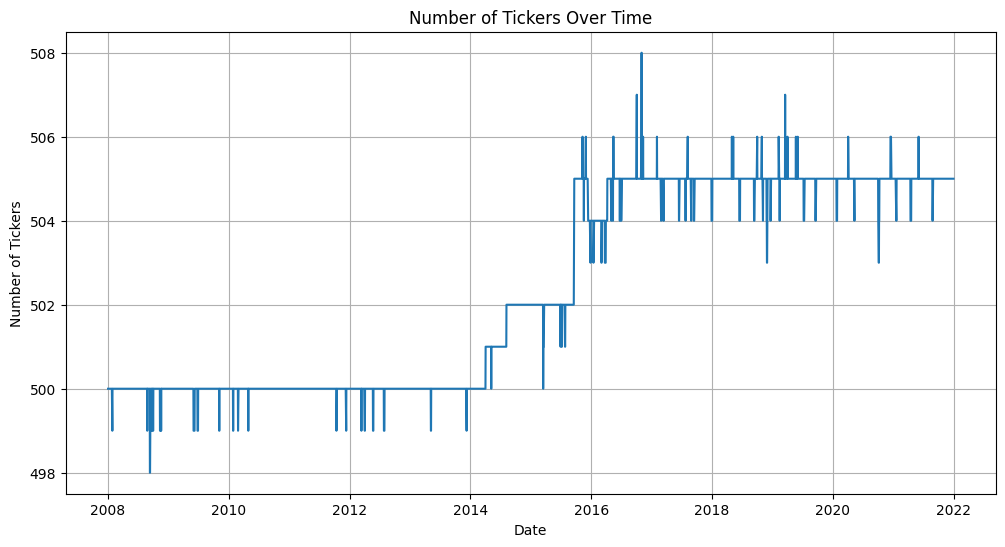

In [ ]:
# Ensure 'date' column is in datetime format
wrds_data['date'] = pd.to_datetime(wrds_data['date'])

# Compute the number of unique tickers per date
tickers_over_time = wrds_data.groupby('date')['permno'].nunique()

# Filter by date range using the index (which is already datetime)
tickers_over_time = tickers_over_time[
    (tickers_over_time.index >= '2008-01-01') &
    (tickers_over_time.index <= '2022-01-01')
]
# Plot
plt.figure(figsize=(12, 6))
plt.plot(tickers_over_time.index, tickers_over_time.values, linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Tickers')
plt.title('Number of Tickers Over Time')
plt.grid(True)
plt.show()


We can see that we have 500 or close to 500 stocks for each date. The jumps around the number 500 before 2014 is due to delistings and various non_trading days.

**Why the jump after 2014?**
In April 2014, S&P began listing multiple share classes for companies like Google (GOOGL/GOOG) and subsequently for others (Berkshire Hathaway A/B, Under Armour A/C, News Corp A/B, etc.). At the time of a June 2024 review, there were three dual-class companies (503 lines).

#### 3.2.2 Dealing with NaNs and negative values

First, we check for negative prices :

In [ ]:
#Check if we have negative prices in the data
print('Number of negative prices :',len(wrds_data[wrds_data['prc_adj'] < 0]))

Number of negative prices : 0


Then, we check for NaNs.

There will be some NaNs for the first returns because there was no previous prices so we separate that case from the others.

In [ ]:
# Make a copy and filter using the 'date' column instead of the index
wrds_data_copy = wrds_data[
    (wrds_data['date'] >= pd.to_datetime('2008-01-01')) &
    (wrds_data['date'] <= pd.to_datetime('2022-01-01'))
].copy()

# Add a flag for when it's the first observation for each permno
wrds_data_copy['is_first_obs'] = (
    wrds_data_copy['date'] == wrds_data_copy.groupby('permno')['date'].transform('min')
)

# See if we have some NaNs in the data
nan_rows = wrds_data_copy[wrds_data_copy.isna().any(axis=1)]
print('* Number of NaNs :', len(nan_rows))

# Count the NaNs per column
nan_counts = nan_rows.isna().sum()
print('\n* NaN Count per column : \n', nan_counts)

# Isolate the NaNs that happen on the first date for that permno
nan_on_first = nan_rows[nan_rows['is_first_obs']]
print('\n* Rows on first date with NaNs:', len(nan_on_first))
print('\n* NaNs per column on first date:\n', nan_on_first.isna().sum())

# Remaining NaNs
nan_not_first = nan_rows[~nan_rows['is_first_obs']]
print('\n* Remaining NaNs not on first date:', len(nan_not_first))

nan_not_first


* Number of NaNs : 66

* NaN Count per column : 
 date             0
permno           0
ret             62
prc_adj          4
vol_adj          8
shrout_k         0
mktcap_usd_m     4
ticker           1
comnam           0
vix              0
is_first_obs     0
dtype: int64

* Rows on first date with NaNs: 58

* NaNs per column on first date:
 date             0
permno           0
ret             58
prc_adj          0
vol_adj          0
shrout_k         0
mktcap_usd_m     0
ticker           0
comnam           0
vix              0
is_first_obs     0
dtype: int64

* Remaining NaNs not on first date: 8


date  permno       ret  prc_adj  vol_adj    shrout_k  \
471870 2008-09-29   81593      <NA>     <NA>     <NA>   1699359.0   
78765  2009-08-05   70519  0.101538     35.8     <NA>   5507700.0   
125760 2009-12-17   70519 -0.072464     32.0     <NA>  22863947.0   
126260 2009-12-18   70519    0.0625     34.0     <NA>  22863947.0   
247754 2010-12-07   70519  0.038202     46.2     <NA>  29049600.0   
304723 2015-05-12   76744      <NA>     <NA>     <NA>    243752.0   
314258 2015-06-09   76614      <NA>     <NA>     <NA>    101306.0   
3264   2020-11-06   76841      <NA>     <NA>     <NA>    153882.0   

        mktcap_usd_m ticker                         comnam    vix  \
471870          <NA>   <NA>          WASHINGTON MUTUAL INC  46.72   
78765      197175.66      C                  CITIGROUP INC   24.9   
125760    731646.304      C                  CITIGROUP INC  22.51   
126260    777374.198      C                  CITIGROUP INC  21.68   
247754    1342091.52      C                  CITIGROUP INC  17.99   
304723          <NA>   VRTX     VERTEX PHARMACEUTICALS INC  13.86   
314258          <NA>   REGN  REGENERON PHARMACEUTICALS INC  14.47   
3264            <NA>   BIIB                     BIOGEN INC  24.86   

        is_first_obs  
471870         False  
78765          False  
125760         False  
126260         False  
247754         False  
304723         False  
314258         False  
3264           False

We can analyze all the remaining NaNs:

* **For the Citigroup missing values** : CRSP DSF volume is sometimes suppressed on days with corporate-action adjustments (ex-dividend, splits) or trading halts. Price and return exist, so we choose to forward-fill volume here.

  - 2009-08-05: is likely a ex-dividend/special session day.
  - 2009-12-17: is likely a ex-dividend/special session day.
  - 2009-12-18: A low-liquidity or holiday-adjacent session where CRSP did not report consolidated volume.
  - 2010-12-07: Another corporate-action or data-vendor gap day; price and return are valid.

For the remaining NaNs we go line by line:

- **2015-06-09 (permno 76614, REGN – Regeneron Pharmaceuticals Inc)** : New permno issued on spin-off or corporate event; placeholder row before first actual trade under REGN.

- **2015-05-12 (permno 76744, VRTX – Vertex Pharmaceuticals Inc)** : Initial permno assignment on IPO/spin-off day, with no trading until the next session.

- **2006-03-07 (permno 76841, BIIB – Biogen Idec Inc)** : Placeholder for the new BIIB Idec permno before it began trading.

- **2006-03-08 (permno 76841, BIIB – Biogen Idec Inc)** :  Still pre-trading placeholder; first actual trade comes after this.

- **2020-11-06 (permno 76841, BIIB – Biogen Inc)** : Corporate action/name change (Biogen Idec → Biogen Inc); this row marks the permno transition with no trade data.

We will forward fill the Citigroup volumes and remove all the remaining NaNs

In [ ]:
# Forward fill the volumes for Citigroup
wrds_data = wrds_data.sort_values(['permno', 'date'])
mask_c = wrds_data['permno'] == 70519
wrds_data.loc[mask_c, 'vol_adj'] = wrds_data.loc[mask_c, 'vol_adj'].ffill()
print("Remaining Citigroup vol NaNs:", wrds_data.loc[mask_c, 'vol_adj'].isna().sum())

wrds_data = wrds_data.dropna()
print("Remaining NaNs:", wrds_data.isna().sum().sum())

Remaining Citigroup vol NaNs: 0
Remaining NaNs: 0


___
## 4. Training and prediction on a Rolling Window

### 4.1 Feature Creation

In [ ]:
# Assume wrds_data includes ['permno','date','prc_adj','ret','mktcap_usd_m']
# Copy and sort
df = wrds_data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['permno', 'date'])

# Define windows and pairs
windows = [1, 5, 30, 50, 70, 110]
window_pairs = [(l, s) for l, s in itertools.product(windows, windows) if l > s]
max_window = max(windows)

# 1) RETURNS
# Next-day returns using CRSP 'ret'
df['next_day_return'] = df.groupby('permno')['ret'].shift(-1)
# Log returns
df['log_return'] = df.groupby('permno')['prc_adj'].transform(lambda x: np.log(x / x.shift(1)))

# 2) EMA RATIOS using transform
for w in windows:
    ema = df.groupby('permno')['prc_adj'].transform(lambda x: x.ewm(span=w, adjust=False).mean())
    df[f'ema_ratio_{w}'] = ema / df['prc_adj']

# 3) DIFF FEATURES: (EMA_l - EMA_s) / EMA_s
for l, s in window_pairs:
    df[f'diff_{l}_{s}'] = (df[f'ema_ratio_{l}'] - df[f'ema_ratio_{s}']) / df[f'ema_ratio_{s}']

# 4) WILDER'S RSI

def wilder_rsi(series, window):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

for w in windows:
    df[f'rsi_{w}'] = df.groupby('permno')['prc_adj'].transform(lambda x: wilder_rsi(x, w))

# 5) VOLATILITY FEATURES (std of returns 'ret')
for w in [20, 50, 100]:
    df[f'volatility_{w}'] = df.groupby('permno')['ret'].transform(lambda x: x.rolling(window=w).std())

# 6) WARM-UP DROP: ensure all series are fully "warmed"
df['idx'] = df.groupby('permno').cumcount()
df = df[df['idx'] >= max_window].drop(columns='idx')
# Drop trivial feature
if 'ema_ratio_1' in df.columns:
    df = df.drop(columns=['ema_ratio_1'])

# 7) INDEX-LEVEL CAP-WEIGHTED RETURNS & VOLATILITY
# Compute cap weights
df['total_mktcap'] = df.groupby('date')['mktcap_usd_m'].transform('sum')
df['cap_weight'] = df['mktcap_usd_m'] / df['total_mktcap']
# Build cap-weighted index return using 'ret'
i = (df.assign(weighted_ret=df['ret'] * df['cap_weight'])
     .groupby('date')['weighted_ret'].sum()
     .to_frame('idx_return'))
# Rolling realized vol
for w in [20, 50, 100]:
    i[f'idx_vol_{w}'] = i['idx_return'].rolling(window=w).std()
# Merge back
df = df.merge(i, left_on='date', right_index=True, how='left')

# 8) CROSS-SECTIONAL RANKS
# 1-day return rank on 'ret'
df['ret_rank_1d'] = df.groupby('date')['ret'].rank(pct=True)
# 5-day return and rank
df['ret_5d'] = df.groupby('permno')['prc_adj'].pct_change(5)
df['ret_rank_5d'] = df.groupby('date')['ret_5d'].rank(pct=True)

#VIX FEATURES
df['vix_ret_1d']     = df['vix'].pct_change()                       # 1-day VIX return
df['vix_roc_5d']     = df['vix'].pct_change(5)                     # 5-day rate-of-change
df['vix_z_20d']      = (df['vix'] - df['vix'].rolling(20).mean()) \
                         / df['vix'].rolling(20).std()                # 20-day z-score
df['vix_std_20d']    = df['vix'].rolling(20).std()                 # transactional volatility
df.dropna(subset=['vix_ret_1d','vix_z_20d'], inplace=True)

# 9) FILTER BY DATE RANGE
df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]
X_df = df.reset_index(drop=True).dropna().copy()

# Preview features
X_df.head()



date  permno       ret  prc_adj     vol_adj  shrout_k  mktcap_usd_m  \
0 2008-01-02   10078 -0.039162    17.42  11338448.0  792000.0      13796.64   
1 2008-01-03   10078   -0.0155    17.15   9660955.0  792000.0       13582.8   
2 2008-01-04   10078  -0.04898    16.31  13884504.0  792000.0      12917.52   
3 2008-01-07   10078 -0.012262    16.11  15257281.0  792000.0      12759.12   
4 2008-01-08   10078 -0.015518    15.86  12592171.0  792000.0      12561.12   

  ticker                comnam    vix  ...  idx_vol_20  idx_vol_50  \
0   JAVA  SUN MICROSYSTEMS INC  23.17  ...    0.012468    0.014559   
1   JAVA  SUN MICROSYSTEMS INC  22.49  ...    0.012278    0.014559   
2   JAVA  SUN MICROSYSTEMS INC  23.94  ...    0.012660    0.014918   
3   JAVA  SUN MICROSYSTEMS INC  23.79  ...    0.011476    0.014930   
4   JAVA  SUN MICROSYSTEMS INC  25.43  ...    0.012012    0.015131   

   idx_vol_100  ret_rank_1d    ret_5d  ret_rank_5d  vix_ret_1d  vix_roc_5d  \
0     0.012784     0.064315 -0.050681     0.309129    0.029778    0.245699   
1     0.012785     0.255187 -0.063353     0.240664   -0.029348    0.205252   
2     0.013017     0.128631 -0.109716     0.085062    0.064473    0.181639   
3     0.012887     0.219917 -0.115321     0.078838   -0.006266    0.147059   
4     0.012966     0.603734 -0.125207     0.155602    0.068937    0.130222   

   vix_z_20d  vix_std_20d  
0   0.869427     1.772432  
1   0.540947     1.711812  
2   1.294269     1.781314  
3   1.096674     1.836462  
4    1.71788     1.993736  

[5 rows x 54 columns]

See all features :

In [ ]:
all_cols = X_df.columns.tolist()
for col in all_cols:
        print(col)

date
permno
ret
prc_adj
vol_adj
shrout_k
mktcap_usd_m
ticker
comnam
vix
next_day_return
log_return
ema_ratio_5
ema_ratio_30
ema_ratio_50
ema_ratio_70
ema_ratio_110
diff_5_1
diff_30_1
diff_30_5
diff_50_1
diff_50_5
diff_50_30
diff_70_1
diff_70_5
diff_70_30
diff_70_50
diff_110_1
diff_110_5
diff_110_30
diff_110_50
diff_110_70
rsi_1
rsi_5
rsi_30
rsi_50
rsi_70
rsi_110
volatility_20
volatility_50
volatility_100
total_mktcap
cap_weight
idx_return
idx_vol_20
idx_vol_50
idx_vol_100
ret_rank_1d
ret_5d
ret_rank_5d
vix_ret_1d
vix_roc_5d
vix_z_20d
vix_std_20d


### 4.2 Helper functions

Below we define two helper routines to turn a stock‐level DataFrame into a `tf.data.Dataset` of fixed‐length sequences, ready to feed into a Keras LSTM model:

1. **`sequence_generator(df, feature_cols, seq_length)`**  
   Iterates over each `permno` (stock) in the DataFrame, sorts by date, and slices out overlapping windows of length `seq_length`.  
   - **Inputs**  
     - `df`: Pandas DataFrame containing columns `feature_cols`, plus a `'label'` column  
     - `feature_cols`: list of column names to use as input features  
     - `seq_length`: integer window size  
   - **Yields**  
     - A tuple `(X_seq, y_t)` where  
       - `X_seq` is a `(seq_length, len(feature_cols))` float32 array  
       - `y_t` is the integer label at the end of that window  

2. **`make_dataset(df, feature_cols, seq_length, shuffle=False)`**  
   Wraps the generator in a `tf.data.Dataset`, applies an optional shuffle, and returns a ready‐to‐use dataset.  
   - **Parameters**  
     - `shuffle` (bool): whether to randomly shuffle the sequence examples  
   - **Returns**  
     - A `tf.data.Dataset` yielding `(X_seq, y)` pairs, suitable for `.batch()`, `.prefetch()`, etc.

Use these functions to efficiently stream mini‐batches of sequential data into your LSTM training loop.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Normalization, Input
from tensorflow.keras.optimizers import RMSprop

# --- Sequence generator for tf.data ---
def sequence_generator(df, feature_cols, seq_length):
    for permno, sub in df.groupby('permno'):
        sub = sub.sort_values('date')
        data = sub[feature_cols].values.astype(np.float32)
        labels = sub['label'].values.astype(np.int32)
        for i in range(seq_length, len(data)):
            yield data[i-seq_length:i], labels[i]

# Create a tf.data.Dataset from generator
def make_dataset(df, feature_cols, seq_length, shuffle=False):
    output_signature = (
        tf.TensorSpec(shape=(seq_length, len(feature_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: sequence_generator(df, feature_cols, seq_length),
        output_signature=output_signature
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    return ds

Here is an example of the sequence builder in action :

### 4.3 LSTM

In order to assess effectiveness accross periods, and also to have a standardized test for further parts of the project, we use a rolling window analysis.
___

The next cell should be ran carefully as it requires a lot of computing power. We recommend using google cloud computing services. Else, one can always load the results from memory in the next section.

In [ ]:
import os
import datetime
import pickle
import math

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Normalization, Input, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ── MIXED PRECISION & XLA ─────────────────────────────────────────
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (just-in-time compilation)
tf.config.optimizer.set_jit(True)

# ── HYPERPARAMS ───────────────────────────────────────────────────
start_date  = pd.to_datetime('2008-01-01')
end_date    = pd.to_datetime('2022-01-01')

training_window     = 750
validation_window   = 250
test_window         = 250
seq_length          = 180

lstm_units    = [128, 64]
lstm_dropout  = 0.15
spatial_dropout = 0.10
dense_units   = 32
L2_reg_factor = 0
learning_rate = 5e-5
epochs        = 50
batch_size    = 1024
early_stop_patience = 8

# ── YOUR DATAFRAME & FEATURES ─────────────────────────────────────

feature_cols = [
    'ret',
    'log_return',
    'ema_ratio_5',
    'ema_ratio_30',
    'ema_ratio_50',
    'ema_ratio_70',
    'diff_5_1',
    'diff_30_5',
    'diff_50_30',
    'diff_70_50',
    'diff_110_70',
    'rsi_30',
    'rsi_50',
    'rsi_70',
    'rsi_110',
]

# ── CALLBACKS ─────────────────────────────────────────────────────
es = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=early_stop_patience, restore_best_weights=True
)
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_cb = TensorBoard(
    log_dir=log_dir,
    update_freq='epoch', profile_batch=0
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=3, min_delta=1e-4,
    cooldown=2, min_lr=1e-7, verbose=1
)

# ── TF.DATA PERF TUNING ────────────────────────────────────────────
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.data.experimental import prefetch_to_device

# ── WALK FORWARD ROLLING LOOP ────────────────────────────────────────────

results = []
dates = np.sort(X_df['date'].unique())
n_periods = ((len(dates) - (training_window + validation_window + test_window))
             // test_window) + 1

for period in range(n_periods):
    tf.keras.backend.clear_session()

    # 1) compute index boundaries
    t0, t1 = period * test_window, period * test_window + training_window - 1
    v0, v1 = t1 + 1, t1 + validation_window
    s0, s1 = v1 + 1, v1 + test_window

    # 2) map to dates
    train_start, train_end = dates[t0], dates[t1]
    val_start,   val_end   = dates[v0], dates[v1]
    test_start,  test_end  = dates[s0], dates[s1]



    # 3) slice DataFrames
    train_data = X_df[(X_df.date >= train_start) & (X_df.date <= train_end)].copy()
    permnos    = train_data.permno.unique()
    val_data   = X_df[(X_df.date >= val_start) & (X_df.date <= val_end)
                      & (X_df.permno.isin(permnos))].copy()

    seq0       = max(0, s0 - seq_length)
    seq_start  = dates[seq0]

    test_data = X_df[
        (X_df.date >= seq_start) &
        (X_df.date <= test_end) &
        (X_df.permno.isin(permnos))
    ].copy()

    # 4) drop NaNs & label
    for df in (train_data, val_data, test_data):
        df.dropna(subset=['next_day_return'], inplace=True)
        med = df.groupby('date')['next_day_return'].transform('median')
        df['label'] = (df.next_day_return > med).astype(np.int32)

    # 5) log split info
    print(f"\n=== Period {period+1}/{n_periods} ===")
    for name, df in zip(['Train','Validation','Test'], [train_data, val_data, test_data]):
        print(f"* {name:10s} | {df.date.min().date()}–{df.date.max().date()} "
              f"| rows={len(df):,} | tickers={df.permno.nunique()}")

    # 6) raw pipelines
    raw_train = make_dataset(train_data, feature_cols, seq_length, shuffle=True)
    raw_val   = make_dataset(val_data,   feature_cols, seq_length, shuffle=False)
    raw_test  = make_dataset(test_data,  feature_cols, seq_length, shuffle=False)

    # 7) decorated for performance
    train_ds = (
        raw_train.cache().repeat()
        .batch(batch_size, drop_remainder=True)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    val_ds = (
        raw_val.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    test_ds = (
        raw_test.cache()
        .batch(batch_size, drop_remainder=True)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )

    # 8) normalization
    normalizer = Normalization(axis=-1)
    normalizer.adapt(train_data[feature_cols].values.astype(np.float32))

    # 9) compute steps
    def seq_count(df):
        return sum(max(0, len(g) - seq_length) for _, g in df.groupby('permno'))
    train_steps = max(1, seq_count(train_data) // batch_size)
    val_steps   = max(1, math.ceil(seq_count(val_data) / batch_size))
    test_steps  = max(1, seq_count(test_data) // batch_size)

    # 10) build & compile model
    model = Sequential([
        Input(shape=(seq_length, len(feature_cols))),
        normalizer,
        SpatialDropout1D(spatial_dropout),
        LSTM(lstm_units[0], return_sequences=True, dropout=lstm_dropout,
             kernel_regularizer=l2(L2_reg_factor)),
        LSTM(lstm_units[1], dropout=lstm_dropout,
             kernel_regularizer=l2(L2_reg_factor)),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(L2_reg_factor)),
        Dense(2, activation='softmax', dtype='float32'),
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 11) TRAIN
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[es, tb_cb, reduce_lr],
        verbose=1
    )

    # 12) EVAL & PREDICT
    # -- validation
    val_loss, val_acc = model.evaluate(val_ds, steps=val_steps, verbose=0)

    # -- test prep
    seq_total = seq_count(test_data)
    test_steps = math.ceil(seq_total / batch_size)
    test_ds = (
        raw_test.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    preds      = model.predict(test_ds, steps=test_steps)
    y_te       = np.concatenate([y for _, y in test_ds.take(test_steps)], axis=0)
    y_pred     = np.argmax(preds, axis=1)
    # align back
    test_data = test_data.reset_index(drop=True)
    test_data['prediction_proba'] = np.nan
    test_data['predicted_label']   = np.nan
    idx = 0
    for permno, group in test_data.groupby('permno', sort=False):
        L = len(group)
        n_preds = max(0, L - seq_length)
        if n_preds:
            rows = group.index[seq_length:]
            test_data.loc[rows, 'prediction_proba'] = preds[idx:idx+n_preds, 1]
            test_data.loc[rows, 'predicted_label']   = y_pred[idx:idx+n_preds]
            idx += n_preds
    assert idx == preds.shape[0]

    test_acc = accuracy_score(y_te, y_pred)
    test_auc = roc_auc_score(y_te, preds[:,1])
    print(f"test accuracy: {test_acc:.4f}")
    print(f"test roc auc: {test_auc:.4f}")

    # -- compute val metrics
    val_steps_eval = math.ceil(seq_count(val_data) / batch_size)
    val_eval_ds = (
        raw_val.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    val_preds     = model.predict(val_eval_ds, steps=val_steps_eval)
    y_true_val    = np.concatenate([y for _, y in val_eval_ds.take(val_steps_eval)], axis=0)
    y_pred_val    = np.argmax(val_preds, axis=1)

    val_acc       = accuracy_score(y_true_val, y_pred_val)
    val_auc       = roc_auc_score(y_true_val, val_preds[:,1])
    val_precision = precision_score(y_true_val, y_pred_val)
    val_recall    = recall_score(y_true_val, y_pred_val)

    # filter predictions for storage
    preds_df = test_data.loc[
        test_data['predicted_label'].notnull(),
        ['date','permno','predicted_label','prediction_proba', 'ret', 'next_day_return']
    ].copy()

    preds_df = preds_df[preds_df.date >= test_start]

    # 13) STORE AND PRINT
    results.append({
        'period': period,
        'train_range':   (train_start, train_end),
        'val_range':     (val_start,   val_end),
        'test_range':    (test_start,  test_end),

        'val_accuracy':    val_acc,
        'val_precision':   val_precision,
        'val_recall':      val_recall,
        'val_roc_auc':     val_auc,

        'test_accuracy':   test_acc,
        'test_precision':  precision_score(y_te, y_pred),
        'test_recall':     recall_score(y_te, y_pred),
        'test_roc_auc':    test_auc,

        'trade_predictions': preds_df
    })

    # pull out the latest result
    res = results[-1]

    # list your metrics
    metrics = ['accuracy','precision','recall','roc_auc']

    # build a DataFrame
    df_metrics = pd.DataFrame({
        'val':   [res[f'val_{m}']   for m in metrics],
        'test':  [res[f'test_{m}']  for m in metrics],
    }, index=metrics)

    # optional: round to 4 decimals for readability
    print(df_metrics.round(4))
    print()

# ── SAVE ALL RESULTS ───────────────────────────────────────────────
save_dir = "/content/drive/MyDrive/MASTER_PROJECT/LSTM_backup/"
os.makedirs(save_dir, exist_ok=True)
with open(os.path.join(save_dir, "results.pkl"), "wb") as f:
    pickle.dump(results, f)
print("✅ All key variables saved to:", save_dir)


Mounted at /content/drive

=== Period 1/10 ===
* Train      | 2008-01-02–2010-12-21 | rows=362,141 | tickers=572
* Validation | 2010-12-22–2011-12-16 | rows=121,346 | tickers=500
* Test       | 2011-12-19–2012-12-17 | rows=117,170 | tickers=481
Epoch 1/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 86s 160ms/step - accuracy: 0.5006 - loss: 0.6941 - val_accuracy: 0.4994 - val_loss: 0.6935 - learning_rate: 5.0000e-05
Epoch 2/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5019 - loss: 0.6936 - val_accuracy: 0.5031 - val_loss: 0.6934 - learning_rate: 5.0000e-05
Epoch 3/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5031 - loss: 0.6935 - val_accuracy: 0.4986 - val_loss: 0.6935 - learning_rate: 5.0000e-05
Epoch 4/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5053 - loss: 0.6933 - val_accuracy: 0.5011 - val_loss: 0.6935 - learning_rate: 5.0000e-05
Epoch 5/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5040 - loss: 0.6934 - val_accuracy: 0.5035 - val_loss:

### 4.4 CNN

In [ ]:
import os
import datetime
import pickle
import math
import gc

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Normalization, Input, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ── MIXED PRECISION & XLA ─────────────────────────────────────────
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (just-in-time compilation)
tf.config.optimizer.set_jit(True)

# ── HYPERPARAMS ───────────────────────────────────────────────────
start_date  = pd.to_datetime('2008-01-01')
end_date    = pd.to_datetime('2022-01-01')

training_window     = 750
validation_window   = 250
test_window         = 250
seq_length          = 180

conv_filters        = [128, 64]
kernel_size         = 3
spatial_dropout     = 0.10
dense_units         = 32
L2_reg_factor       = 0
learning_rate       = 5e-5
epochs              = 50
batch_size          = 512
early_stop_patience = 8

# ── YOUR DATAFRAME & FEATURES ─────────────────────────────────────
feature_cols = [
    'ret',
    'log_return',
    'ema_ratio_5',
    'ema_ratio_30',
    'ema_ratio_50',
    'ema_ratio_70',
    'diff_5_1',
    'diff_30_5',
    'diff_50_30',
    'diff_70_50',
    'diff_110_70',
    'rsi_30',
    'rsi_50',
    'rsi_70',
    'rsi_110',
]

# ── CALLBACKS ─────────────────────────────────────────────────────
es = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=early_stop_patience, restore_best_weights=True
)
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_cb = TensorBoard(
    log_dir=log_dir,
    update_freq='epoch', profile_batch=0
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=3, min_delta=1e-4,
    cooldown=2, min_lr=1e-7, verbose=1
)

# ── TF.DATA PERF TUNING ────────────────────────────────────────────
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.data.experimental import prefetch_to_device

# ── WALK FORWARD ROLLING LOOP ────────────────────────────────────────────

results = []
dates = np.sort(X_df['date'].unique())
n_periods = ((len(dates) - (training_window + validation_window + test_window))
             // test_window) + 1

for period in range(n_periods):
    tf.keras.backend.clear_session()

    # 1) compute index boundaries
    t0, t1 = period * test_window, period * test_window + training_window - 1
    v0, v1 = t1 + 1, t1 + validation_window
    s0, s1 = v1 + 1, v1 + test_window

    # 2) map to dates
    train_start, train_end = dates[t0], dates[t1]
    val_start,   val_end   = dates[v0], dates[v1]
    test_start,  test_end  = dates[s0], dates[s1]

    # 3) slice DataFrames
    train_data = X_df[(X_df.date >= train_start) & (X_df.date <= train_end)].copy()
    permnos    = train_data.permno.unique()
    val_data   = X_df[(X_df.date >= val_start) & (X_df.date <= val_end)
                      & (X_df.permno.isin(permnos))].copy()

    seq0 = max(0, s0 - seq_length)
    seq_start = dates[seq0]
    test_data = X_df[
         (X_df.date >= seq_start) &
         (X_df.date <= test_end) &
         (X_df.permno.isin(permnos))].copy()

    # 4) drop NaNs & label
    for df in (train_data, val_data, test_data):
        df.dropna(subset=['next_day_return'], inplace=True)
        med = df.groupby('date')['next_day_return'].transform('median')
        df['label'] = (df.next_day_return > med).astype(np.int32)

    # 5) log split info
    print(f"\n=== Period {period+1}/{n_periods} ===")
    for name, df in zip(['Train','Validation','Test'], [train_data, val_data, test_data]):
        print(f"* {name:10s} | {df.date.min().date()}–{df.date.max().date()} "
              f"| rows={len(df):,} | tickers={df.permno.nunique()}")

    # 6) raw pipelines
    raw_train = make_dataset(train_data, feature_cols, seq_length, shuffle=True)
    raw_val   = make_dataset(val_data,   feature_cols, seq_length, shuffle=False)
    raw_test  = make_dataset(test_data,  feature_cols, seq_length, shuffle=False)

    # 7) decorated for performance
    train_ds = (
        raw_train.cache().repeat()
        .batch(batch_size, drop_remainder=True)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    val_ds = (
        raw_val.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    test_ds = (
        raw_test.cache()
        .batch(batch_size, drop_remainder=True)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )

    # 8) normalization
    normalizer = Normalization(axis=-1)
    normalizer.adapt(train_data[feature_cols].values.astype(np.float32))

    # 9) compute steps
    def seq_count(df):
        return sum(max(0, len(g) - seq_length) for _, g in df.groupby('permno'))
    train_steps = max(1, seq_count(train_data) // batch_size)
    val_steps   = max(1, math.ceil(seq_count(val_data) / batch_size))
    test_steps  = max(1, seq_count(test_data) // batch_size)

    # 10) build & compile CNN model
    model = Sequential([
        Input(shape=(seq_length, len(feature_cols))),
        normalizer,
        SpatialDropout1D(spatial_dropout),
        Conv1D(conv_filters[0], kernel_size=kernel_size, activation='relu',
               kernel_regularizer=l2(L2_reg_factor)),
        Conv1D(conv_filters[1], kernel_size=kernel_size, activation='relu',
               kernel_regularizer=l2(L2_reg_factor)),
        GlobalMaxPooling1D(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(L2_reg_factor)),
        Dense(2, activation='softmax', dtype='float32'),
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 11) TRAIN
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[es, tb_cb, reduce_lr],
        verbose=1
    )

    # 12) EVAL & PREDICT
    # -- validation
    val_loss, val_acc = model.evaluate(val_ds, steps=val_steps, verbose=0)

    # -- test prep
    seq_total = seq_count(test_data)
    test_steps = math.ceil(seq_total / batch_size)
    test_ds = (
        raw_test.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    preds      = model.predict(test_ds, steps=test_steps)
    y_te       = np.concatenate([y for _, y in test_ds.take(test_steps)], axis=0)
    y_pred     = np.argmax(preds, axis=1)
    # align back
    test_data = test_data.reset_index(drop=True)
    test_data['prediction_proba'] = np.nan
    test_data['predicted_label']   = np.nan
    idx = 0
    for permno, group in test_data.groupby('permno', sort=False):
        L = len(group)
        n_preds = max(0, L - seq_length)
        if n_preds:
            rows = group.index[seq_length:]
            test_data.loc[rows, 'prediction_proba'] = preds[idx:idx+n_preds, 1]
            test_data.loc[rows, 'predicted_label']   = y_pred[idx:idx+n_preds]
            idx += n_preds
    assert idx == preds.shape[0]

    test_acc = accuracy_score(y_te, y_pred)
    test_auc = roc_auc_score(y_te, preds[:,1])
    print(f"test accuracy: {test_acc:.4f}")
    print(f"test roc auc: {test_auc:.4f}")


    # -- compute val metrics
    val_steps_eval = math.ceil(seq_count(val_data) / batch_size)
    val_eval_ds = (
        raw_val.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    val_preds     = model.predict(val_eval_ds, steps=val_steps_eval)
    y_true_val    = np.concatenate([y for _, y in val_eval_ds.take(val_steps_eval)], axis=0)
    y_pred_val    = np.argmax(val_preds, axis=1)

    val_acc       = accuracy_score(y_true_val, y_pred_val)
    val_auc       = roc_auc_score(y_true_val, val_preds[:,1])
    val_precision = precision_score(y_true_val, y_pred_val)
    val_recall    = recall_score(y_true_val, y_pred_val)

    # filter predictions for storage (unchanged)
    preds_df = test_data.loc[
    test_data['predicted_label'].notnull(),
    ['date','permno','predicted_label','prediction_proba', 'ret', 'next_day_return']].copy()

    preds_df = preds_df[preds_df.date >= test_start]

    # 13) STORE AND PRINT
    results.append({
        'period': period,
        'train_range':   (train_start, train_end),
        'val_range':     (val_start,   val_end),
        'test_range':    (test_start,  test_end),

        'val_accuracy':    val_acc,
        'val_precision':   val_precision,
        'val_recall':      val_recall,
        'val_roc_auc':     val_auc,

        'test_accuracy':   test_acc,
        'test_precision':  precision_score(y_te, y_pred),
        'test_recall':     recall_score(y_te, y_pred),
        'test_roc_auc':    test_auc,

        'trade_predictions': preds_df
    })

    # pull out the latest result
    res = results[-1]

    # list your metrics
    metrics = ['accuracy','precision','recall','roc_auc']

    # build a DataFrame
    df_metrics = pd.DataFrame({
        'val':   [res[f'val_{m}']   for m in metrics],
        'test':  [res[f'test_{m}']  for m in metrics],
    }, index=metrics)

    # optional: round to 4 decimals for readability
    print(df_metrics.round(4))
    print()

    del model, train_ds, val_ds, test_ds, raw_train, raw_val, raw_test, val_eval_ds
    tf.keras.backend.clear_session()
    gc.collect()

# ── SAVE ALL RESULTS ───────────────────────────────────────────────
save_dir = "/content/drive/MyDrive/MASTER_PROJECT/CNN_backup/"
os.makedirs(save_dir, exist_ok=True)
with open(os.path.join(save_dir, "results.pkl"), "wb") as f:
    pickle.dump(results, f)
print("✅ All key variables saved to:", save_dir)


Mounted at /content/drive

=== Period 1/10 ===
* Train      | 2008-01-02–2010-12-21 | rows=362,141 | tickers=572
* Validation | 2010-12-22–2011-12-16 | rows=121,346 | tickers=500
* Test       | 2011-04-04–2012-12-17 | rows=204,299 | tickers=494
Epoch 1/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 87s 158ms/step - accuracy: 0.5014 - loss: 0.6979 - val_accuracy: 0.5078 - val_loss: 0.6931 - learning_rate: 5.0000e-05
Epoch 2/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5034 - loss: 0.6949 - val_accuracy: 0.5072 - val_loss: 0.6932 - learning_rate: 5.0000e-05
Epoch 3/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5042 - loss: 0.6943 - val_accuracy: 0.5105 - val_loss: 0.6929 - learning_rate: 5.0000e-05
Epoch 4/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5044 - loss: 0.6940 - val_accuracy: 0.5106 - val_loss: 0.6929 - learning_rate: 5.0000e-05
Epoch 5/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5050 - loss: 0.6938 - val_accuracy: 0.5088 - val_loss: 0.6929 

### 4.5 LSTM + CNN

In [ ]:
import os
import datetime
import pickle
import math
import gc

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Normalization, Input, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ── MIXED PRECISION & XLA ─────────────────────────────────────────
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (just-in-time compilation)
tf.config.optimizer.set_jit(True)

# ── HYPERPARAMS ───────────────────────────────────────────────────
start_date  = pd.to_datetime('2008-01-01')
end_date    = pd.to_datetime('2022-01-01')

training_window     = 750
validation_window   = 250
test_window         = 250
seq_length          = 180

lstm_units    = [128, 64]
lstm_dropout  = 0.15
spatial_dropout = 0.10
dense_units   = 32
L2_reg_factor = 0
learning_rate = 5e-5
epochs        = 50
batch_size    = 512
early_stop_patience = 8

# ── YOUR DATAFRAME & FEATURES ─────────────────────────────────────

feature_cols = [
    'ret',
    'log_return',
    'ema_ratio_5',
    'ema_ratio_30',
    'ema_ratio_50',
    'ema_ratio_70',
    'diff_5_1',
    'diff_30_5',
    'diff_50_30',
    'diff_70_50',
    'diff_110_70',
    'rsi_30',
    'rsi_50',
    'rsi_70',
    'rsi_110',
]

# ── CALLBACKS ─────────────────────────────────────────────────────
es = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=early_stop_patience, restore_best_weights=True
)
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_cb = TensorBoard(
    log_dir=log_dir,
    update_freq='epoch', profile_batch=0
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=3, min_delta=1e-4,
    cooldown=2, min_lr=1e-7, verbose=1
)

# ── TF.DATA PERF TUNING ────────────────────────────────────────────
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.data.experimental import prefetch_to_device

# ── WALK FORWARD ROLLING LOOP ────────────────────────────────────────────

results = []
dates = np.sort(X_df['date'].unique())
n_periods = ((len(dates) - (training_window + validation_window + test_window))
             // test_window) + 1

for period in range(n_periods):
    tf.keras.backend.clear_session()

    # 1) compute index boundaries
    t0, t1 = period * test_window, period * test_window + training_window - 1
    v0, v1 = t1 + 1, t1 + validation_window
    s0, s1 = v1 + 1, v1 + test_window

    # 2) map to dates
    train_start, train_end = dates[t0], dates[t1]
    val_start,   val_end   = dates[v0], dates[v1]
    test_start,  test_end  = dates[s0], dates[s1]

    # 3) slice DataFrames
    train_data = X_df[(X_df.date >= train_start) & (X_df.date <= train_end)].copy()
    permnos    = train_data.permno.unique()
    val_data   = X_df[(X_df.date >= val_start) & (X_df.date <= val_end)
                      & (X_df.permno.isin(permnos))].copy()

    seq0        = max(0, s0 - seq_length)
    seq_start   = dates[seq0]
    test_data   = X_df[
        (X_df.date >= seq_start) &
        (X_df.date <= test_end) &
        (X_df.permno.isin(permnos))
    ].copy()



    # 4) drop NaNs & label
    for df in (train_data, val_data, test_data):
        df.dropna(subset=['next_day_return'], inplace=True)
        med = df.groupby('date')['next_day_return'].transform('median')
        df['label'] = (df.next_day_return > med).astype(np.int32)

    # 5) log split info
    print(f"\n=== Period {period+1}/{n_periods} ===")
    for name, df in zip(['Train','Validation','Test'], [train_data, val_data, test_data]):
        print(f"* {name:10s} | {df.date.min().date()}–{df.date.max().date()} "
              f"| rows={len(df):,} | tickers={df.permno.nunique()}")

    # 6) raw pipelines
    raw_train = make_dataset(train_data, feature_cols, seq_length, shuffle=True)
    raw_val   = make_dataset(val_data,   feature_cols, seq_length, shuffle=False)
    raw_test  = make_dataset(test_data,  feature_cols, seq_length, shuffle=False)

    # 7) decorated for performance
    train_ds = (
        raw_train.cache().repeat()
        .batch(batch_size, drop_remainder=True)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    val_ds = (
        raw_val.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    test_ds = (
        raw_test.cache()
        .batch(batch_size, drop_remainder=True)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )

    # 8) normalization
    normalizer = Normalization(axis=-1)
    normalizer.adapt(train_data[feature_cols].values.astype(np.float32))

    # 9) compute steps
    def seq_count(df):
        return sum(max(0, len(g) - seq_length) for _, g in df.groupby('permno'))
    train_steps = max(1, seq_count(train_data) // batch_size)
    val_steps   = max(1, math.ceil(seq_count(val_data) / batch_size))
    test_steps  = max(1, seq_count(test_data) // batch_size)

    # 10) build & compile model
    model = Sequential([
        Input(shape=(seq_length, len(feature_cols))),
        normalizer,
        Conv1D(
            filters=32,
            kernel_size=3,
            padding='same',
            activation='relu'
        ),
        SpatialDropout1D(spatial_dropout),
        LSTM(lstm_units[0], return_sequences=True, dropout=lstm_dropout,
            kernel_regularizer=l2(L2_reg_factor)),
        LSTM(lstm_units[1], dropout=lstm_dropout,
            kernel_regularizer=l2(L2_reg_factor)),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(L2_reg_factor)),
        Dense(2, activation='softmax', dtype='float32'),
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 11) TRAIN
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[es, tb_cb, reduce_lr],
        verbose=1
    )

    # 12) EVAL & PREDICT
    # -- validation
    val_loss, val_acc = model.evaluate(val_ds, steps=val_steps, verbose=0)

    # -- test prep
    seq_total = seq_count(test_data)
    test_steps = math.ceil(seq_total / batch_size)
    test_ds = (
        raw_test.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    preds      = model.predict(test_ds, steps=test_steps)
    y_te       = np.concatenate([y for _, y in test_ds.take(test_steps)], axis=0)
    y_pred     = np.argmax(preds, axis=1)
    # align back
    test_data = test_data.reset_index(drop=True)
    test_data['prediction_proba'] = np.nan
    test_data['predicted_label']   = np.nan
    idx = 0
    for permno, group in test_data.groupby('permno', sort=False):
        L = len(group)
        n_preds = max(0, L - seq_length)
        if n_preds:
            rows = group.index[seq_length:]
            test_data.loc[rows, 'prediction_proba'] = preds[idx:idx+n_preds, 1]
            test_data.loc[rows, 'predicted_label']   = y_pred[idx:idx+n_preds]
            idx += n_preds
    assert idx == preds.shape[0]

    test_acc = accuracy_score(y_te, y_pred)
    test_auc = roc_auc_score(y_te, preds[:,1])


    # -- compute val metrics
    val_steps_eval = math.ceil(seq_count(val_data) / batch_size)
    val_eval_ds = (
        raw_val.cache()
        .batch(batch_size, drop_remainder=False)
        .prefetch(AUTOTUNE).apply(prefetch_to_device('/gpu:0'))
    )
    val_preds     = model.predict(val_eval_ds, steps=val_steps_eval)
    y_true_val    = np.concatenate([y for _, y in val_eval_ds.take(val_steps_eval)], axis=0)
    y_pred_val    = np.argmax(val_preds, axis=1)

    val_acc       = accuracy_score(y_true_val, y_pred_val)
    val_auc       = roc_auc_score(y_true_val, val_preds[:,1])
    val_precision = precision_score(y_true_val, y_pred_val)
    val_recall    = recall_score(y_true_val, y_pred_val)

    # filter predictions for storage
    preds_df = test_data.loc[
        test_data['predicted_label'].notnull(),
        ['date','permno','predicted_label','prediction_proba', 'ret', 'next_day_return']
    ].copy()

    preds_df = preds_df[preds_df.date >= test_start]

    # 13) STORE AND PRINT
    results.append({
        'period': period,
        'train_range':   (train_start, train_end),
        'val_range':     (val_start,   val_end),
        'test_range':    (test_start,  test_end),

        'val_accuracy':    val_acc,
        'val_precision':   val_precision,
        'val_recall':      val_recall,
        'val_roc_auc':     val_auc,

        'test_accuracy':   test_acc,
        'test_precision':  precision_score(y_te, y_pred),
        'test_recall':     recall_score(y_te, y_pred),
        'test_roc_auc':    test_auc,

        'trade_predictions': preds_df
    })

    # pull out the latest result
    res = results[-1]

    # list your metrics
    metrics = ['accuracy','precision','recall','roc_auc']

    # build a DataFrame
    df_metrics = pd.DataFrame({
        'val':   [res[f'val_{m}']   for m in metrics],
        'test':  [res[f'test_{m}']  for m in metrics],
    }, index=metrics)

    # optional: round to 4 decimals for readability
    print(df_metrics.round(4))
    print()

    del model, val_ds, test_ds, raw_val, raw_test, val_eval_ds
    tf.keras.backend.clear_session()
    gc.collect()

# ── SAVE ALL RESULTS ───────────────────────────────────────────────
save_dir = "/content/drive/MyDrive/MASTER_PROJECT/LSTM_CNN_backup/"
os.makedirs(save_dir, exist_ok=True)
with open(os.path.join(save_dir, "results.pkl"), "wb") as f:
    pickle.dump(results, f)
print("✅ All key variables saved to:", save_dir)


### 4.6 Loading results

Here is the cell in order to load results from memory if one doesn't want to run the whole simulation again   

In [2]:
import os
import pickle
from google.colab import drive

# 1) Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 2) Your three save‐dirs
save_dirs = {
    'LSTM':     "/content/drive/MyDrive/MASTER_PROJECT/LSTM_backup/",
    'CNN':      "/content/drive/MyDrive/MASTER_PROJECT/CNN_backup/",
    'LSTM_CNN': "/content/drive/MyDrive/MASTER_PROJECT/LSTM_CNN_backup/"
}

# 3) Load each results.pkl into a dict
all_results = {}

for name, folder in save_dirs.items():
    pkl_path = os.path.join(folder, 'results.pkl')
    if not os.path.isfile(pkl_path):
        raise FileNotFoundError(f"No file at {pkl_path}")
    with open(pkl_path, 'rb') as f:
        all_results[name] = pickle.load(f)

# 4) Pull them out into variables
results_LSTM     = all_results['LSTM']
results_CNN      = all_results['CNN']
results_LSTM_CNN = all_results['LSTM_CNN']

print(results_LSTM[0]['trade_predictions'].columns.tolist())

Mounted at /content/drive
['date', 'permno', 'predicted_label', 'prediction_proba', 'ret', 'next_day_return']


### 4.7 Results analysis

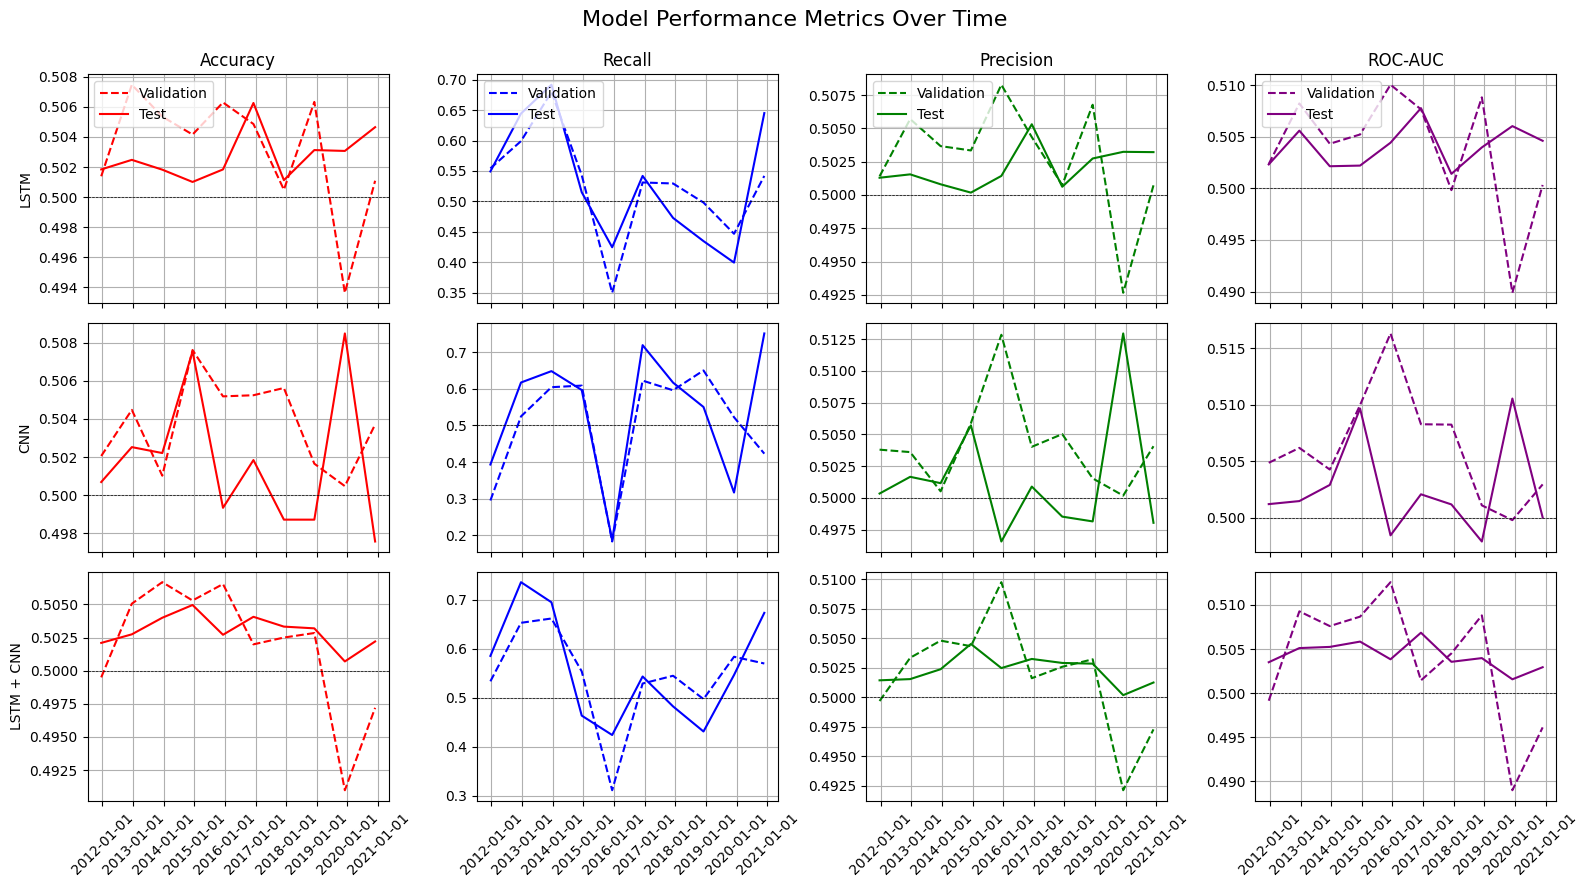

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_model_metrics(results_dict):
    """
    Plot validation vs. test curves for accuracy, recall, precision and ROC‐AUC,
    for each model in results_dict (keys are model names, values are their results lists).
    """
    metrics = ['accuracy', 'recall', 'precision', 'roc_auc']
    titles  = {'accuracy':'Accuracy', 'recall':'Recall',
               'precision':'Precision','roc_auc':'ROC‐AUC'}
    colors  = {'accuracy':'red',    'recall':'blue',
               'precision':'green', 'roc_auc':'purple'}
    date_fmt = mdates.DateFormatter('%Y-%m-%d')

    n_models = len(results_dict)
    fig, axs = plt.subplots(n_models, len(metrics),
                            figsize=(4*len(metrics), 3*n_models),
                            sharex='col')
    # ensure axs is 2D
    if n_models == 1:
        axs = axs[np.newaxis, :]

    for i, (model_name, res_list) in enumerate(results_dict.items()):
        dates = [r['test_range'][0] for r in res_list]

        for j, m in enumerate(metrics):
            ax = axs[i, j]
            val  = [r[f'val_{m}']  for r in res_list]
            test = [r[f'test_{m}'] for r in res_list]

            ax.plot(dates, val,  linestyle='--', label='Validation', color=colors[m])
            ax.plot(dates, test, label='Test',              color=colors[m])
            ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
            ax.grid(True)

            # Titles & labels
            if i == 0:
                ax.set_title(titles[m])
                ax.legend(loc='upper left')
            if j == 0:
                ax.set_ylabel(model_name)
            if i == n_models - 1:
                ax.xaxis.set_major_formatter(date_fmt)
                for lbl in ax.get_xticklabels():
                    lbl.set_rotation(45)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle('Model Performance Metrics Over Time', fontsize=16)
    plt.show()


# --- Usage ---
results_dict = {
    'LSTM':        results_LSTM,
    'CNN':         results_CNN,
    'LSTM + CNN':  results_LSTM_CNN
}
plot_model_metrics(results_dict)


metrics :

In [4]:
import numpy as np
import pandas as pd
from scipy import stats

def summarize_metrics(results, alpha=0.05):
    """
    Given a list of result‐dicts (each with keys 'test_accuracy',
    'test_recall', 'test_precision', 'test_roc_auc'), compute for each
    metric: mean, sample std dev, one‐sample t‐test p‐value vs 0.5, and
    95% confidence interval for the mean.
    """
    metrics_map = {
        'Accuracy': 'test_accuracy',
        'Recall':   'test_recall',
        'Precision':'test_precision',
        'ROC-AUC':  'test_roc_auc'
    }
    n = len(results)
    rows = []
    for metric_name, key in metrics_map.items():
        data = np.array([r[key] for r in results], dtype=float)
        mean = data.mean()
        std  = data.std(ddof=1)
        # one‐sample t‐test vs 0.5
        tstat, pval = stats.ttest_1samp(data, 0.5)
        # 95% CI for the mean
        sem    = std / np.sqrt(n)
        tcrit  = stats.t.ppf(1 - alpha/2, df=n-1)
        ci_low = mean - tcrit * sem
        ci_high= mean + tcrit * sem

        rows.append({
            'Metric':         metric_name,
            'Mean':           mean,
            'Std Dev':        std,
            'p-value vs 0.5': pval,
            '95% CI Lower':   ci_low,
            '95% CI Upper':   ci_high
        })

    df = pd.DataFrame(rows)
    # round for readability
    return df.round({
        'Mean': 4,
        'Std Dev': 4,
        'p-value vs 0.5': 4,
        '95% CI Lower': 4,
        '95% CI Upper': 4
    })

# Collect your three results
results_dict = {
    'LSTM':        results_LSTM,
    'CNN':         results_CNN,
    'LSTM + CNN':  results_LSTM_CNN
}

# Generate and print each summary table
for model_name, res in results_dict.items():
    summary_df = summarize_metrics(res)
    print(f"\n=== {model_name} ===")
    print(summary_df.to_string(index=False))



=== LSTM ===
   Metric   Mean  Std Dev  p-value vs 0.5  95% CI Lower  95% CI Upper
 Accuracy 0.5027   0.0016          0.0005        0.5015        0.5039
   Recall 0.5319   0.1021          0.3484        0.4589        0.6050
Precision 0.5020   0.0016          0.0027        0.5009        0.5032
  ROC-AUC 0.5040   0.0020          0.0002        0.5026        0.5055

=== CNN ===
   Metric   Mean  Std Dev  p-value vs 0.5  95% CI Lower  95% CI Upper
 Accuracy 0.5018   0.0037          0.1653        0.4991        0.5044
   Recall 0.5394   0.1823          0.5115        0.4090        0.6698
Precision 0.5014   0.0048          0.3814        0.4980        0.5048
  ROC-AUC 0.5026   0.0043          0.0914        0.4995        0.5056

=== LSTM + CNN ===
   Metric   Mean  Std Dev  p-value vs 0.5  95% CI Lower  95% CI Upper
 Accuracy 0.5030   0.0012          0.0000        0.5021        0.5039
   Recall 0.5579   0.1123          0.1374        0.4776        0.6382
Precision 0.5023   0.0012          0.0002  

Attach back current day return and next_day_return to the results dataframes :

___
## 5. Strategy Backtesting

In [5]:
def backtesting(results, strategy_func, trading_days = 252,  **strategy_params):

  #Accumulate all trade predictions in a single dataframe
  all_trade_predictions_df = pd.concat(
    [period['trade_predictions'] for period in results],
    ignore_index=True)

  #Pass through strategy function
  #The new dataframe gets 2 new columns
  # * ['strategy_position'] : position based on the strategy function. float between -1*leverage and 1*leverage.
  # * ['strategy_return'] : position * next_day_return.
  strategy_df = strategy_func(all_trade_predictions_df, **strategy_params)

  # ----- Compute Overall Metrics ------

  # --- Strategy metrics
  overall_mean_daily_return = strategy_df['strategy_return'].mean()
  overall_volatility_daily = strategy_df['strategy_return'].std()
  overall_annualized_return = overall_mean_daily_return * trading_days
  overall_annualized_volatility = overall_volatility_daily * np.sqrt(trading_days)
  overall_annualized_sharpe_ratio = np.sqrt(trading_days) * (overall_mean_daily_return / overall_volatility_daily) if overall_volatility_daily != 0 else 0

  # - Strategy max drawdown
  daily_ret = (
    strategy_df
    .groupby('date')['strategy_return']
    .mean()
    .sort_index())

  equity = (1 + daily_ret).cumprod()
  rolling_max = equity.cummax()
  drawdown = (equity - rolling_max) / rolling_max
  overall_max_drawdown = drawdown.min()

  # - Strategy Hit Ratio
  wins = (strategy_df['strategy_return'] > 0).sum()
  trades = (strategy_df['strategy_return'] != 0).sum()
  overall_hit_ratio = wins / trades if trades > 0 else 0

  # - Exposure metrics
  overall_long_positions = (strategy_df['strategy_position'] > 0).sum()
  overall_short_positions = (strategy_df['strategy_position'] < 0).sum()
  overall_total_positions = (strategy_df['strategy_position'] != 0).sum()
  overall_long_pct = overall_long_positions / overall_total_positions if overall_total_positions else 0

  daily = strategy_df.groupby('date')['strategy_position']
  daily_net   = daily.sum()           # sum of signed weights each day
  daily_gross = daily.apply(lambda x: x.abs().sum())

  overall_avg_net_exposure   = daily_net.mean()
  overall_avg_gross_exposure = daily_gross.mean()

  # --- Benchmark metrics
  benchmark_mean_daily_return = strategy_df['next_day_return'].mean()
  benchmark_volatility_daily = strategy_df['next_day_return'].std()
  benchmark_annualized_return = benchmark_mean_daily_return * trading_days
  benchmark_annualized_volatility = benchmark_volatility_daily * np.sqrt(trading_days)
  benchmark_annualized_sharpe_ratio = np.sqrt(trading_days) * (benchmark_mean_daily_return / benchmark_volatility_daily) if benchmark_volatility_daily != 0 else 0

  # - Benchmark max drawdown
  daily_ret = (
    strategy_df
    .groupby('date')['next_day_return']
    .mean()
    .sort_index())

  equity = (1 + daily_ret).cumprod()
  rolling_max = equity.cummax()
  drawdown = (equity - rolling_max) / rolling_max
  benchmark_max_drawdown = drawdown.min()

  # - Benchmark Hit Ratio
  wins = (strategy_df['next_day_return'] > 0).sum()
  trades = (strategy_df['next_day_return'] != 0).sum()
  benchmark_hit_ratio = wins / trades if trades > 0 else 0

  benchmark_backtest_results = {
    'overall mean daily return': f'{benchmark_mean_daily_return * 100:.4f}%',
    'overall volatility daily': f'{benchmark_volatility_daily * 100:.4f}%',
    'overall annualized return': f'{benchmark_annualized_return * 100:.2f}%',
    'overall annualized volatility': f'{benchmark_annualized_volatility * 100:.2f}%',
    'overall max drawdown': f'{benchmark_max_drawdown * 100:.2f}%',
    'overall sharpe ratio': benchmark_annualized_sharpe_ratio,
    'overall hit ratio': f'{benchmark_hit_ratio * 100:.2f}%',
    'overall average net exposure': np.nan,
    'overall average gross exposure': np.nan,
    'overall total positions': np.nan,
    'overall long %': np.nan
      }

  strategy_backtest_results = {
    'overall mean daily return': f'{overall_mean_daily_return * 100:.4f}%',
    'overall volatility daily': f'{overall_volatility_daily * 100:.4f}%',
    'overall annualized return': f'{overall_annualized_return * 100:.2f}%',
    'overall annualized volatility': f'{overall_annualized_volatility * 100:.2f}%',
    'overall max drawdown': f'{overall_max_drawdown * 100:.2f}%',
    'overall sharpe ratio': overall_annualized_sharpe_ratio,
    'overall hit ratio': f'{overall_hit_ratio * 100:.2f}%',
    'overall average net exposure': f'{overall_avg_net_exposure:.2f}',
    'overall average gross exposure': f'{overall_avg_gross_exposure:.2f}',
    'overall total positions': f'{overall_total_positions:.0f}',
    'overall long %': f'{overall_long_pct * 100:.2f}%'
      }

  backtest_results_df = pd.DataFrame([benchmark_backtest_results, strategy_backtest_results], index=['Benchmark', 'Strategy'])
  backtest_results_df = backtest_results_df.T

  # Compute cumulative strategy returns and benchmark returns
  pivot_strategy_df = strategy_df.pivot(index='date', columns='permno', values='strategy_return')
  pivot_benchmark_df = strategy_df.pivot(index='date', columns='permno', values='next_day_return')

  avg_strategy_daily = pivot_strategy_df.mean(axis=1)
  avg_benchmark_daily = pivot_benchmark_df.mean(axis=1)

  cum_strategy_returns  = (1 + avg_strategy_daily).cumprod()  - 1
  cum_benchmark_returns = (1 + avg_benchmark_daily).cumprod() - 1

  # plot cumulative strategy returns and benchmark returns
  plt.figure(figsize=(8,4))
  plt.plot(cum_strategy_returns,  label='Strategy')
  plt.plot(cum_benchmark_returns, label='Benchmark', color = 'red', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.title('Strategy vs. Benchmark Cumulative Returns')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # ----- Compute Per-period metrics ------

  start_dates = []

  strat_mean_daily_returns = []
  strat_volatilities = []
  strat_sharpe_ratios = []
  strat_max_drawdown = []
  strat_hit_ratio = []
  strat_long_positions = []
  strat_short_positions = []
  strat_total_positions = []
  strat_avg_net_exposure = []
  strat_avg_gross_exposure = []

  bench_mean_daily_returns = []
  bench_volatilities = []
  bench_sharpe_ratios = []
  bench_max_drawdown = []
  bench_hit_ratio = []

  for period in results:

    #Period slicing
    period_dates = period['test_range']
    period_df = strategy_df.loc[(strategy_df['date'] >= period_dates[0]) & (strategy_df['date'] <= period_dates[1])]

    #Compute per period metrics and append
    start_dates.append(period_dates[0])

    # --- Strategy Metrics
    strat_mean_daily_returns.append(period_df['strategy_return'].mean())
    strat_volatilities.append(period_df['strategy_return'].std())
    strat_sharpe_ratios.append(np.sqrt(trading_days) * (period_df['strategy_return'].mean() / period_df['strategy_return'].std()) if period_df['strategy_return'].std() != 0 else 0)

    # - Strategy Max Drawdown
    daily_ret = (
      period_df
      .groupby('date')['strategy_return']
      .mean()
      .sort_index())

    equity = (1 + daily_ret).cumprod()
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max
    strat_max_drawdown.append(drawdown.min())

    # - Strategy Hit Ratio
    wins = (period_df['strategy_return'] > 0).sum()
    trades = (period_df['strategy_return'] != 0).sum()
    strat_hit_ratio.append(wins / trades if trades > 0 else 0)

    # - Strategy long/short positions
    strat_long_positions.append((period_df['strategy_position'] > 0).sum())
    strat_short_positions.append((period_df['strategy_position'] < 0).sum())
    strat_total_positions.append((period_df['strategy_position'] != 0).sum())

    # - Exposure Metrics

    daily = period_df.groupby('date')['strategy_position']
    daily_net   = daily.sum()           # sum of signed weights each day
    daily_gross = daily.apply(lambda x: x.abs().sum())

    strat_avg_net_exposure.append(daily_net.mean())
    strat_avg_gross_exposure.append(daily_gross.mean())

    # --- Benchmark Metrics
    bench_mean_daily_returns.append(period_df['next_day_return'].mean())
    bench_volatilities.append(period_df['next_day_return'].std())
    bench_sharpe_ratios.append(np.sqrt(trading_days) * (period_df['next_day_return'].mean() / period_df['next_day_return'].std()) if period_df['next_day_return'].std() != 0 else 0)

    # - Benchmark Max Drawdown
    daily_ret = (
      period_df
      .groupby('date')['next_day_return']
      .mean()
      .sort_index())

    equity = (1 + daily_ret).cumprod()
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max
    bench_max_drawdown.append(drawdown.min())

    # - Benchmark Hit ratio
    wins = (period_df['next_day_return'] > 0).sum()
    trades = (period_df['next_day_return'] != 0).sum()
    bench_hit_ratio.append(wins / trades if trades > 0 else 0)

  # ----- Plot metrics ------

  #Plot per period mean daily returns
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_mean_daily_returns, label='Strategy')
  plt.plot(start_dates, bench_mean_daily_returns, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Mean daily Return')
  plt.title('Mean daily Return per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period volatility
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_volatilities, label='Strategy')
  plt.plot(start_dates, bench_volatilities, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Volatility')
  plt.title('Volatility per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period max drawdown
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_max_drawdown, label='Strategy')
  plt.plot(start_dates, bench_max_drawdown, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Max Drawdown')
  plt.title('Max Drawdown per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period Hit Ratio
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_hit_ratio, label='Strategy')
  plt.plot(start_dates, bench_hit_ratio, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Hit Ratio')
  plt.title('Hit Ratio per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Stackplot of the long and short positions.
  plt.figure(figsize=(7,4))
  plt.stackplot(
      start_dates,
      strat_long_positions,
      strat_short_positions,
      labels=['Long positions', 'Short positions'],
      colors=['green', 'red'],
      alpha=0.3
  )
  plt.xlabel('Period')
  plt.ylabel('Number of Positions')
  plt.title('Long vs. Short Positions per Period (Stacked)')
  plt.legend(loc='upper left')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # Exposure Metrics
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_avg_net_exposure, label='average net exposure')
  plt.plot(start_dates, strat_avg_gross_exposure, label='average gross exposure')
  plt.xlabel('Period')
  plt.ylabel('Exposure')
  plt.title('Exposure per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period sharpe
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_sharpe_ratios, label='Strategy')
  plt.plot(start_dates, bench_sharpe_ratios, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Sharpe Ratio')
  plt.title('Annualized Sharpe Ratio per Period')
  plt.grid(True)
  plt.legend()
  plt.show()


  return backtest_results_df

### 5.1 Binary Classification Trading

The first obvious strategy is to go long the stocks where the prediction is above 0.5 + a theshold and go short the stocks where the prediction is 0.5 - a threshold.

most of the papers on the subject use a threshold of 0 to fully demonstrate the strength (or weakness) of an algorithm.

We create a function that computes the positions as a dataframe consiting of -1, 0s and 1s (respectively representing 'SELL' 'HOLD' and 'BUY') based on the aforementioned rules and then computes the returns via simple multiplication.

Here the threshold is called 'K'

In [6]:
def binary_strategy_performance(trade_predictions_df, K=0.00, leverage=1, LongOnly=False):
    #Copy to avoid modifying original
    df = trade_predictions_df.copy()

    # 2) Build the position logic
    if LongOnly:
        # only long vs. flat
        df['strategy_position'] = np.where(
          df['prediction_proba'] > 0.5 + K,
            1 * leverage,
            0
        )
    else:
        # long vs. short vs. flat
        df['strategy_position'] = np.where(
            df['prediction_proba'] > 0.5 + K,
            1 * leverage,
            np.where(
                df['prediction_proba'] < 0.5 - K,
                -1 * leverage,
                0
            )
        )

    # 3) Compute strategy returns
    df['strategy_return'] = df['strategy_position'] * df['next_day_return']

    return df

We then loop that function over every period of our dataset and plot it to see how our trading strategy performed.

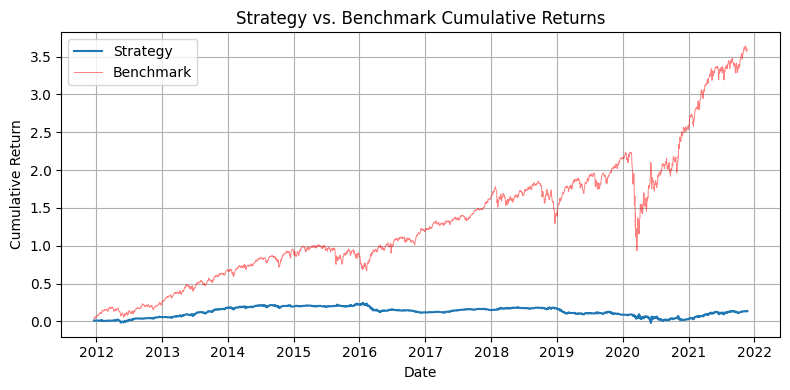

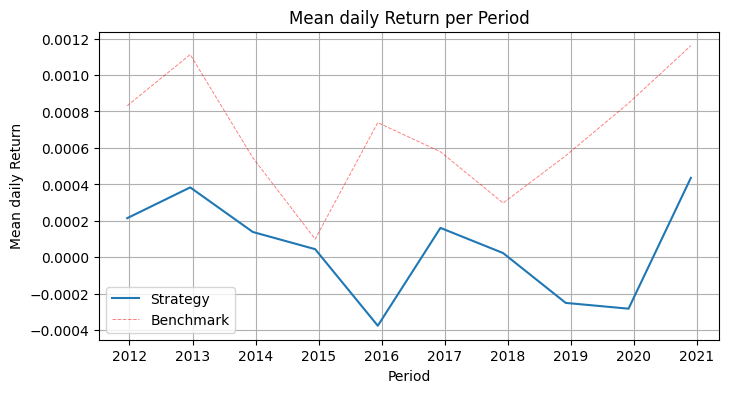

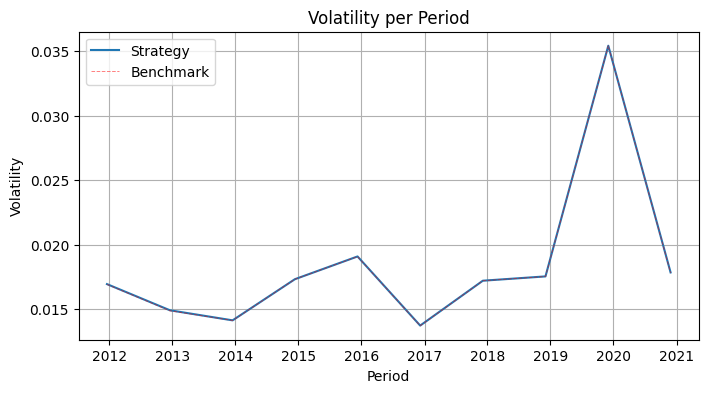

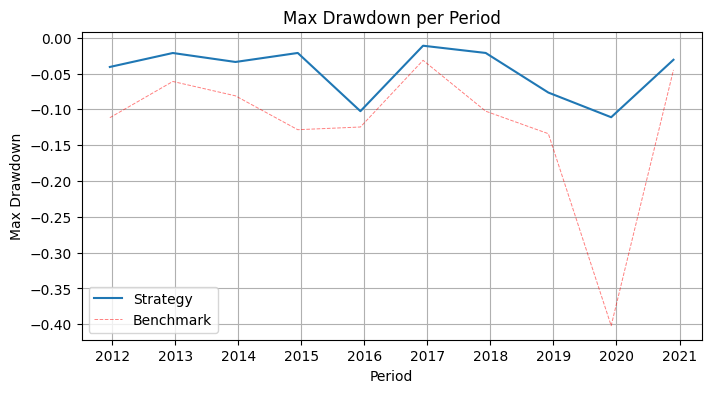

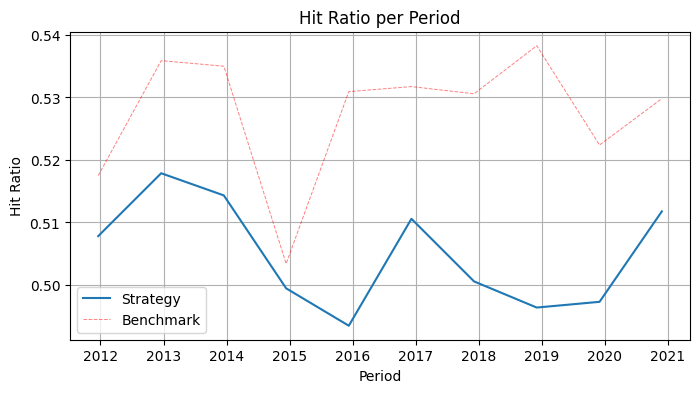

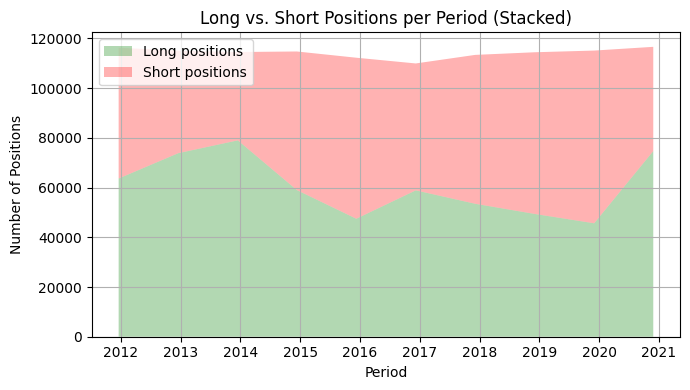

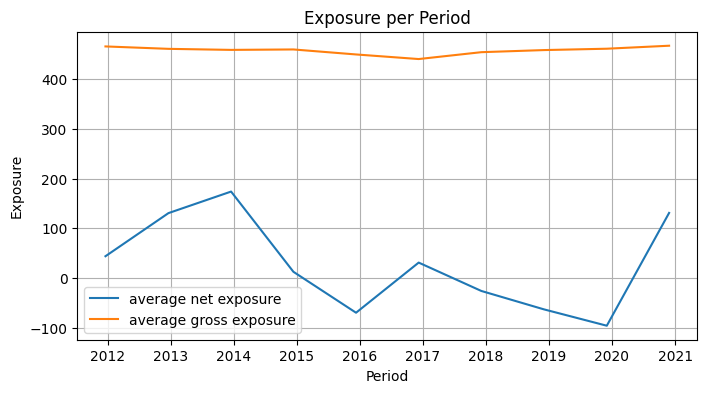

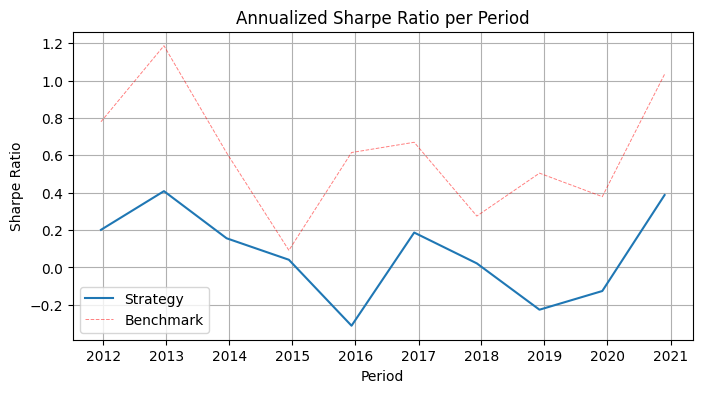

Benchmark  Strategy
overall mean daily return        0.0679%   0.0051%
overall volatility daily         1.9347%   1.9358%
overall annualized return         17.10%     1.28%
overall annualized volatility     30.71%    30.73%
overall max drawdown             -40.21%   -21.04%
overall sharpe ratio            0.556863  0.041807
overall hit ratio                 52.75%    50.50%
overall average net exposure         NaN     27.09
overall average gross exposure       NaN    456.97
overall total positions              NaN   1142415
overall long %                       NaN    52.96%

In [7]:
binary_strategy_metrics = backtesting(results_LSTM, binary_strategy_performance, K=0.00, leverage=1, LongOnly=False)
binary_strategy_metrics

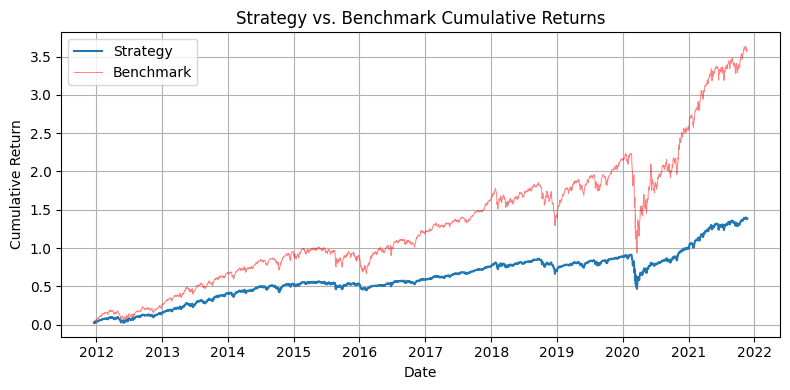

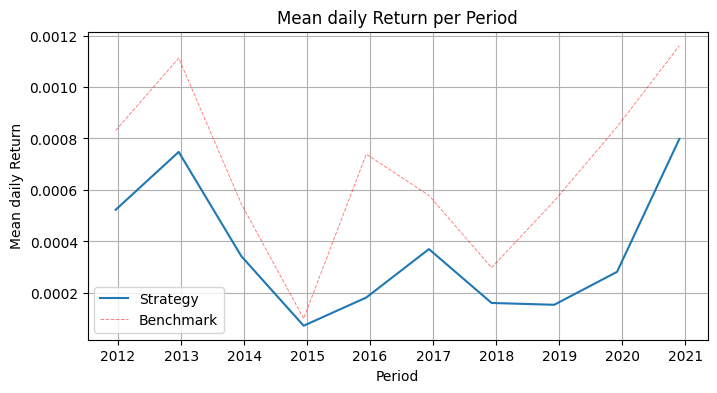

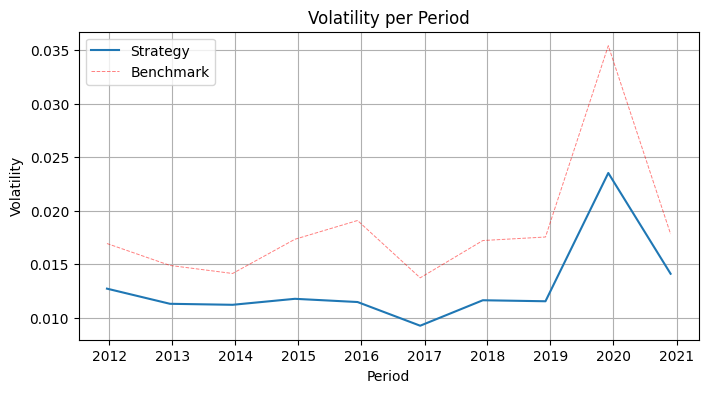

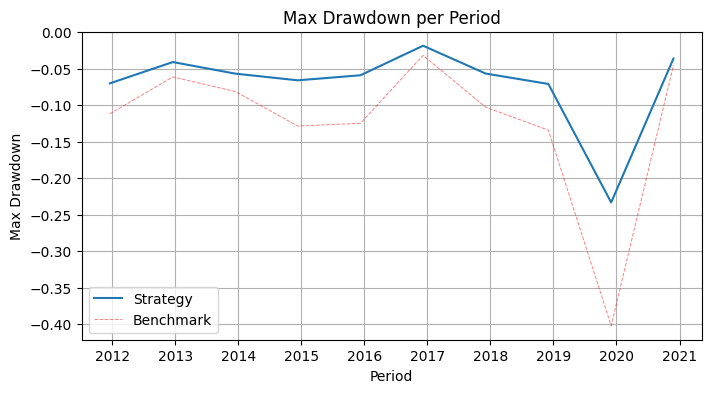

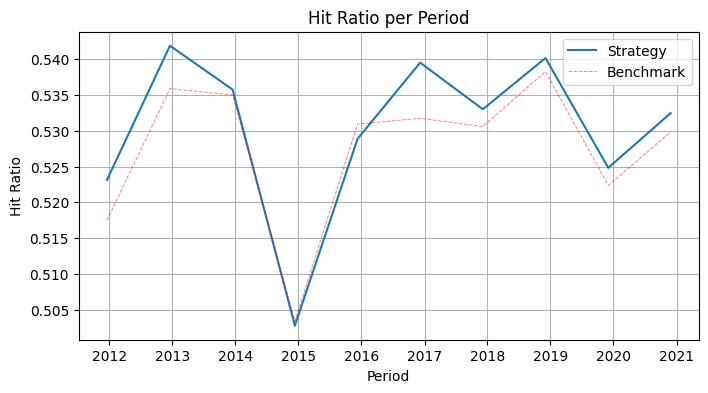

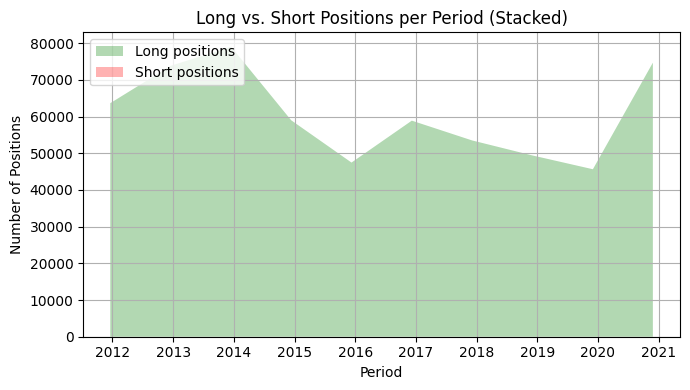

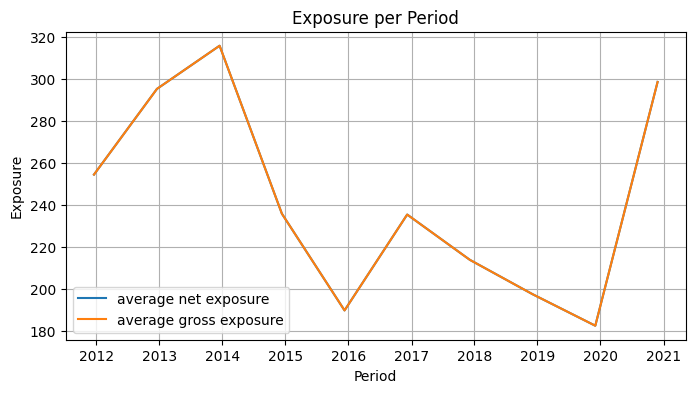

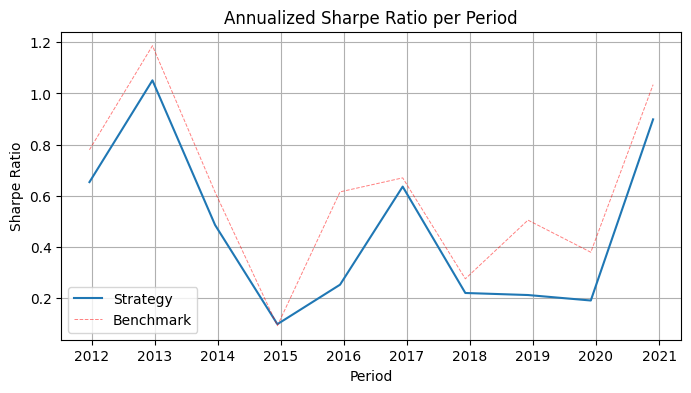

Benchmark  Strategy
overall mean daily return        0.0679%   0.0365%
overall volatility daily         1.9347%   1.3402%
overall annualized return         17.10%     9.19%
overall annualized volatility     30.71%    21.27%
overall max drawdown             -40.21%   -23.32%
overall sharpe ratio            0.556863  0.432139
overall hit ratio                 52.75%    53.07%
overall average net exposure         NaN    242.03
overall average gross exposure       NaN    242.03
overall total positions              NaN    605068
overall long %                       NaN   100.00%

In [8]:
binary_strategy_metrics = backtesting(results_LSTM, binary_strategy_performance, K=0.00, leverage=1, LongOnly=True)
binary_strategy_metrics

### 5.2 Continuous Transformation strategies

An other approach that might be worth exploring is to apply a mapping to the prediction. In other terms, mapping the prediction that are bewteen 0 and 1 onto the positions (between -1 and 1) using a particular function.

To make more clear what that means, lets consider an example that we will backtest. Lets say the prediction for stock ABC is 1, then we go long, 0.5, we hold and 0 we go short. What happens in between those is what we are interested in. We could imagine mapping $[0,1]$ to $[-1,1]$ linearly using the function $f(x) = 2x - 1$.

But in reality, we could use any function that maps properly those segments together.

Below is a list of several mappings that might make sense along with their corresponding functions:

- **Linear Mapping**  
  This is the simplest mapping, where the transformation is linear:
  $$
  f(x) = 2x - 1
  $$
  More generally, for mapping an interval $[a,b]$ to $[-1,1]$, you can use:
  $$
  f(x) = \frac{2(x-a)}{b-a} - 1
  $$

- **Sinusoidal Mapping (Using Sine)**  
  This provides a smooth "S-curve" transformation:
  $$
  f(x) = \sin\left(\pi\left(x - \frac{1}{2}\right)\right)
  $$

- **Cosine-Based Mapping**  
  Another smooth mapping using cosine:
  $$
  f(x) = -\cos(\pi x)
  $$

- **Logistic Sigmoid Mapping**  
  A logistic sigmoid function modified to map the interval $[0,1]$ onto $[-1,1]$. Here, $k$ is a parameter controlling the steepness:
  $$
  f(x) = \frac{2}{1 + e^{-k\left(x-\frac{1}{2}\right)}} - 1
  $$

- **Hyperbolic Tangent Mapping**  
  Using the hyperbolic tangent, which naturally has an output range of $[-1, 1]$. Again, $k$ controls the steepness:
  $$
  f(x) = \tanh\left(k\left(x-\frac{1}{2}\right)\right)
  $$

- **Power Law Mapping (Generalized Non-Linear Mapping)**  
  Here, $\gamma$ is a parameter that introduces curvature. The linear mapping is recovered when $\gamma=1$:
  $$
  f(x) = 2x^\gamma - 1
  $$


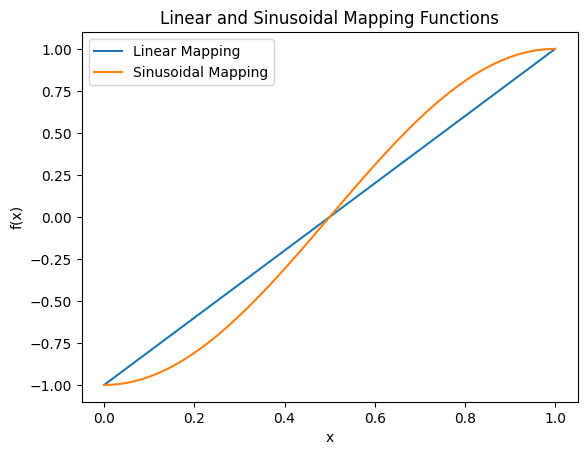

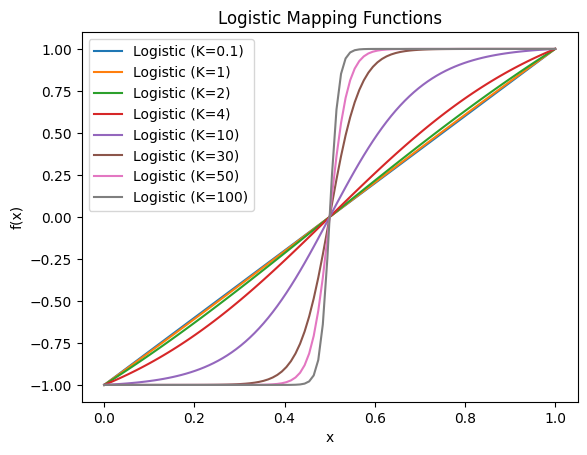

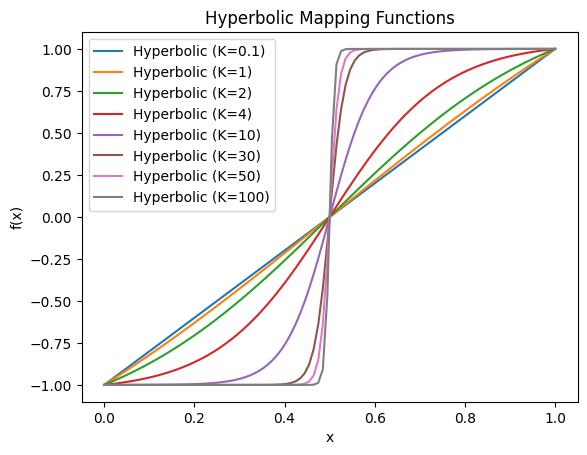

In [9]:
def linear_mapping(x, K = None):
    # Linear mapping: f(x) = 2x - 1
    return 2 * x - 1

def sinusoidal_mapping(x, K=None):
    # Sinusoidal mapping: f(x) = sin(π(x - 1/2))
    return np.sin(np.pi * (x - 0.5))

def logistic_mapping(x, K=1):
    # Logistic sigmoid function:
    S = 1 / (1 + np.exp(-K * (x - 0.5)))
    # Compute endpoint values:
    S0 = 1 / (1 + np.exp( K/2))   # S(0)
    S1 = 1 / (1 + np.exp(-K/2))    # S(1)
    # Affine transformation to force S(0) -> -1 and S(1) -> 1:
    return 2 * (S - S0) / (S1 - S0) - 1

def hyperbolic_mapping(x, K=1):
    # The unscaled function value:
    T = np.tanh(0.5 * K)
    # Scale so that at x=0, tanh(-0.5*K) = -T becomes -1 and at x=1, tanh(0.5*K) = T becomes 1:
    return np.tanh(K * (x - 0.5)) / T

# Generate 100 points between 0 and 1.
x = np.linspace(0, 1, 100)

# Plot Linear and Sinusoidal Mappings
plt.figure()
plt.plot(x, linear_mapping(x), label='Linear Mapping')
plt.plot(x, sinusoidal_mapping(x), label='Sinusoidal Mapping')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Linear and Sinusoidal Mapping Functions')
plt.legend()
plt.show()


# Plot Strict Logistic Mappings for various K values
K_values = [0.1, 1, 2, 4, 10, 30, 50, 100]
plt.figure()
for K in K_values:
    plt.plot(x, logistic_mapping(x, K), label=f'Logistic (K={K})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Logistic Mapping Functions')
plt.legend()
plt.show()

# Plot Strict Hyperbolic Mappings for various K values
plt.figure()
for K in K_values:
    plt.plot(x, hyperbolic_mapping(x, K), label=f'Hyperbolic (K={K})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Hyperbolic Mapping Functions')
plt.legend()
plt.show()


As we can see, the edge cases are:   

- a linear mapping if k is very small
- a step function at $x = 0.5$ , which is equivalent to our binary trading algorithm.

all of those functions are stricly ascending, so the rankings won't be affected. We won't use those functions in conjunction with the Long/Short or Long only solutions because they involve a ranking that wouldn't be changed.

In [10]:
def convolution_strategy_performance(trade_predictions_df, leverage=1, convolution=None, K=None, LongOnly = False):

  #Create a copy to avoid dataframe issues
  df = trade_predictions_df.copy()

  #Create positions
  df['strategy_position'] = convolution(df['prediction_proba'], K) * leverage

  #Apply long only filter
  if LongOnly:
    df['strategy_position'] = df['strategy_position'].clip(lower=0)

  #Compute returns
  df['strategy_return'] = df['strategy_position'] * df['next_day_return']

  return df

Linear convolution and it's long only counterpart :

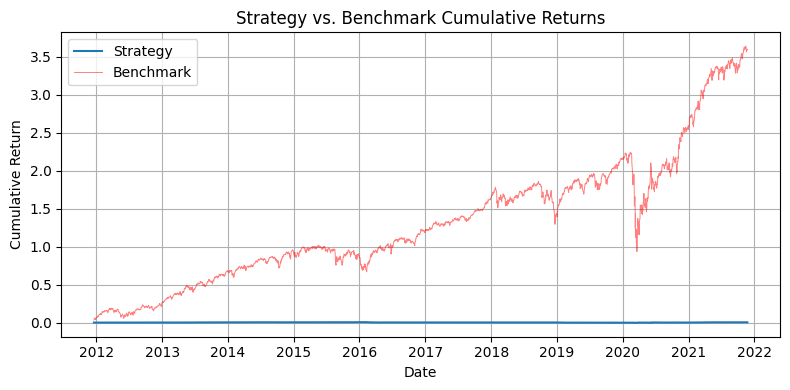

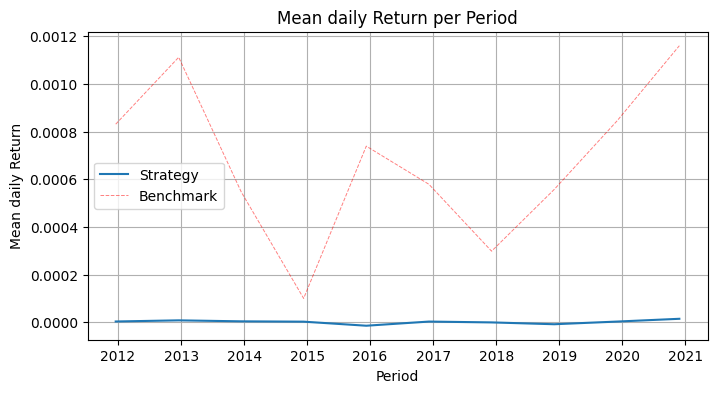

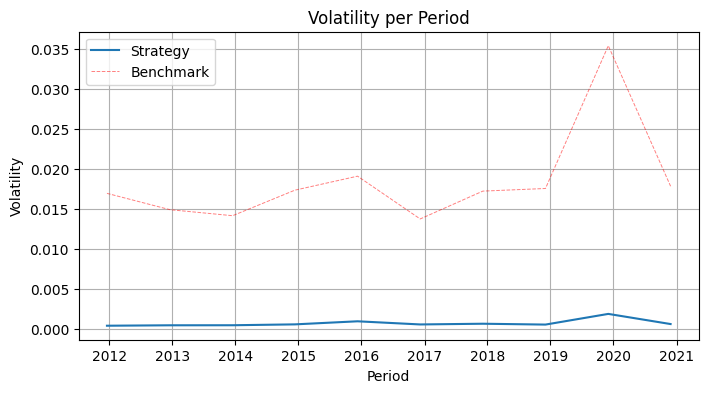

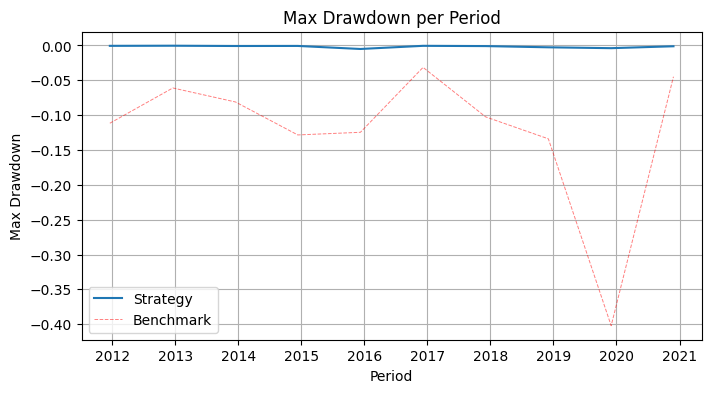

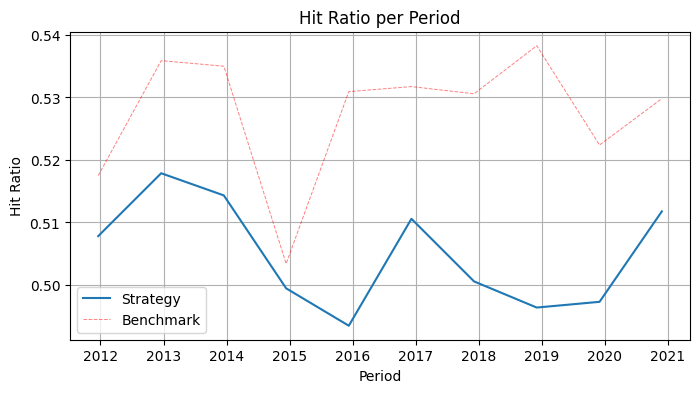

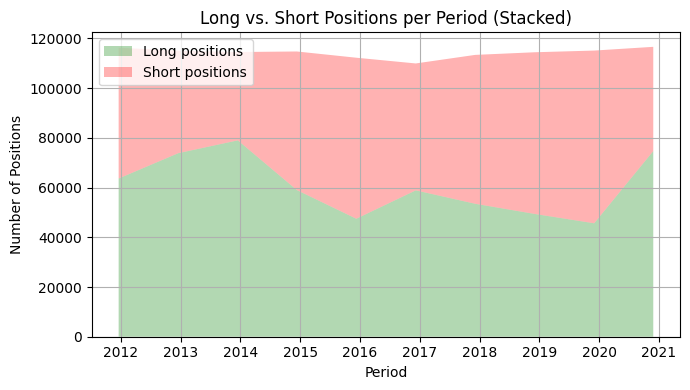

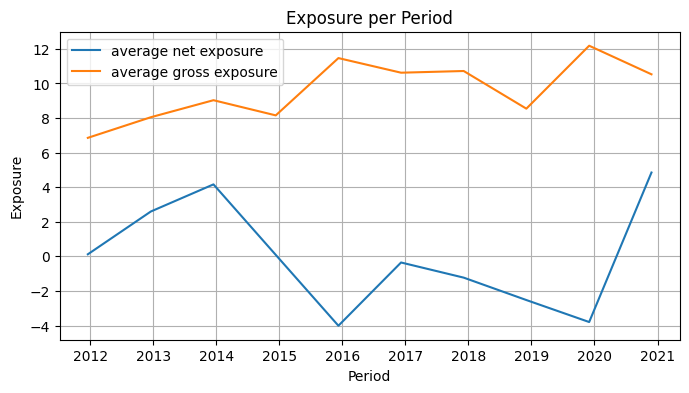

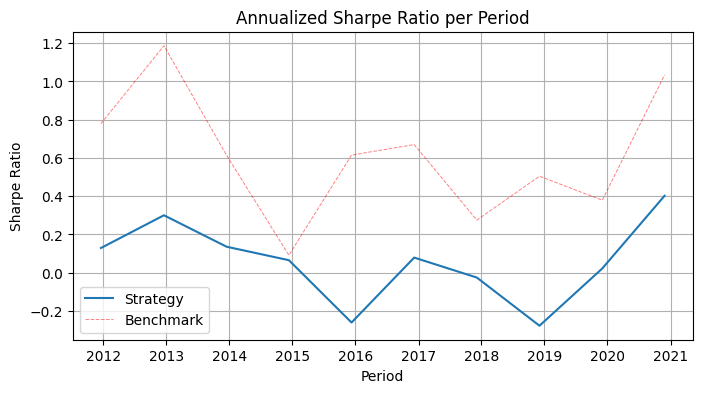

Benchmark  Strategy
overall mean daily return        0.0679%   0.0001%
overall volatility daily         1.9347%   0.0781%
overall annualized return         17.10%     0.03%
overall annualized volatility     30.71%     1.24%
overall max drawdown             -40.21%    -1.00%
overall sharpe ratio            0.556863  0.023723
overall hit ratio                 52.75%    50.50%
overall average net exposure         NaN     -0.01
overall average gross exposure       NaN      9.61
overall total positions              NaN   1142415
overall long %                       NaN    52.96%

In [11]:
conv_linear_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = linear_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=False)
conv_linear_strategy_metrics

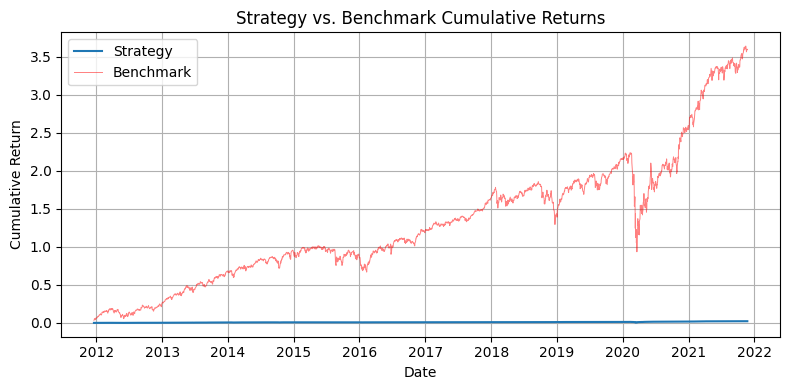

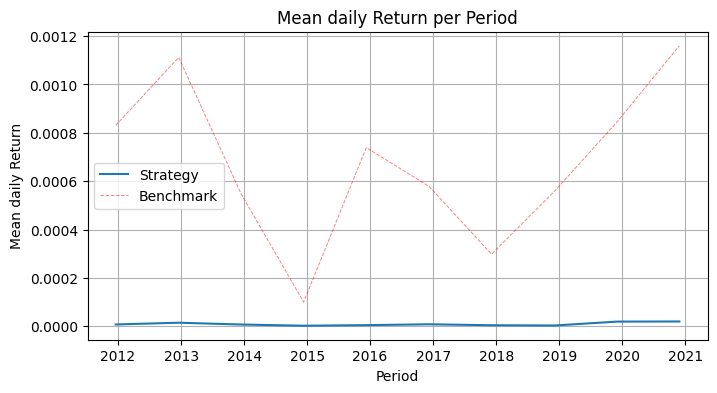

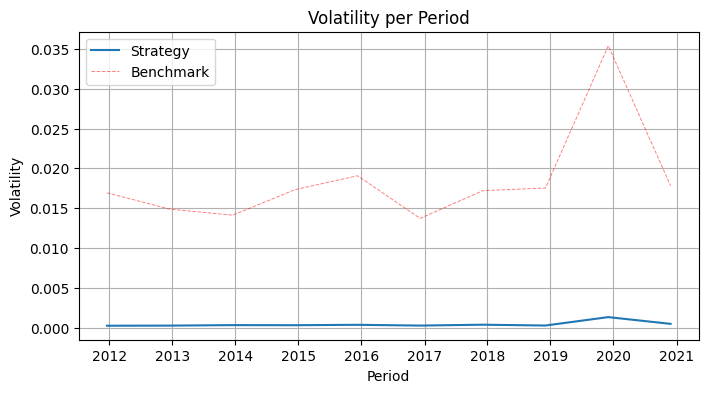

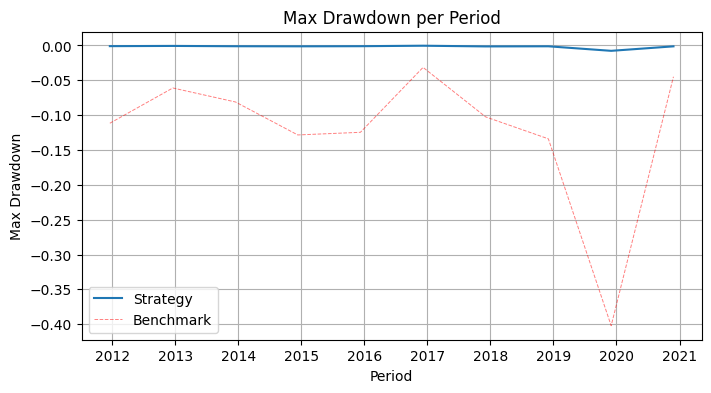

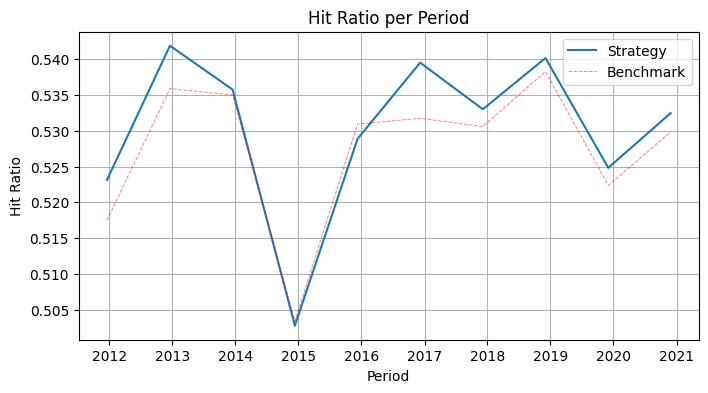

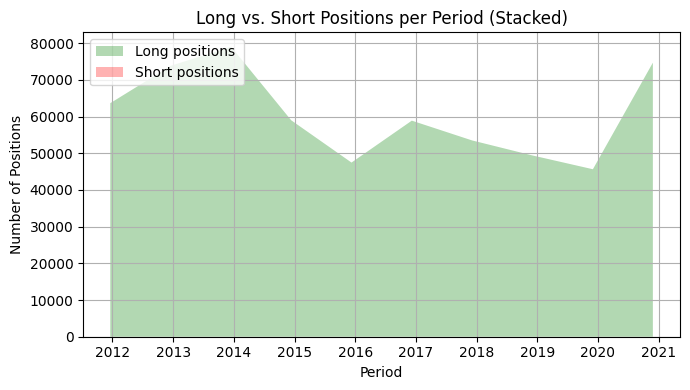

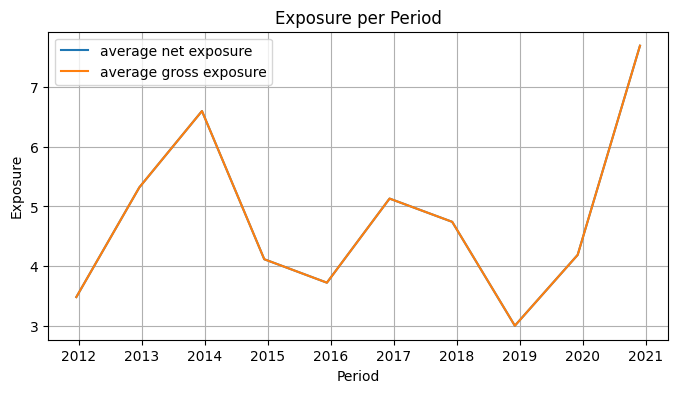

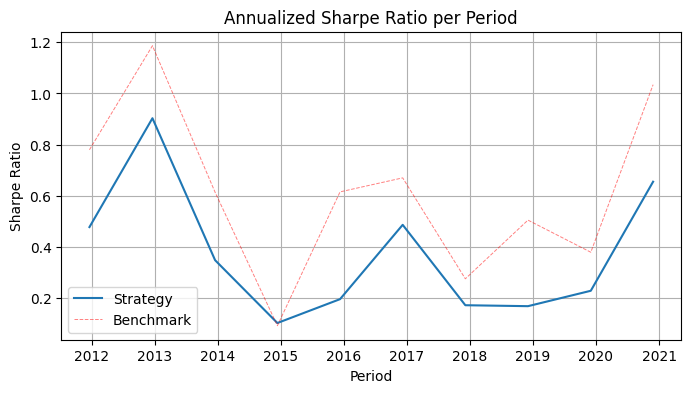

Benchmark  Strategy
overall mean daily return        0.0679%   0.0009%
overall volatility daily         1.9347%   0.0519%
overall annualized return         17.10%     0.22%
overall annualized volatility     30.71%     0.82%
overall max drawdown             -40.21%    -0.78%
overall sharpe ratio            0.556863  0.270382
overall hit ratio                 52.75%    53.07%
overall average net exposure         NaN      4.80
overall average gross exposure       NaN      4.80
overall total positions              NaN    605068
overall long %                       NaN   100.00%

In [12]:
conv_linear_LO_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = linear_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=True)
conv_linear_LO_strategy_metrics

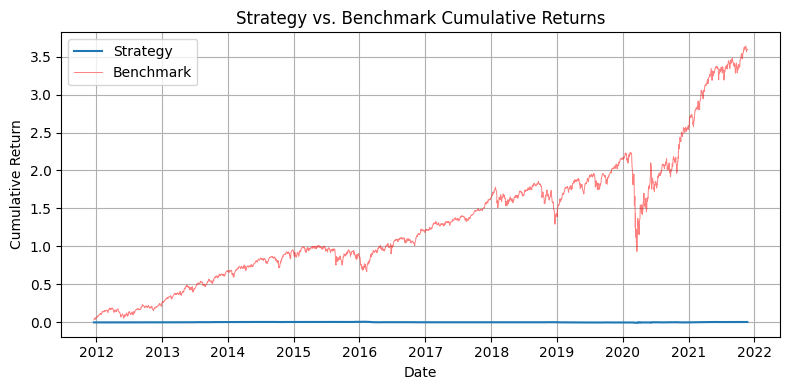

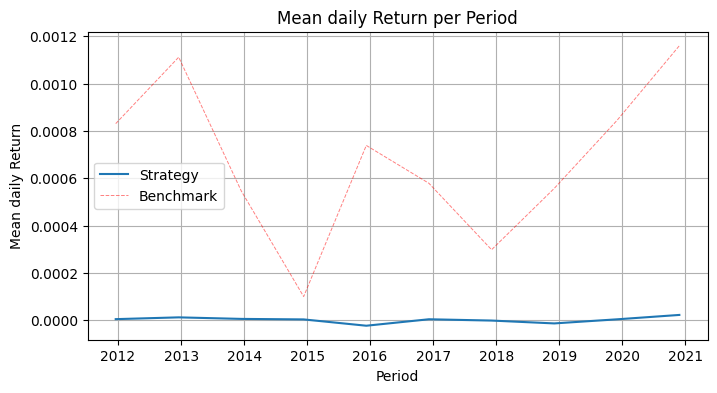

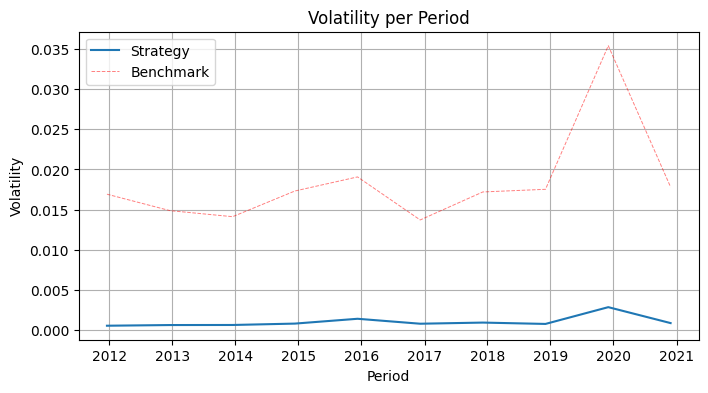

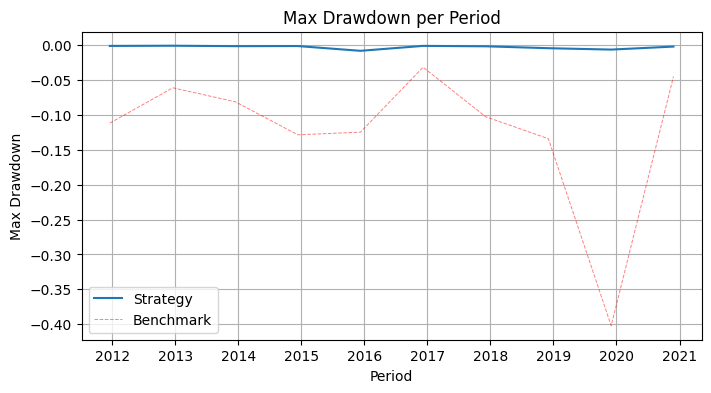

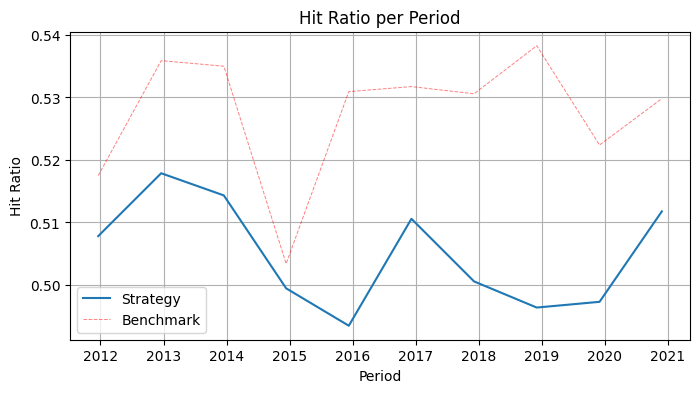

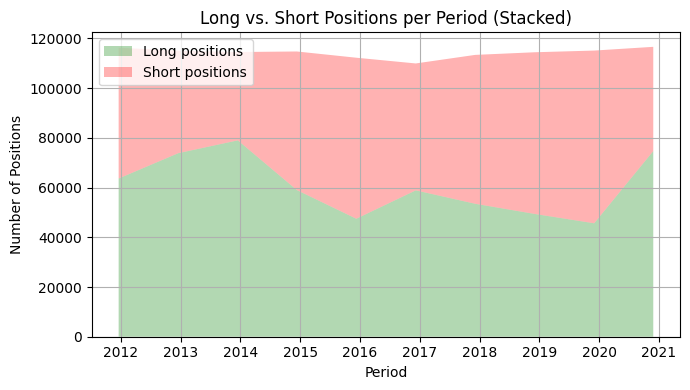

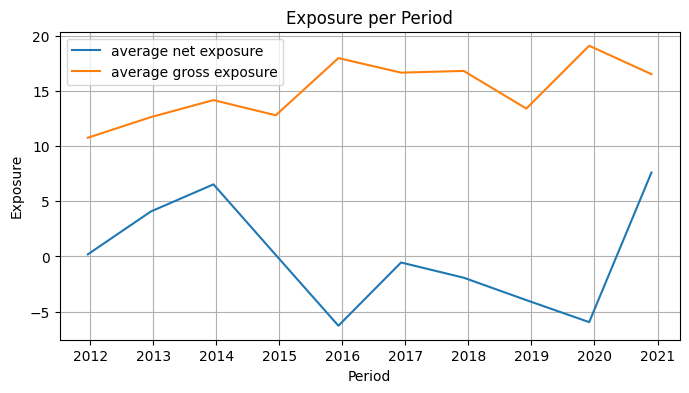

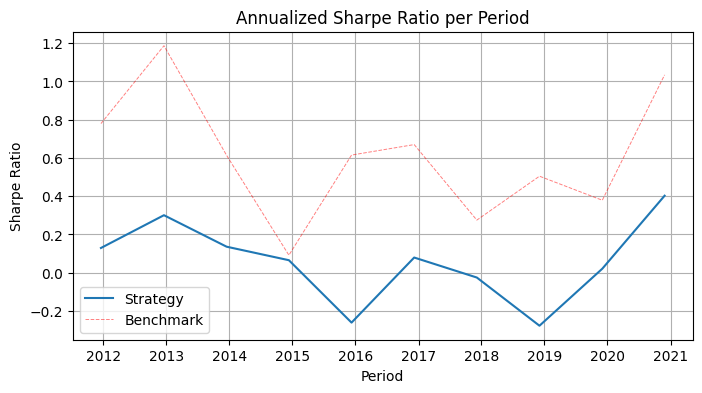

Benchmark Strategy
overall mean daily return        0.0679%  0.0002%
overall volatility daily         1.9347%  0.1222%
overall annualized return         17.10%    0.05%
overall annualized volatility     30.71%    1.94%
overall max drawdown             -40.21%   -1.56%
overall sharpe ratio            0.556863   0.0236
overall hit ratio                 52.75%   50.50%
overall average net exposure         NaN    -0.01
overall average gross exposure       NaN    15.08
overall total positions              NaN  1142415
overall long %                       NaN   52.96%

In [13]:
conv_sin_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = sinusoidal_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=False)
conv_sin_strategy_metrics

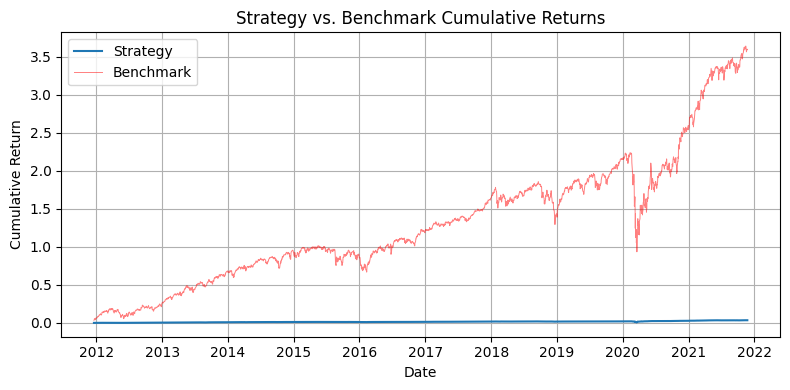

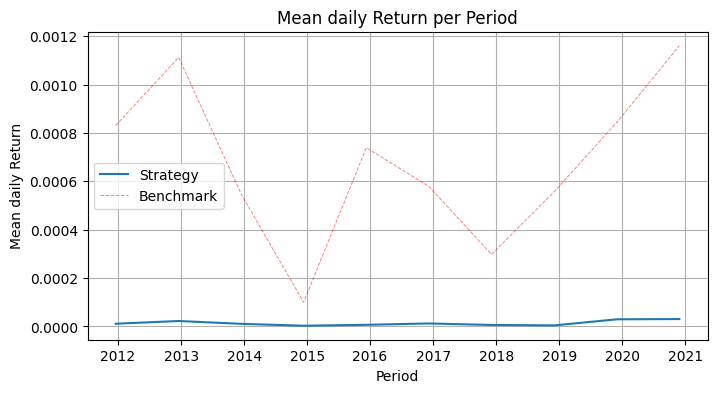

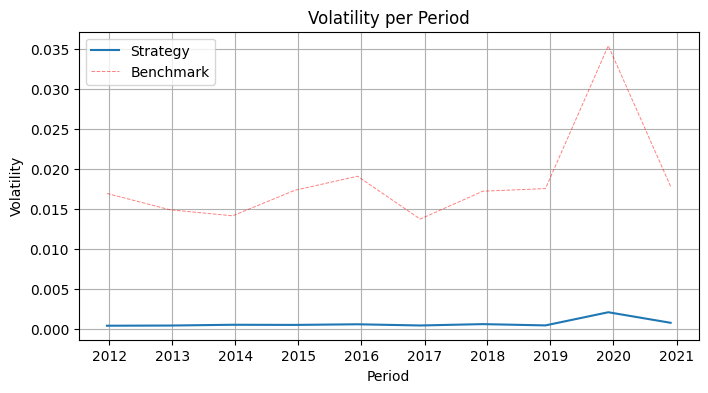

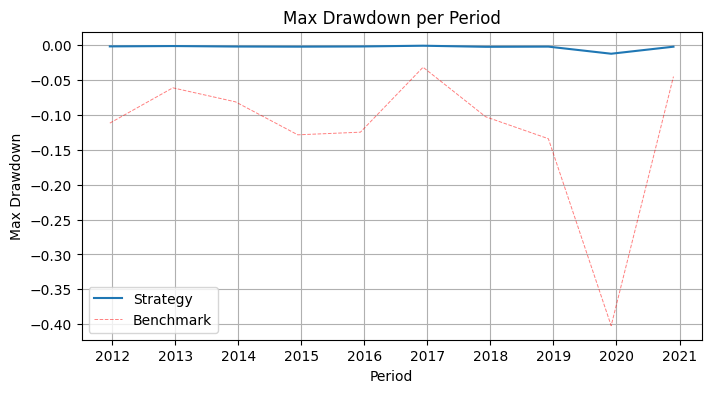

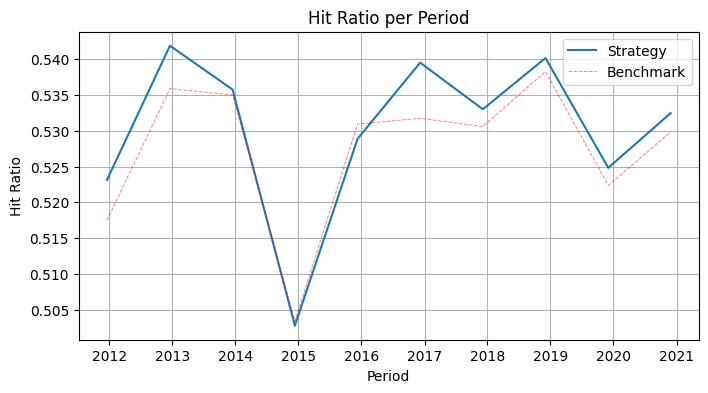

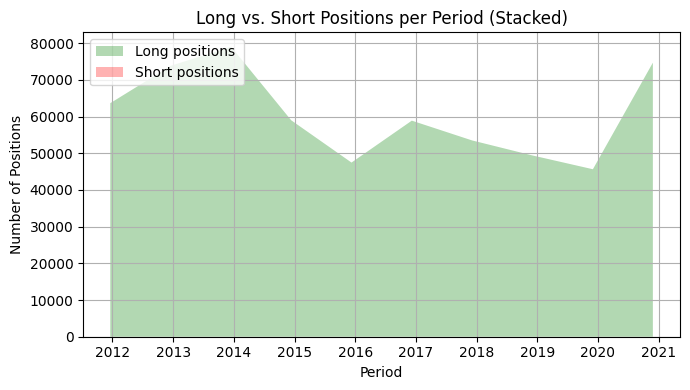

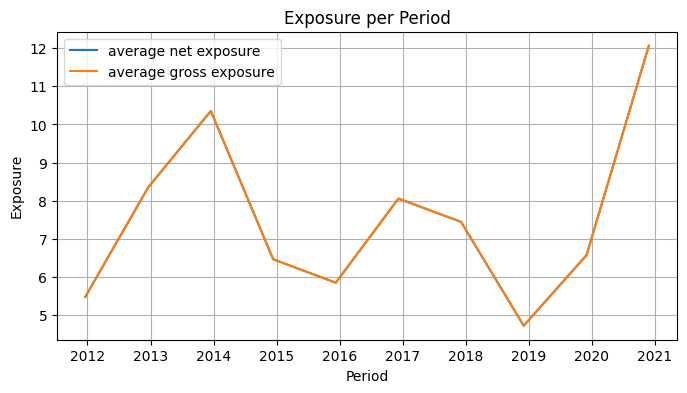

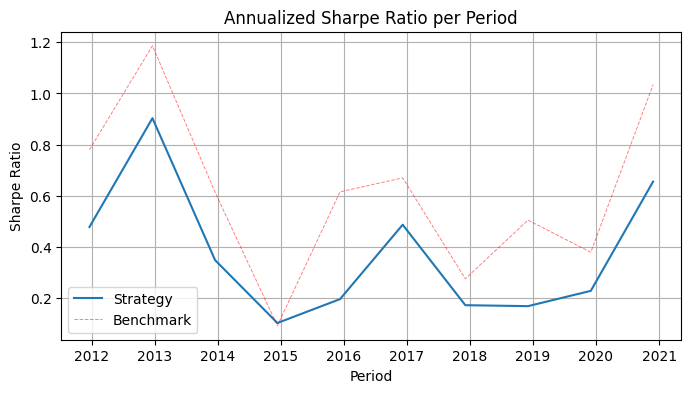

Benchmark  Strategy
overall mean daily return        0.0679%   0.0014%
overall volatility daily         1.9347%   0.0811%
overall annualized return         17.10%     0.35%
overall annualized volatility     30.71%     1.29%
overall max drawdown             -40.21%    -1.22%
overall sharpe ratio            0.556863  0.271081
overall hit ratio                 52.75%    53.07%
overall average net exposure         NaN      7.53
overall average gross exposure       NaN      7.53
overall total positions              NaN    605068
overall long %                       NaN   100.00%

In [14]:
conv_sin_LO_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = sinusoidal_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=True)
conv_sin_LO_strategy_metrics

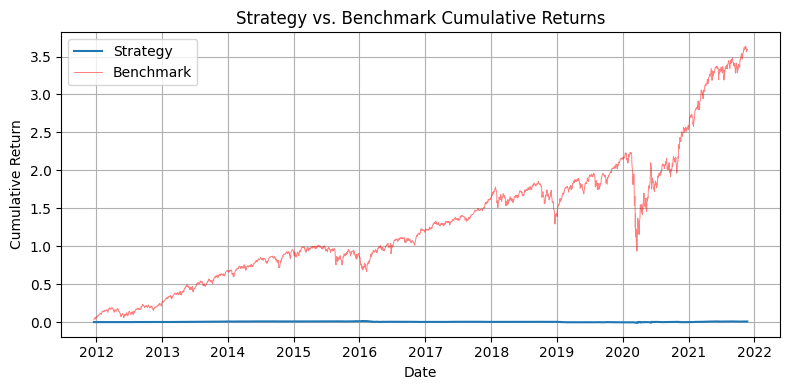

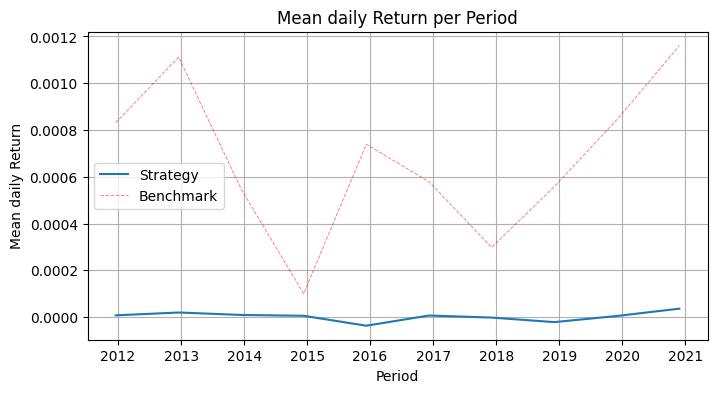

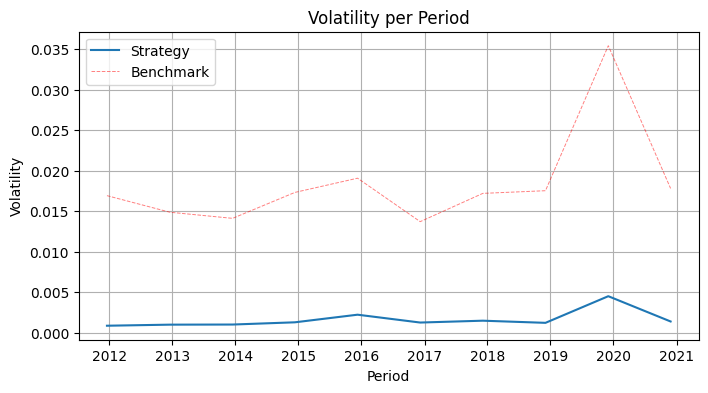

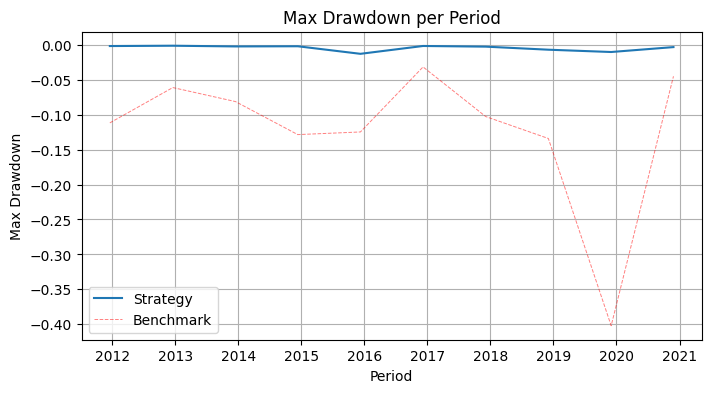

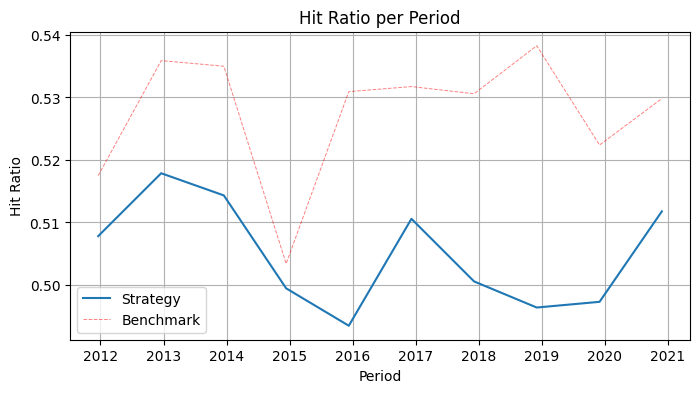

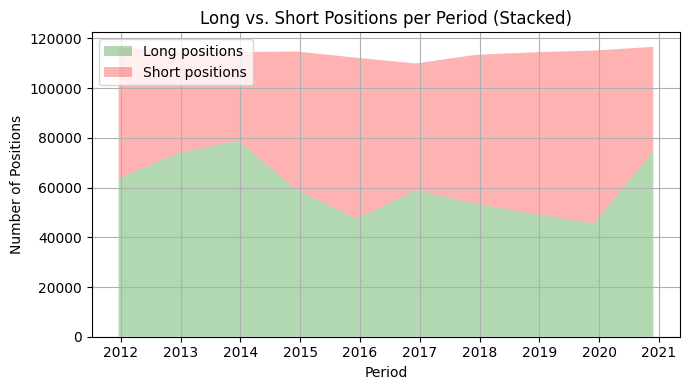

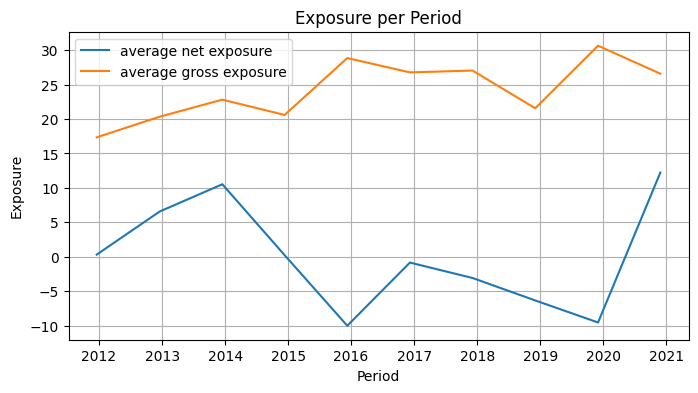

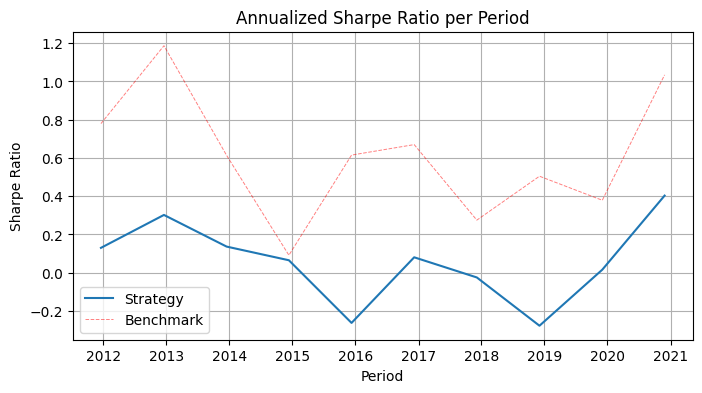

Benchmark  Strategy
overall mean daily return        0.0679%   0.0003%
overall volatility daily         1.9347%   0.1942%
overall annualized return         17.10%     0.07%
overall annualized volatility     30.71%     3.08%
overall max drawdown             -40.21%    -2.48%
overall sharpe ratio            0.556863  0.023145
overall hit ratio                 52.75%    50.50%
overall average net exposure         NaN      0.00
overall average gross exposure       NaN     24.24
overall total positions              NaN   1142416
overall long %                       NaN    52.96%

In [15]:
conv_log_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = logistic_mapping,
                                           K=10,
                                           leverage=1,
                                           LongOnly=False)
conv_log_strategy_metrics

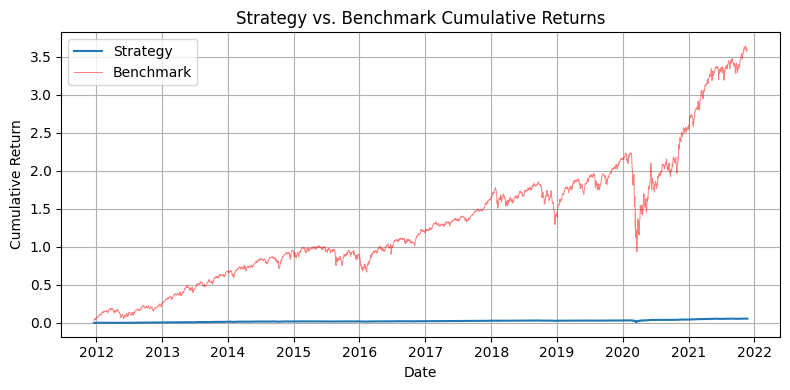

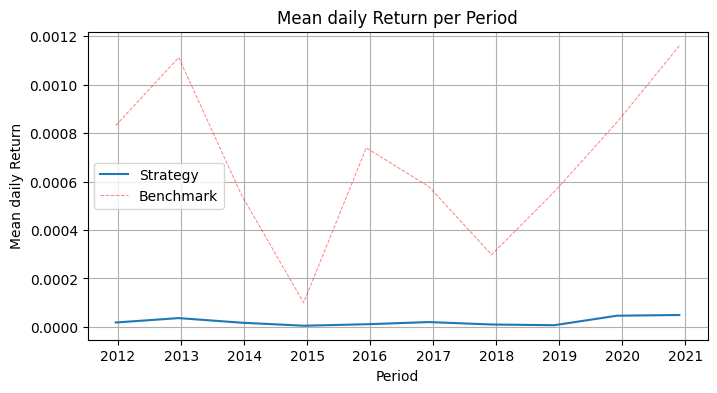

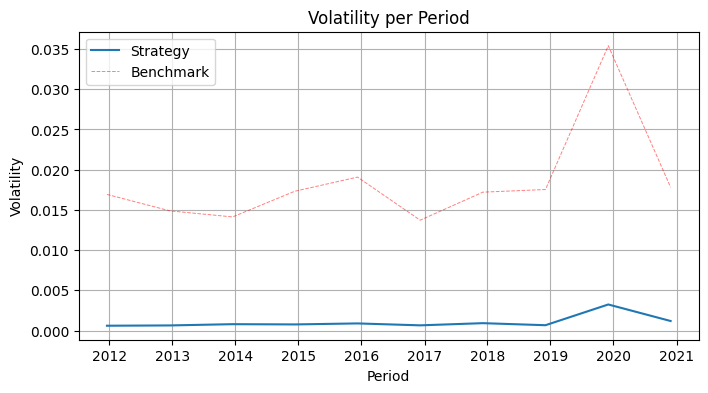

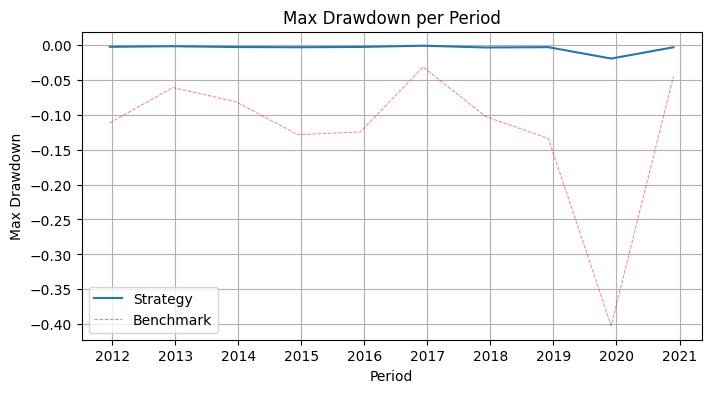

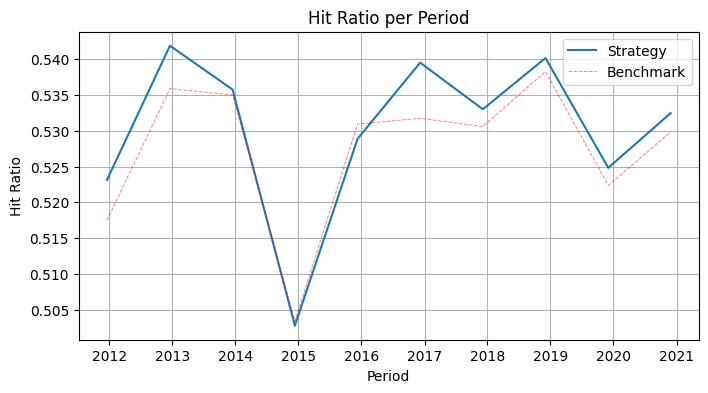

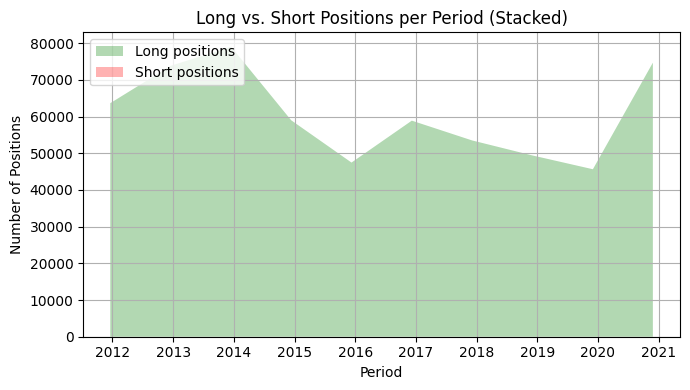

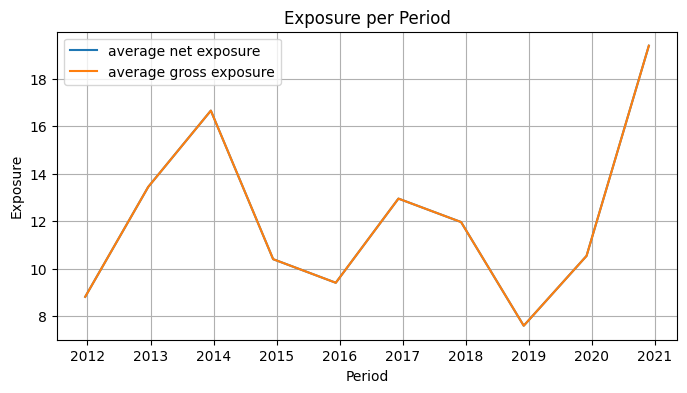

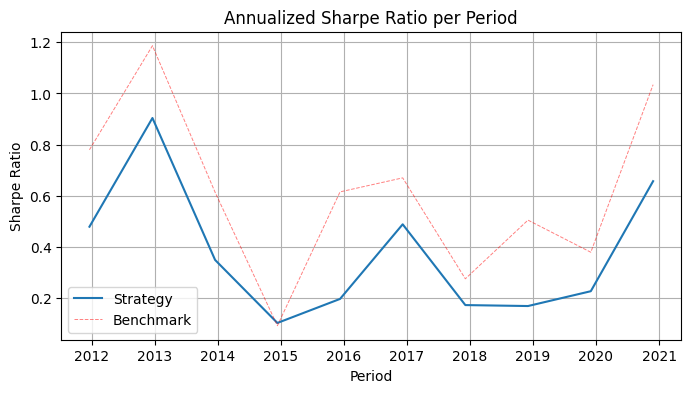

Benchmark Strategy
overall mean daily return        0.0679%  0.0022%
overall volatility daily         1.9347%  0.1285%
overall annualized return         17.10%    0.56%
overall annualized volatility     30.71%    2.04%
overall max drawdown             -40.21%   -1.95%
overall sharpe ratio            0.556863  0.27368
overall hit ratio                 52.75%   53.07%
overall average net exposure         NaN    12.12
overall average gross exposure       NaN    12.12
overall total positions              NaN   605068
overall long %                       NaN  100.00%

In [16]:
conv_log_LO_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = logistic_mapping,
                                           K=10,
                                           leverage=1,
                                           LongOnly=True)
conv_log_LO_strategy_metrics

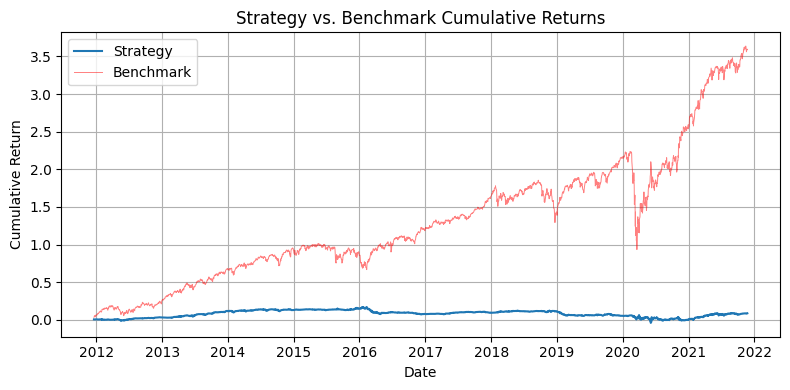

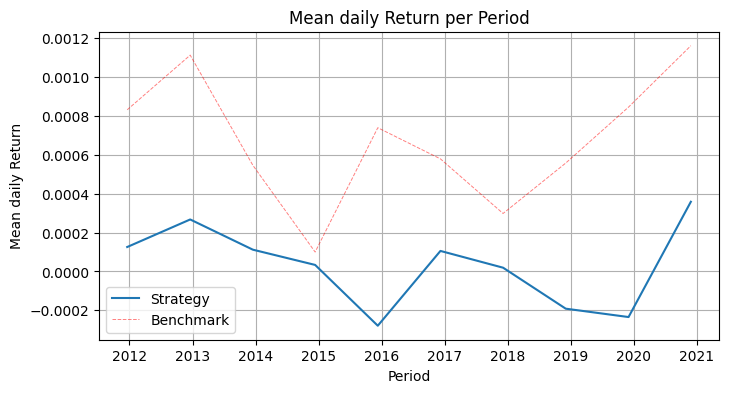

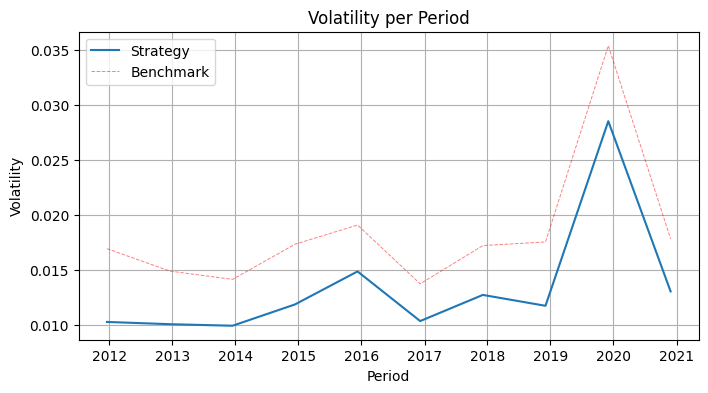

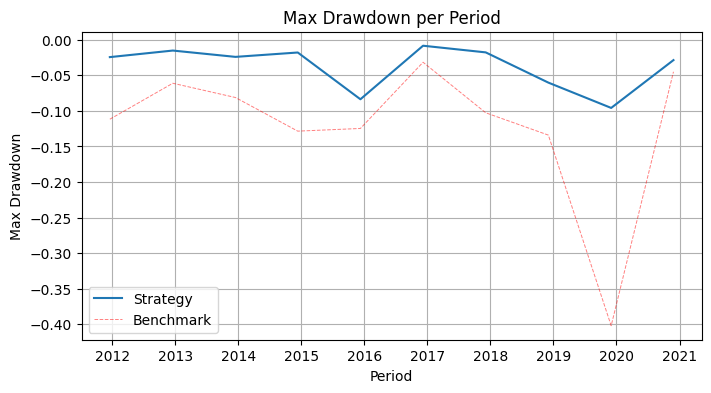

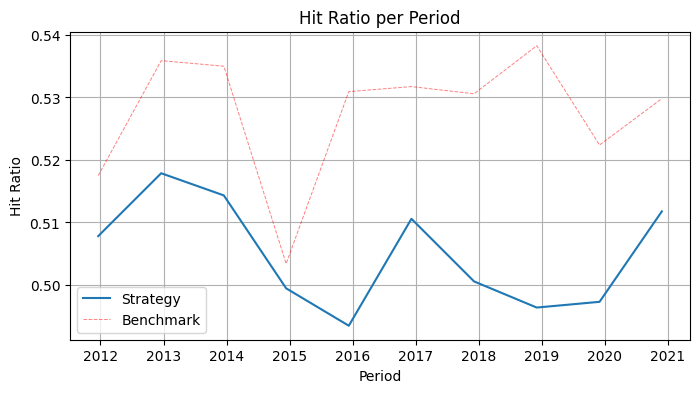

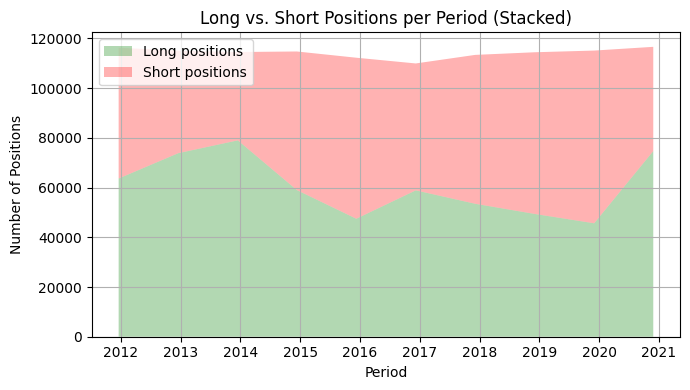

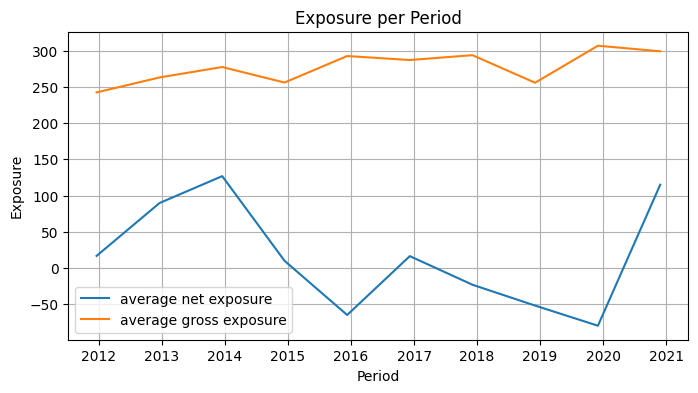

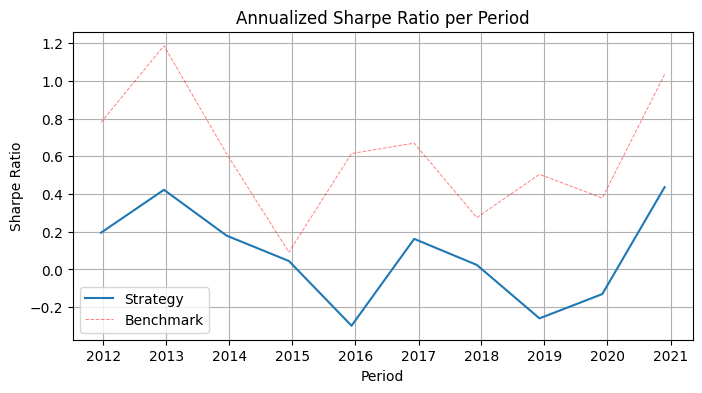

Benchmark  Strategy
overall mean daily return        0.0679%   0.0033%
overall volatility daily         1.9347%   1.4347%
overall annualized return         17.10%     0.83%
overall annualized volatility     30.71%    22.77%
overall max drawdown             -40.21%   -18.05%
overall sharpe ratio            0.556863  0.036262
overall hit ratio                 52.75%    50.50%
overall average net exposure         NaN     15.36
overall average gross exposure       NaN    277.55
overall total positions              NaN   1142415
overall long %                       NaN    52.96%

In [17]:
conv_hyp_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = hyperbolic_mapping,
                                           K=100,
                                           leverage=1,
                                           LongOnly=False)
conv_hyp_strategy_metrics

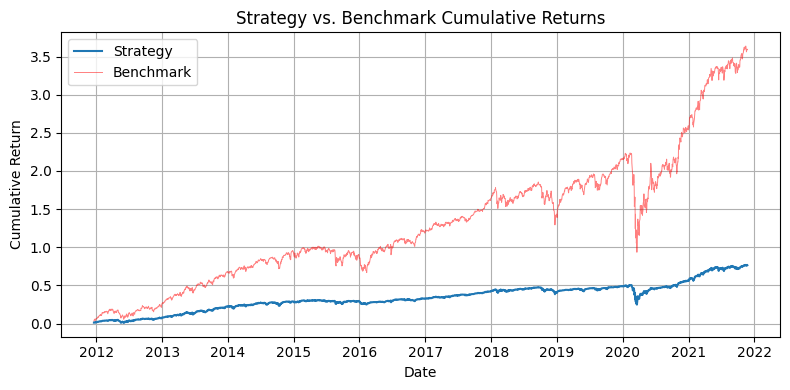

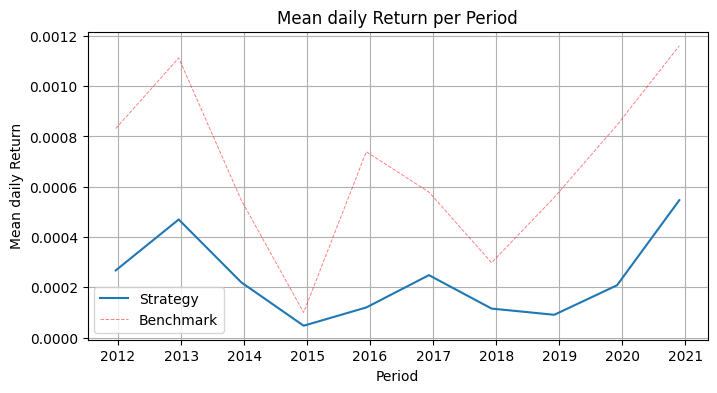

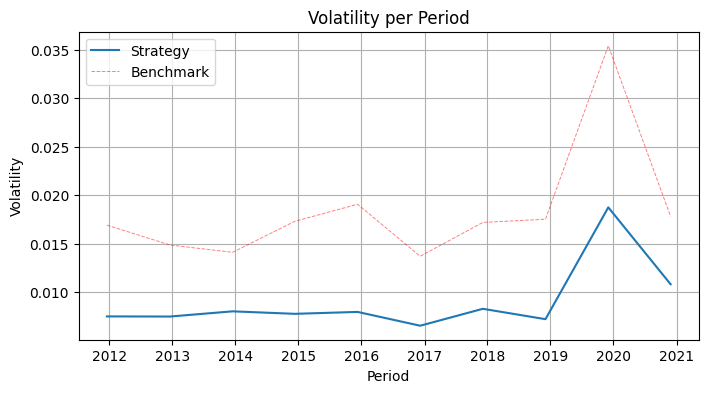

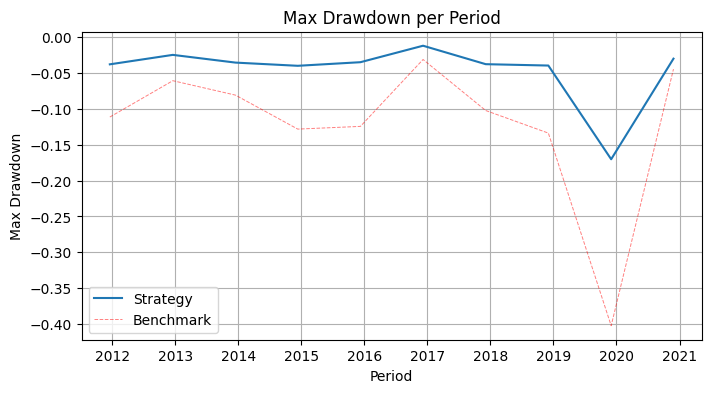

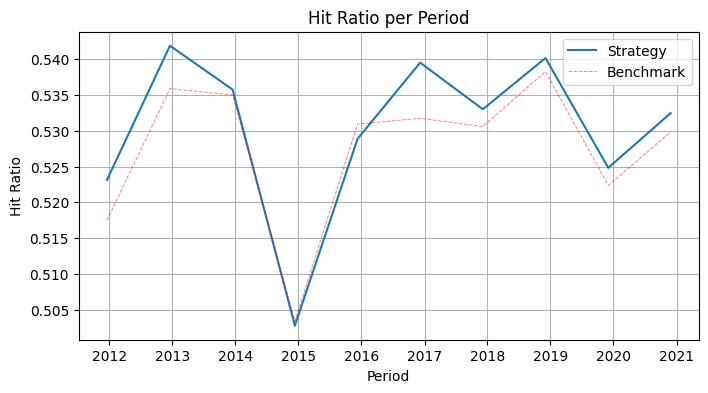

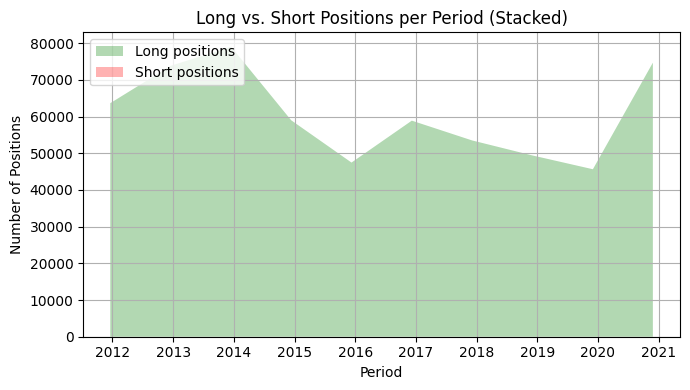

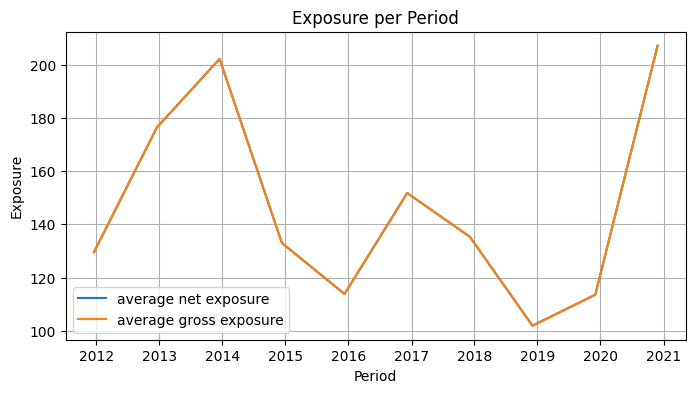

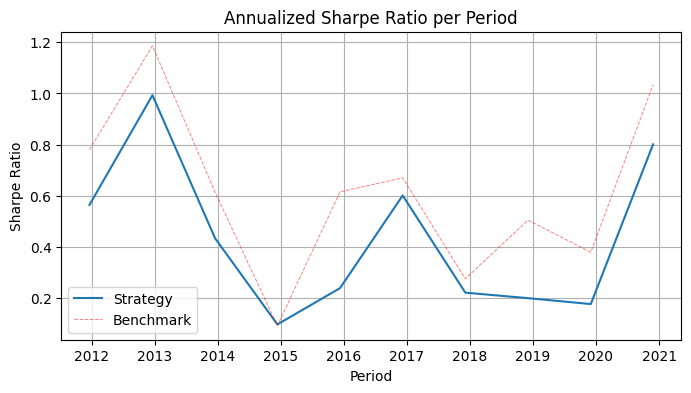

Benchmark  Strategy
overall mean daily return        0.0679%   0.0234%
overall volatility daily         1.9347%   0.9693%
overall annualized return         17.10%     5.91%
overall annualized volatility     30.71%    15.39%
overall max drawdown             -40.21%   -17.04%
overall sharpe ratio            0.556863  0.383816
overall hit ratio                 52.75%    53.07%
overall average net exposure         NaN    146.46
overall average gross exposure       NaN    146.46
overall total positions              NaN    605068
overall long %                       NaN   100.00%

In [18]:
conv_hyp_LO_strategy_metrics = backtesting(results_LSTM, convolution_strategy_performance,
                                           convolution = hyperbolic_mapping,
                                           K=100,
                                           leverage=1,
                                           LongOnly=True)
conv_hyp_LO_strategy_metrics

### 5.3 Portfolio optimization strategies.

Another strategy is to go long the K stocks where the algorithm is the most 'sure they're going up' (meaning where the value of the prediction is closest to 1) and go short the K stocks where the algorithm is the most 'sure they are going down' (meaning where the value of the prediction is closest to 0).

In this section, we test 4 strategies:

- Long/Short K (absolute), where we do what is described above.
- Long/Short K (relative). Where instead of selecting an absolute number of stocks, we go long the upper K% and short the lower K%.

- Long only K (aboslute) where we do the same as before but go long only.
- Long only K (relative) where we do the same as before but go long only.

On all these functions, we allow leverage if one might want to test using it.

In [19]:
def LSK_absolute_strategy_performance(trade_predictions_df, leverage=1, K=10, LongOnly=False):
    df = trade_predictions_df.copy()
    # rank 1..N within each date
    df['rank_asc']  = df.groupby('date')['prediction_proba'].rank(method='first')
    df['rank_desc'] = df.groupby('date')['prediction_proba'].rank(method='first', ascending=False)

    # long = top K  ⇒ rank_desc <= K
    df['strategy_position'] = np.where(
        df['rank_desc'] <= K,
        1 * leverage,
        0
    )
    # short = bottom K ⇒ rank_asc <= K (unless LongOnly)
    if not LongOnly:
        df['strategy_position'] = np.where(
            df['rank_asc'] <= K,
            -1 * leverage,
            df['strategy_position']
        )

    df['strategy_return'] = df['strategy_position'] * df['next_day_return']

    df.drop(columns=['rank_asc', 'rank_desc'], inplace=True)

    return df


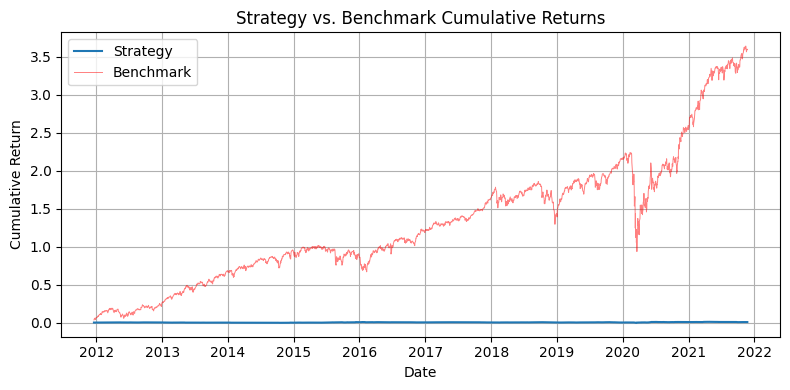

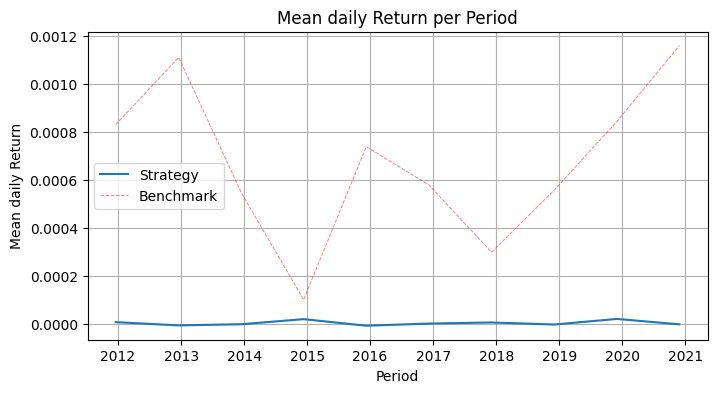

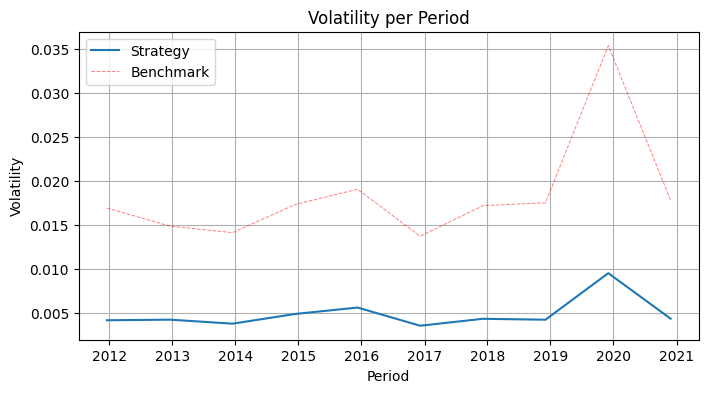

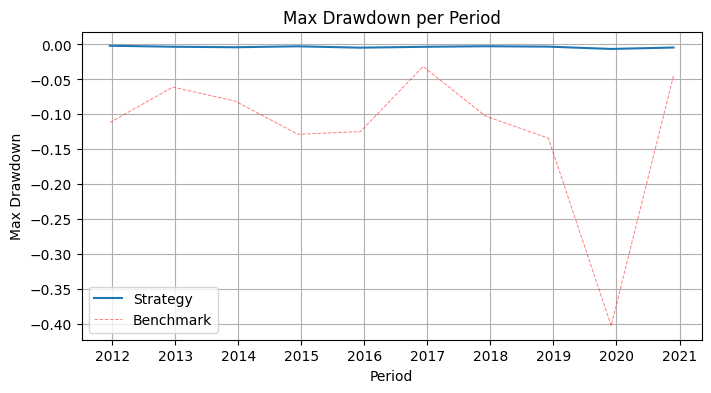

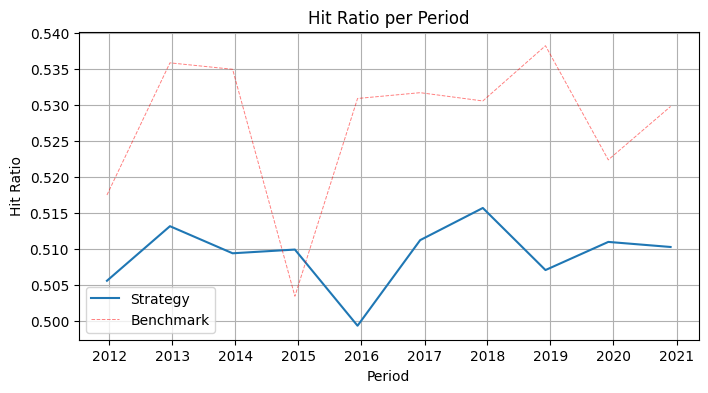

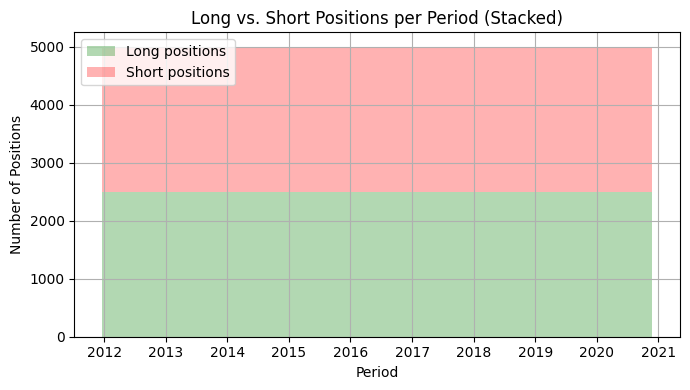

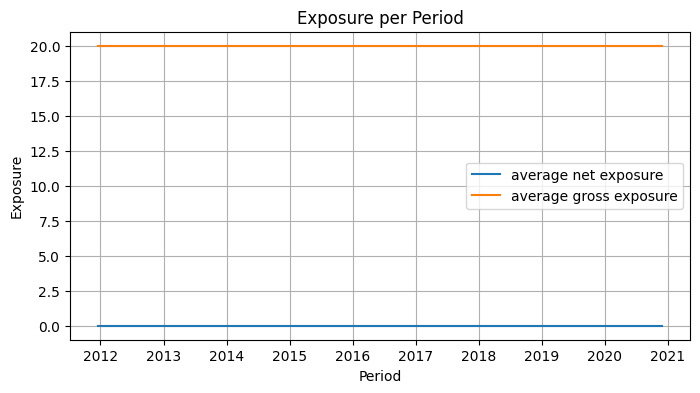

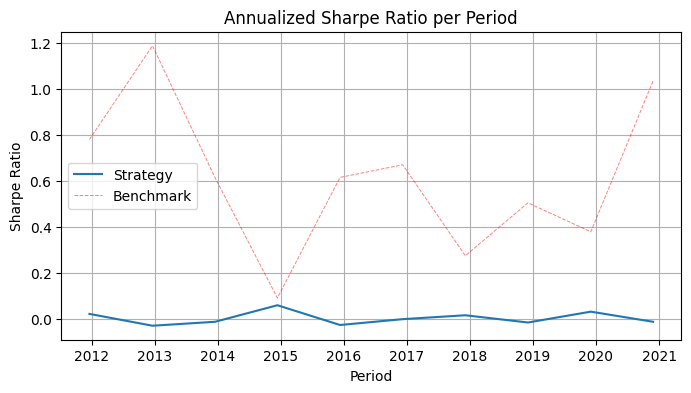

Benchmark  Strategy
overall mean daily return        0.0679%   0.0002%
overall volatility daily         1.9347%   0.5132%
overall annualized return         17.10%     0.05%
overall annualized volatility     30.71%     8.15%
overall max drawdown             -40.21%    -1.11%
overall sharpe ratio            0.556863  0.006656
overall hit ratio                 52.75%    50.92%
overall average net exposure         NaN      0.00
overall average gross exposure       NaN     20.00
overall total positions              NaN     50000
overall long %                       NaN    50.00%

In [20]:
LSK_abs_strategy_metrics = backtesting(results_LSTM, LSK_absolute_strategy_performance,
                                           K=10,
                                           leverage=1,
                                           LongOnly=False)
LSK_abs_strategy_metrics

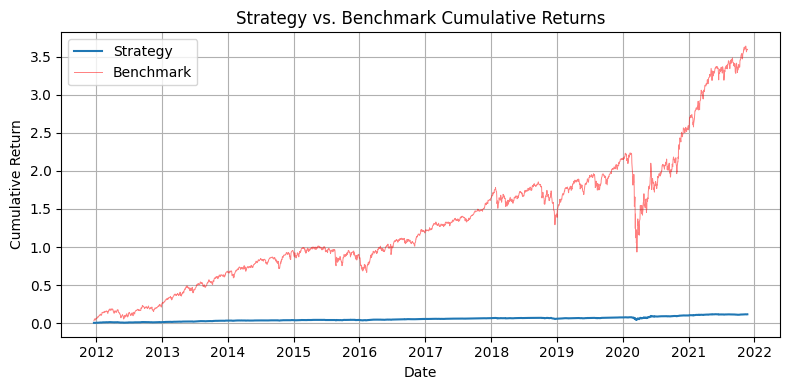

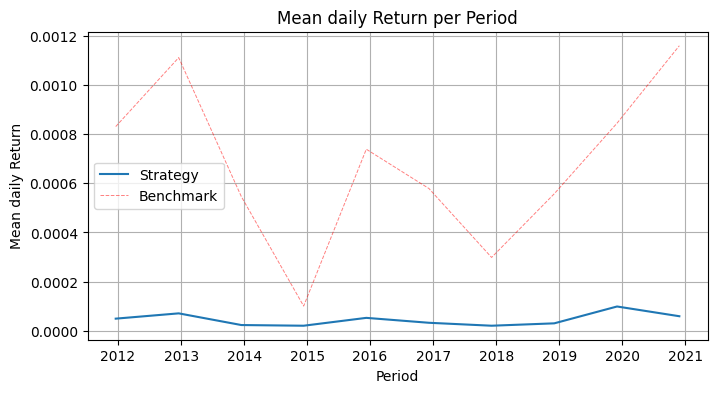

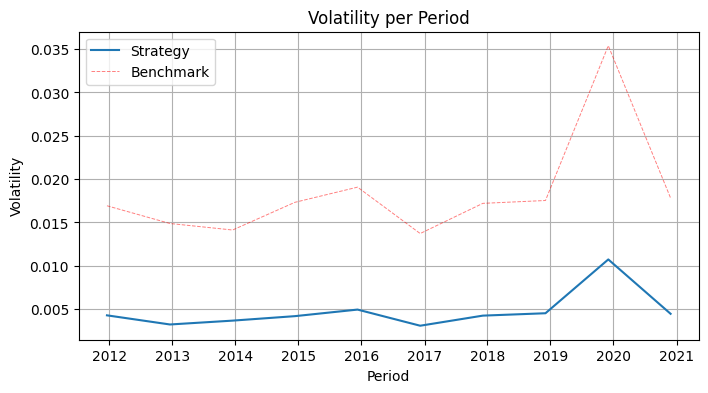

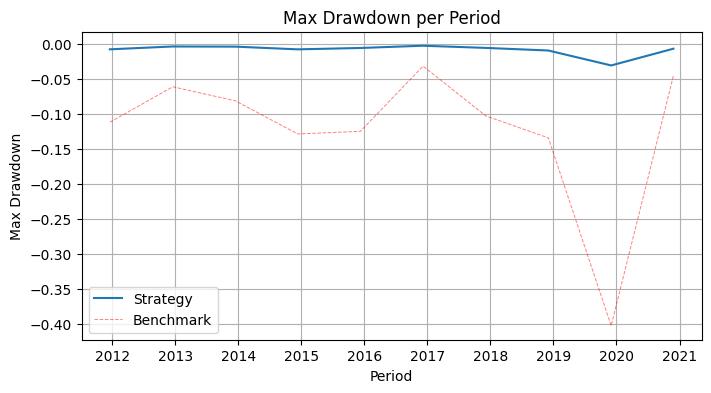

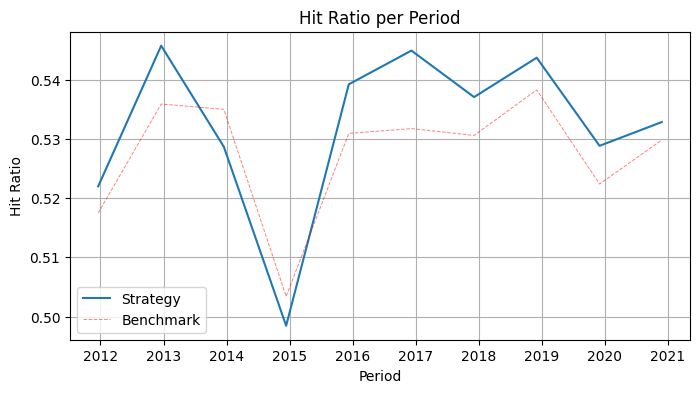

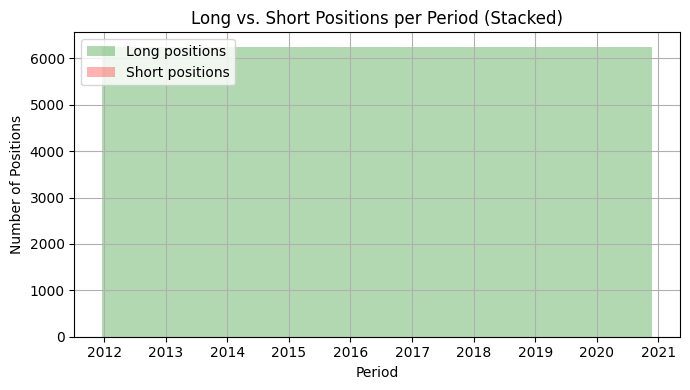

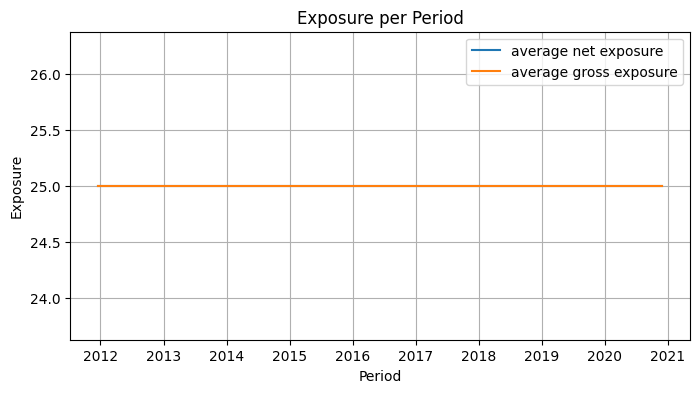

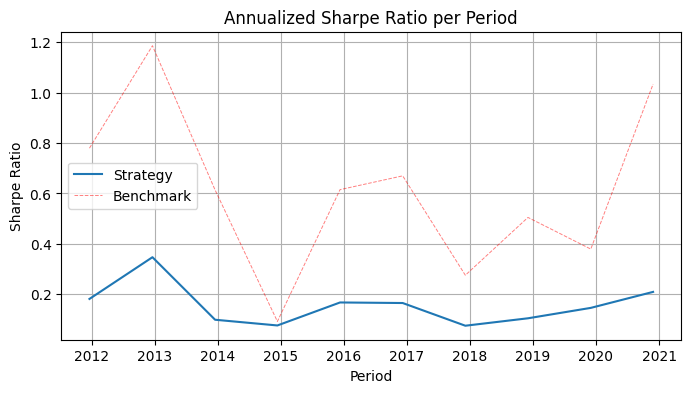

Benchmark  Strategy
overall mean daily return        0.0679%   0.0045%
overall volatility daily         1.9347%   0.5171%
overall annualized return         17.10%     1.14%
overall annualized volatility     30.71%     8.21%
overall max drawdown             -40.21%    -3.06%
overall sharpe ratio            0.556863  0.138975
overall hit ratio                 52.75%    53.21%
overall average net exposure         NaN     25.00
overall average gross exposure       NaN     25.00
overall total positions              NaN     62500
overall long %                       NaN   100.00%

In [21]:
LSK_abs_LO_strategy_metrics = backtesting(results_LSTM, LSK_absolute_strategy_performance,
                                           K=25,
                                           leverage=1,
                                           LongOnly=True)
LSK_abs_LO_strategy_metrics

In [22]:
import numpy as np

def LSK_relative_strategy_performance(trade_predictions_df,leverage = 1, K = 0.10, LongOnly = False):
    """
    Each day, go long the top K*100% of symbols by prediction_proba
    and (unless LongOnly) short the bottom K*100%.
    """
    df = trade_predictions_df.copy()

    # 1) percentile rank within each date (0 < rank_K <= 1)
    df['rank_K'] = (
        df
        .groupby('date')['prediction_proba']
        .rank(method='first', pct=True)
    )

    # 2) build positions
    #    long if rank_K >= 1 - K
    #    short if rank_K <= K (unless LongOnly)
    df['strategy_position'] = np.where(
        df['rank_K'] >= 1 - K,
        1 * leverage,
        0
    )

    if not LongOnly:
        df['strategy_position'] = np.where(
            df['rank_K'] <= K,
            -1 * leverage,
            df['strategy_position']
        )

    # 3) compute returns
    df['strategy_return'] = df['strategy_position'] * df['next_day_return']

    # 4) clean up
    df.drop(columns='rank_K', inplace=True)

    return df



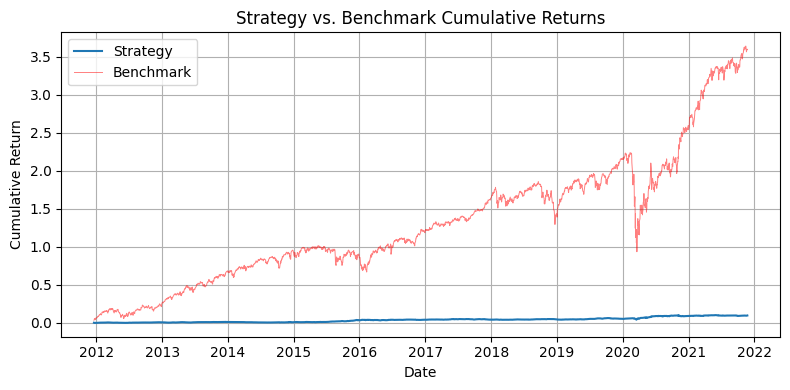

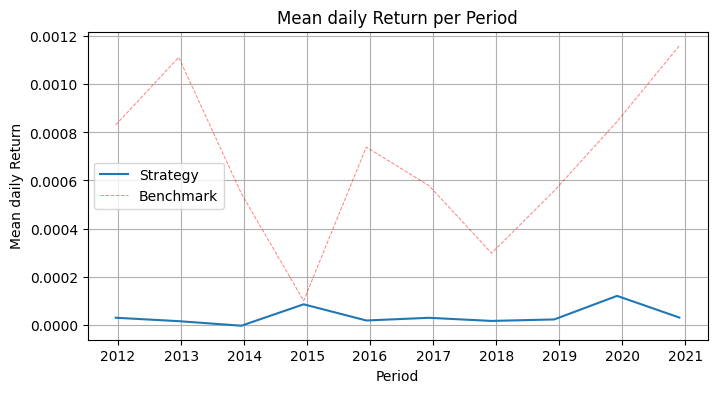

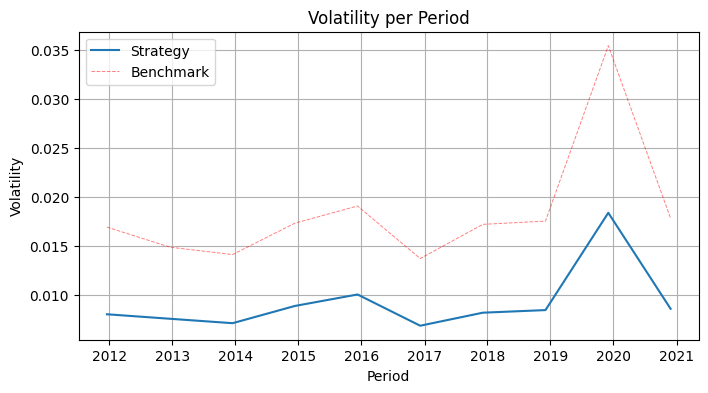

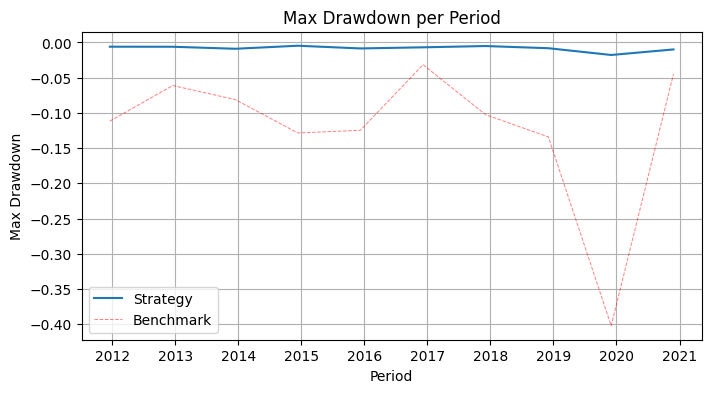

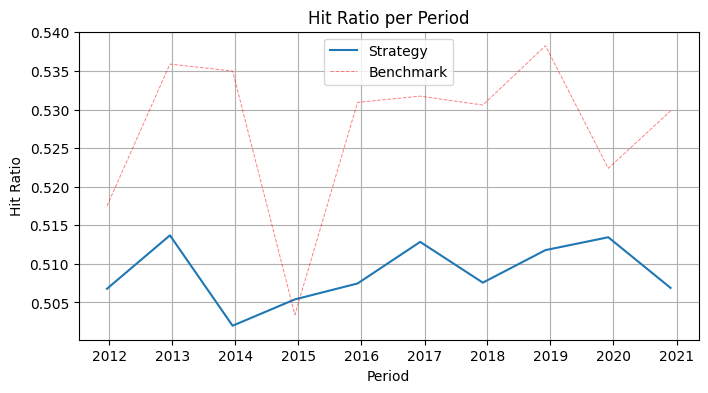

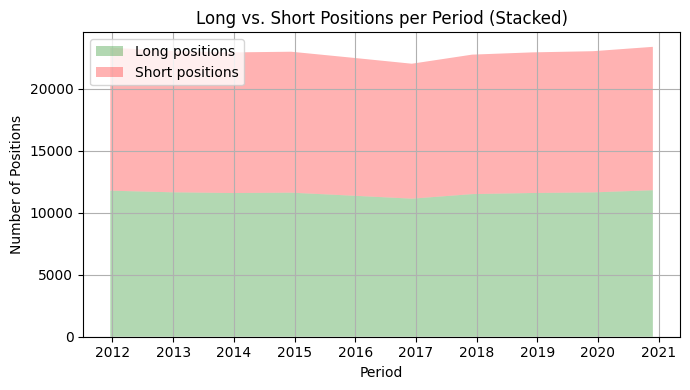

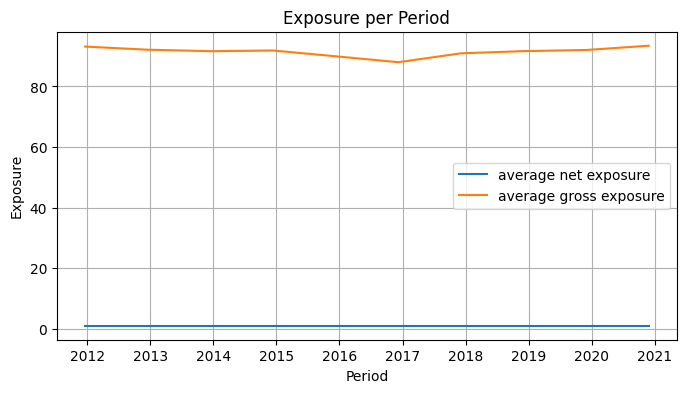

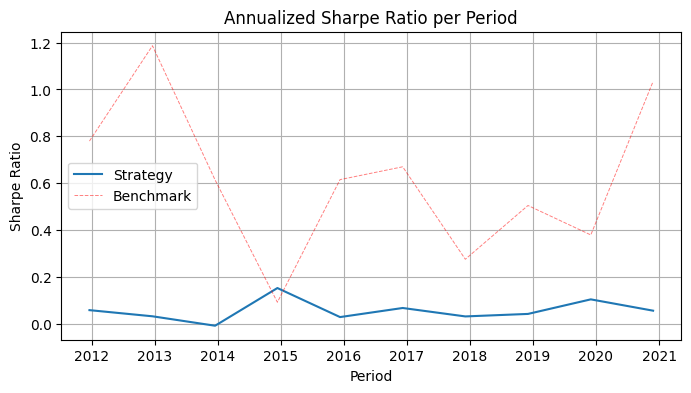

Benchmark  Strategy
overall mean daily return        0.0679%   0.0036%
overall volatility daily         1.9347%   0.9763%
overall annualized return         17.10%     0.91%
overall annualized volatility     30.71%    15.50%
overall max drawdown             -40.21%    -2.03%
overall sharpe ratio            0.556863  0.058878
overall hit ratio                 52.75%    50.88%
overall average net exposure         NaN      1.00
overall average gross exposure       NaN     91.50
overall total positions              NaN    228738
overall long %                       NaN    50.55%

In [23]:
LSK_rel_strategy_metrics = backtesting(results_LSTM, LSK_relative_strategy_performance,
                                           K=0.10,
                                           leverage=1,
                                           LongOnly=False)
LSK_rel_strategy_metrics

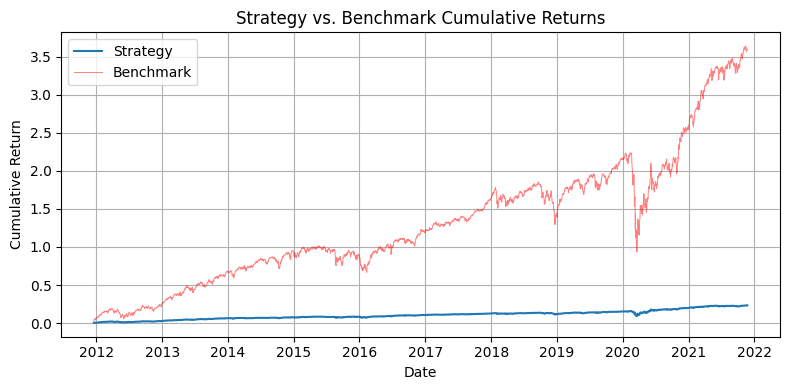

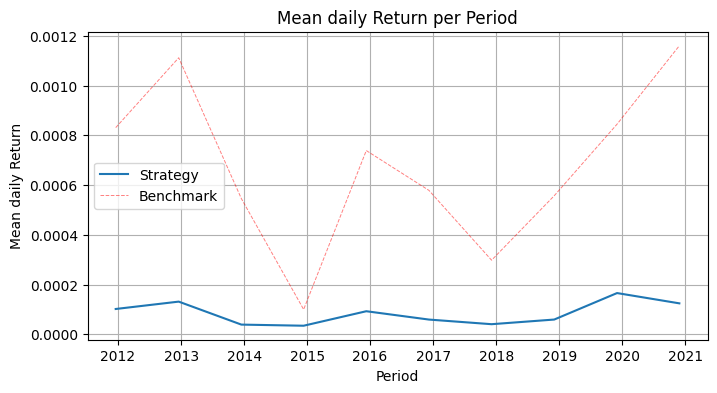

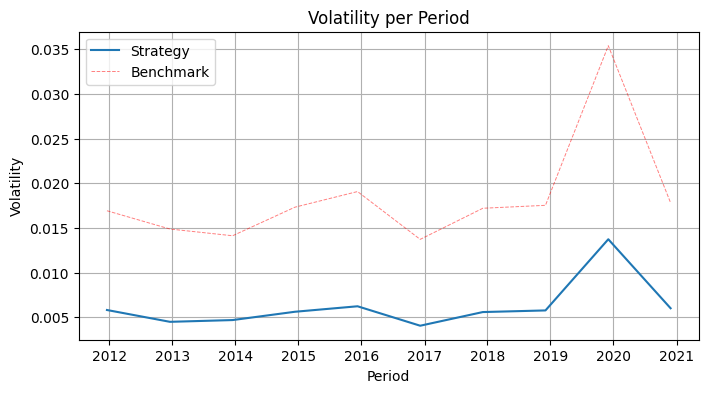

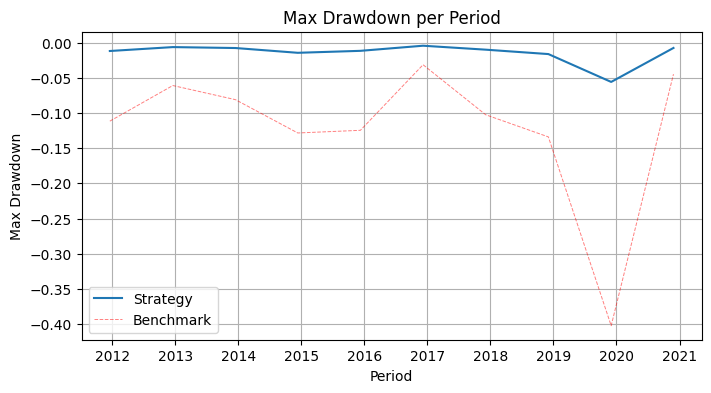

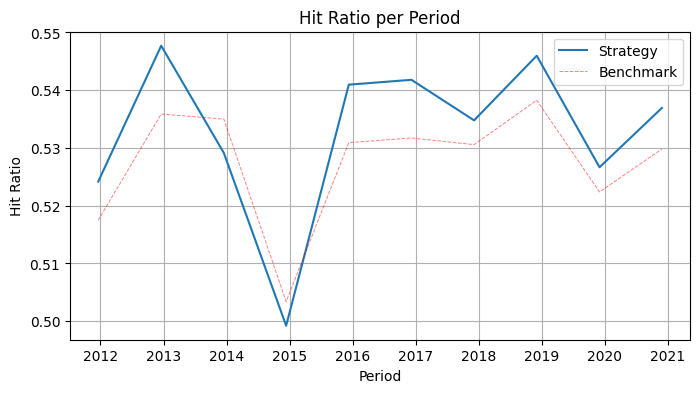

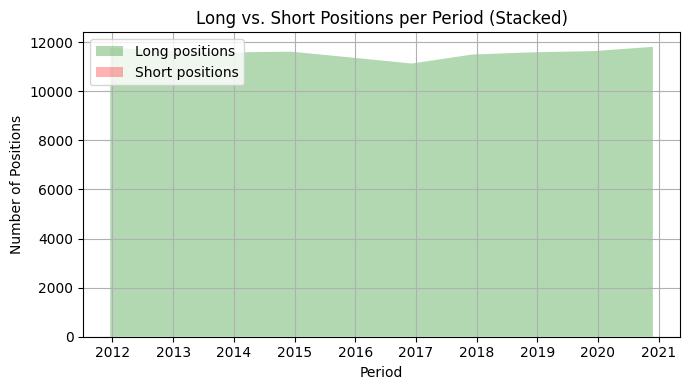

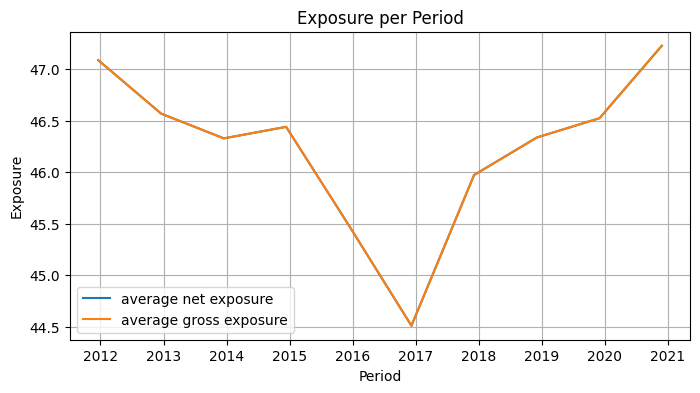

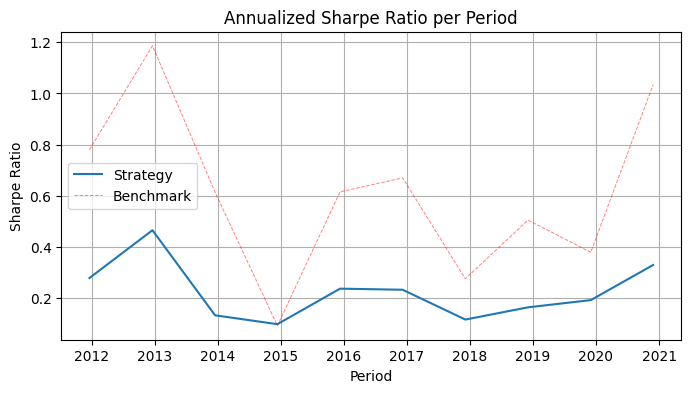

Benchmark Strategy
overall mean daily return        0.0679%  0.0085%
overall volatility daily         1.9347%  0.6731%
overall annualized return         17.10%    2.15%
overall annualized volatility     30.71%   10.69%
overall max drawdown             -40.21%   -5.60%
overall sharpe ratio            0.556863   0.2009
overall hit ratio                 52.75%   53.27%
overall average net exposure         NaN    46.25
overall average gross exposure       NaN    46.25
overall total positions              NaN   115619
overall long %                       NaN  100.00%

In [24]:
LSK_rel_LO_strategy_metrics = backtesting(results_LSTM, LSK_relative_strategy_performance,
                                           K=0.10,
                                           leverage=1,
                                           LongOnly=True)
LSK_rel_LO_strategy_metrics

### 5.3 In-Sample sharpe ratio optimization.

Now that we have defined those strategies and backtested an *naïve* version of them, we can try to find a threshold (value for K) that optimizes the Sharpe ratio.

Why not try to optimize for final cumulative returns ? Because, in theory, with a profitable strategy, one can get any amount of cumulative returns with enough leverage.

Take for example a strategy with a return of 5% and volatility of 10%, if we double the leverage, we get 10% returns and 20% volatility. We doubled the returns but also doubled the risk. What didn't change is the amount of risk we have taken for a given level of returns, which is the Sharpe Ratio.

Our aim is to beat the sharpe ratio of the benchmark because no matter the leverage, the sharpe ratio stays the same.

Unfortunately, this analysis is done after training and is therefore in-sample.

Here are the strategies that we are going to optimize the sharpe ratio for :    

- Binary Classification
- Binary Classification Long Only
- Linear Convolution
- Linear Convolution Long Only
- Sinusoïdal Convolution
- Sinusoïdal Convolution Long Only
- Logistic Convolution
- Logistic Convolution Long Only
- Hyperbolic Convolution
- Hyperbolic Convolution Long Only
- Long/Short K with absolute K
- Long K with absolute K
- Long/Short K with relative K
- Long K with relative K

We create a dictionary holding all of the necessary information for the optimization.

In [25]:
num = 200

K_values_linspace = np.linspace(0.000,0.499, num = num).tolist()
K_values_convolutions = np.linspace(0.001, 1000.000, num = num).tolist()
K_values_absolute = np.int64(np.linspace(1, 250, num = num)).tolist()
K_values_absolute_LO = np.int64(np.linspace(1, 475, num = num)).tolist()
K_values_relative_LO = np.linspace(0.001, 0.995, num = num).tolist()

def benchmark_performance(trade_predictions_df, leverage=1, convolution=None, K=None, LongOnly = False):
    df = trade_predictions_df.copy()
    df['strategy_position'] = 1 * leverage
    df['strategy_return'] = df['strategy_position'] * df['next_day_return']
    return df

strategies = [
    {
    'Name': 'Benchmark',
    'function': benchmark_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : [None],
    },
    {
    'Name': 'Binary Classification',
    'function': binary_strategy_performance,
    'Convolution' : None,
    'LongOnly': False,
    'K_values' : K_values_linspace,
    },
    {
    'Name': 'Binary Classification Long Only',
    'function': binary_strategy_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : K_values_linspace,
    },
    {
    'Name': 'Linear Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : linear_mapping,
    'LongOnly': False,
    'K_values' : [None],
    },
    {
    'Name': 'Linear Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : linear_mapping,
    'LongOnly': True,
    'K_values' : [None],
    },
    {
    'Name': 'Sinusoïdal Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : sinusoidal_mapping,
    'LongOnly': False,
    'K_values' : [None],
    },
    {
    'Name': 'Sinusoïdal Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : sinusoidal_mapping,
    'LongOnly': True,
    'K_values' : [None],
    },
    {
    'Name': 'Logistic Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : logistic_mapping,
    'LongOnly': False,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Logistic Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : logistic_mapping,
    'LongOnly': True,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Hyperbolic Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : hyperbolic_mapping,
    'LongOnly': False,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Hyperbolic Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : hyperbolic_mapping,
    'LongOnly': True,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Long Short K with absolute K',
    'function': LSK_absolute_strategy_performance,
    'Convolution' : None,
    'LongOnly': False,
    'K_values' : K_values_absolute,
    },
    {
    'Name': 'Long K with absolute K',
    'function': LSK_absolute_strategy_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : K_values_absolute_LO,
    },
    {
    'Name': 'Long Short K with relative K',
    'function': LSK_relative_strategy_performance,
    'Convolution' : None,
    'LongOnly': False,
    'K_values' : K_values_linspace,
    },
    {
    'Name': 'Long K with relative K',
    'function': LSK_relative_strategy_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : K_values_relative_LO,
    }
]

In [26]:
import pandas as pd
import numpy as np

all_results = [results_CNN, results_LSTM, results_LSTM_CNN]
model_names = ['CNN', 'LSTM', 'LSTM_CNN']

# Initialize parameters and lists
optimization_results = []
trading_days = 252

for model_name, results in zip(model_names, all_results):
    # Accumulate all trade predictions in a single dataframe
    all_trade_predictions_df = pd.concat(
        [period['trade_predictions'] for period in results],
        ignore_index=True
    )
    all_trade_predictions_df['Model'] = model_name

    # Get period dates from results
    period_dates = [period['test_range'] for period in results]

    for strategy in strategies:
        name       = strategy['Name']
        func       = strategy['function']
        conv       = strategy['Convolution']
        long_only  = strategy['LongOnly']
        K_values   = strategy['K_values']

        print(f'-- Processing Model={model_name}, Strategy={name}')

        for K in K_values:
            # call with or without convolution arg
            if conv is None:
                strategy_df = func(
                    all_trade_predictions_df,
                    leverage=1,
                    LongOnly=long_only,
                    K=K
                )
            else:
                strategy_df = func(
                    all_trade_predictions_df,
                    leverage=1,
                    convolution=conv,
                    LongOnly=long_only,
                    K=K
                )

            # tag model and strategy
            strategy_df['Model']    = model_name
            strategy_df['Strategy'] = name
            strategy_df['K']        = K
            strategy_df['Convolution'] = conv.__name__ if conv is not None else None

            # Overall metrics
            mean_d = strategy_df['strategy_return'].mean()
            vol_d  = strategy_df['strategy_return'].std()

            ann_ret = mean_d * trading_days
            ann_vol = vol_d * np.sqrt(trading_days)
            ann_sharpe = (
                np.sqrt(trading_days) * (mean_d / vol_d)
                if vol_d != 0 else 0
            )

            optimization_results.append({
                'Model': model_name,
                'Name': name,
                'Period': 'Overall',
                'Convolution': conv.__name__ if conv is not None else None,
                'K': K,
                'Annualized return': ann_ret,
                'Annualized Vol': ann_vol,
                'Annualized Sharpe': ann_sharpe
            })

            # Per‐period metrics
            for period_idx, (start_date, end_date) in enumerate(period_dates, start=1):
                period_df = strategy_df[
                    (strategy_df['date'] >= start_date) &
                    (strategy_df['date'] <= end_date)
                ]

                mean_d = period_df['strategy_return'].mean()
                vol_d  = period_df['strategy_return'].std()

                ann_ret = mean_d * trading_days
                ann_vol = vol_d * np.sqrt(trading_days)
                ann_sharpe = (
                    np.sqrt(trading_days) * (mean_d / vol_d)
                    if vol_d != 0 else 0
                )

                optimization_results.append({
                    'Model': model_name,
                    'Name': name,
                    'Period': period_idx,
                    'Convolution': conv.__name__ if conv is not None else None,
                    'K': K,
                    'Annualized return': ann_ret,
                    'Annualized Vol': ann_vol,
                    'Annualized Sharpe': ann_sharpe
                })

# Final dataframe
optimization_results_df = pd.DataFrame(optimization_results)

-- Processing Model=CNN, Strategy=Benchmark
-- Processing Model=CNN, Strategy=Binary Classification
-- Processing Model=CNN, Strategy=Binary Classification Long Only
-- Processing Model=CNN, Strategy=Linear Transformation
-- Processing Model=CNN, Strategy=Linear Transformation Long Only
-- Processing Model=CNN, Strategy=Sinusoïdal Transformation
-- Processing Model=CNN, Strategy=Sinusoïdal Transformation Long Only
-- Processing Model=CNN, Strategy=Logistic Transformation
-- Processing Model=CNN, Strategy=Logistic Transformation Long Only
-- Processing Model=CNN, Strategy=Hyperbolic Transformation
-- Processing Model=CNN, Strategy=Hyperbolic Transformation Long Only
-- Processing Model=CNN, Strategy=Long Short K with absolute K
-- Processing Model=CNN, Strategy=Long K with absolute K
-- Processing Model=CNN, Strategy=Long Short K with relative K
-- Processing Model=CNN, Strategy=Long K with relative K
-- Processing Model=LSTM, Strategy=Benchmark
-- Processing Model=LSTM, Strategy=Binary

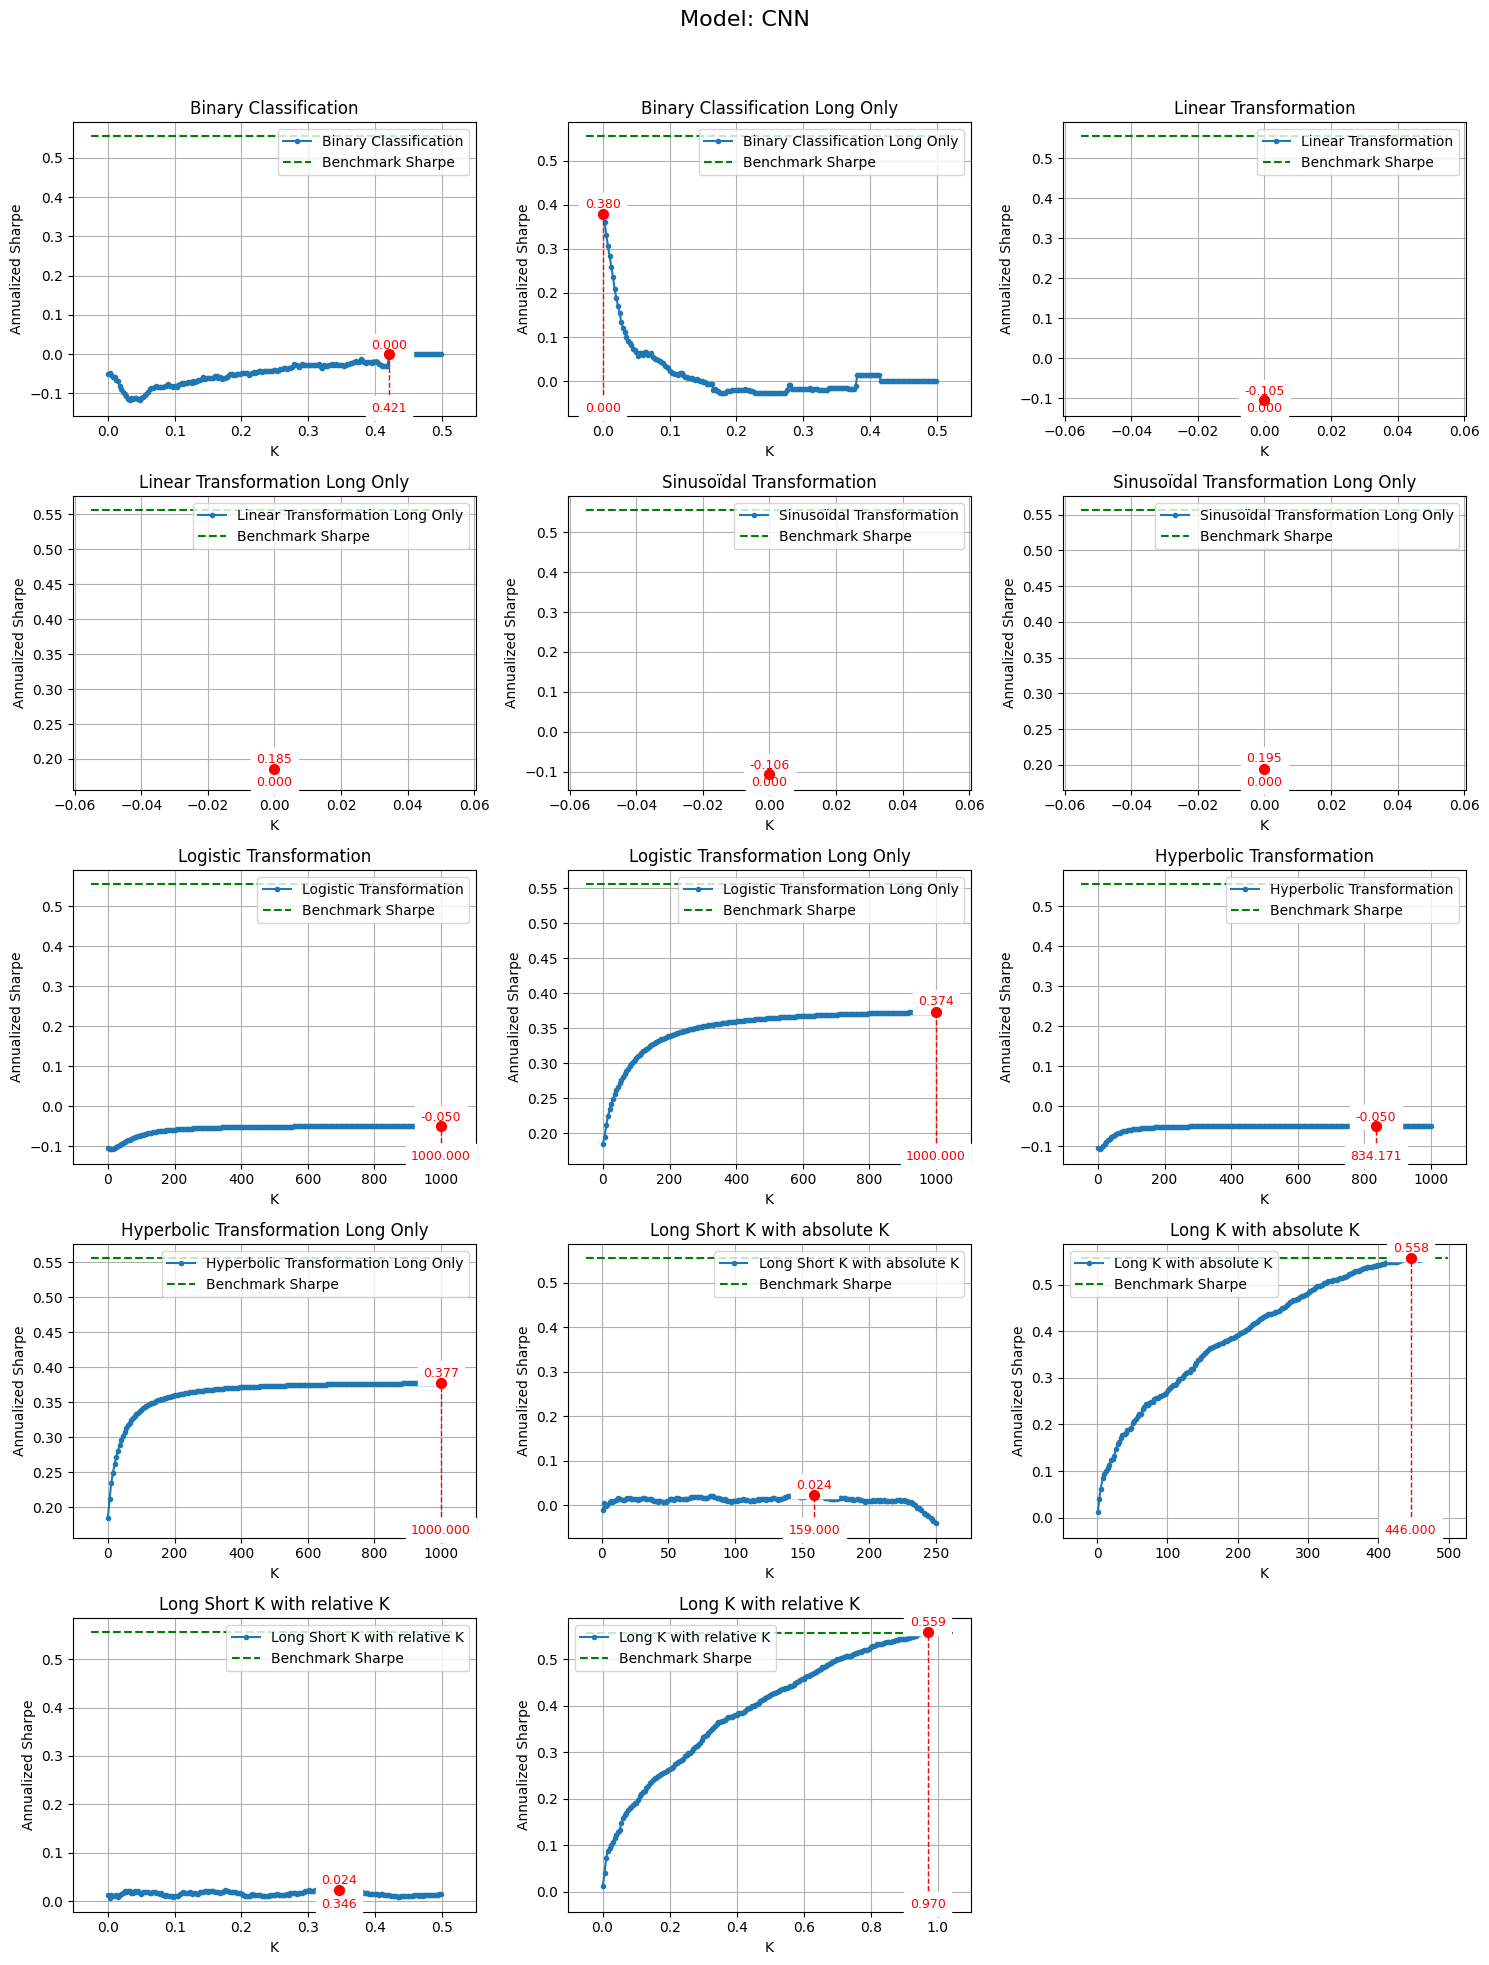

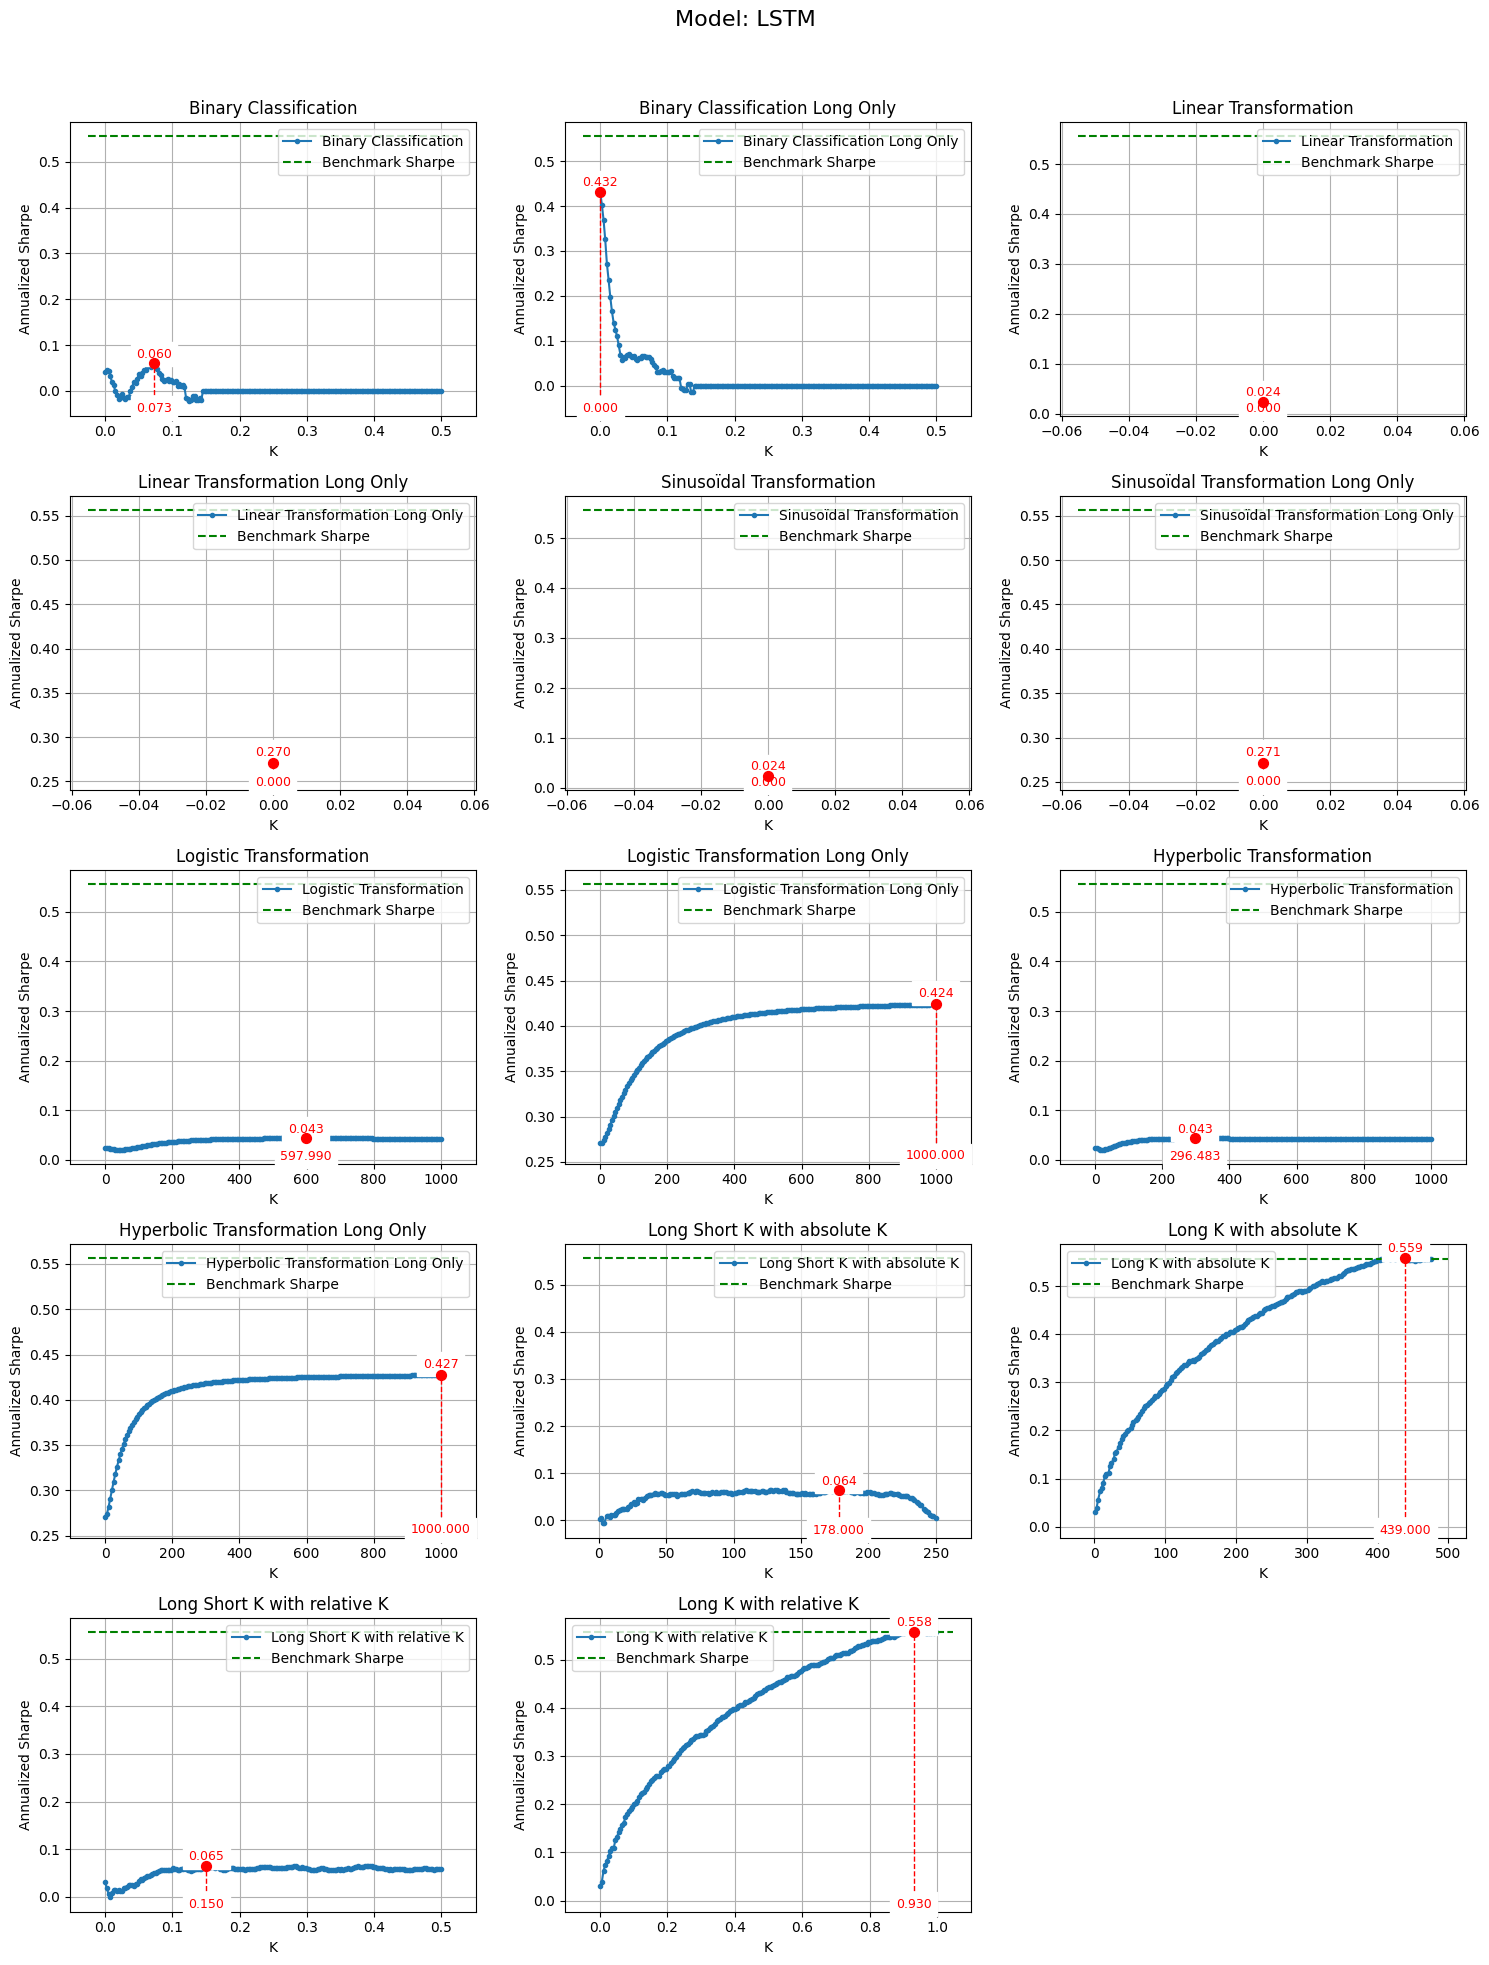

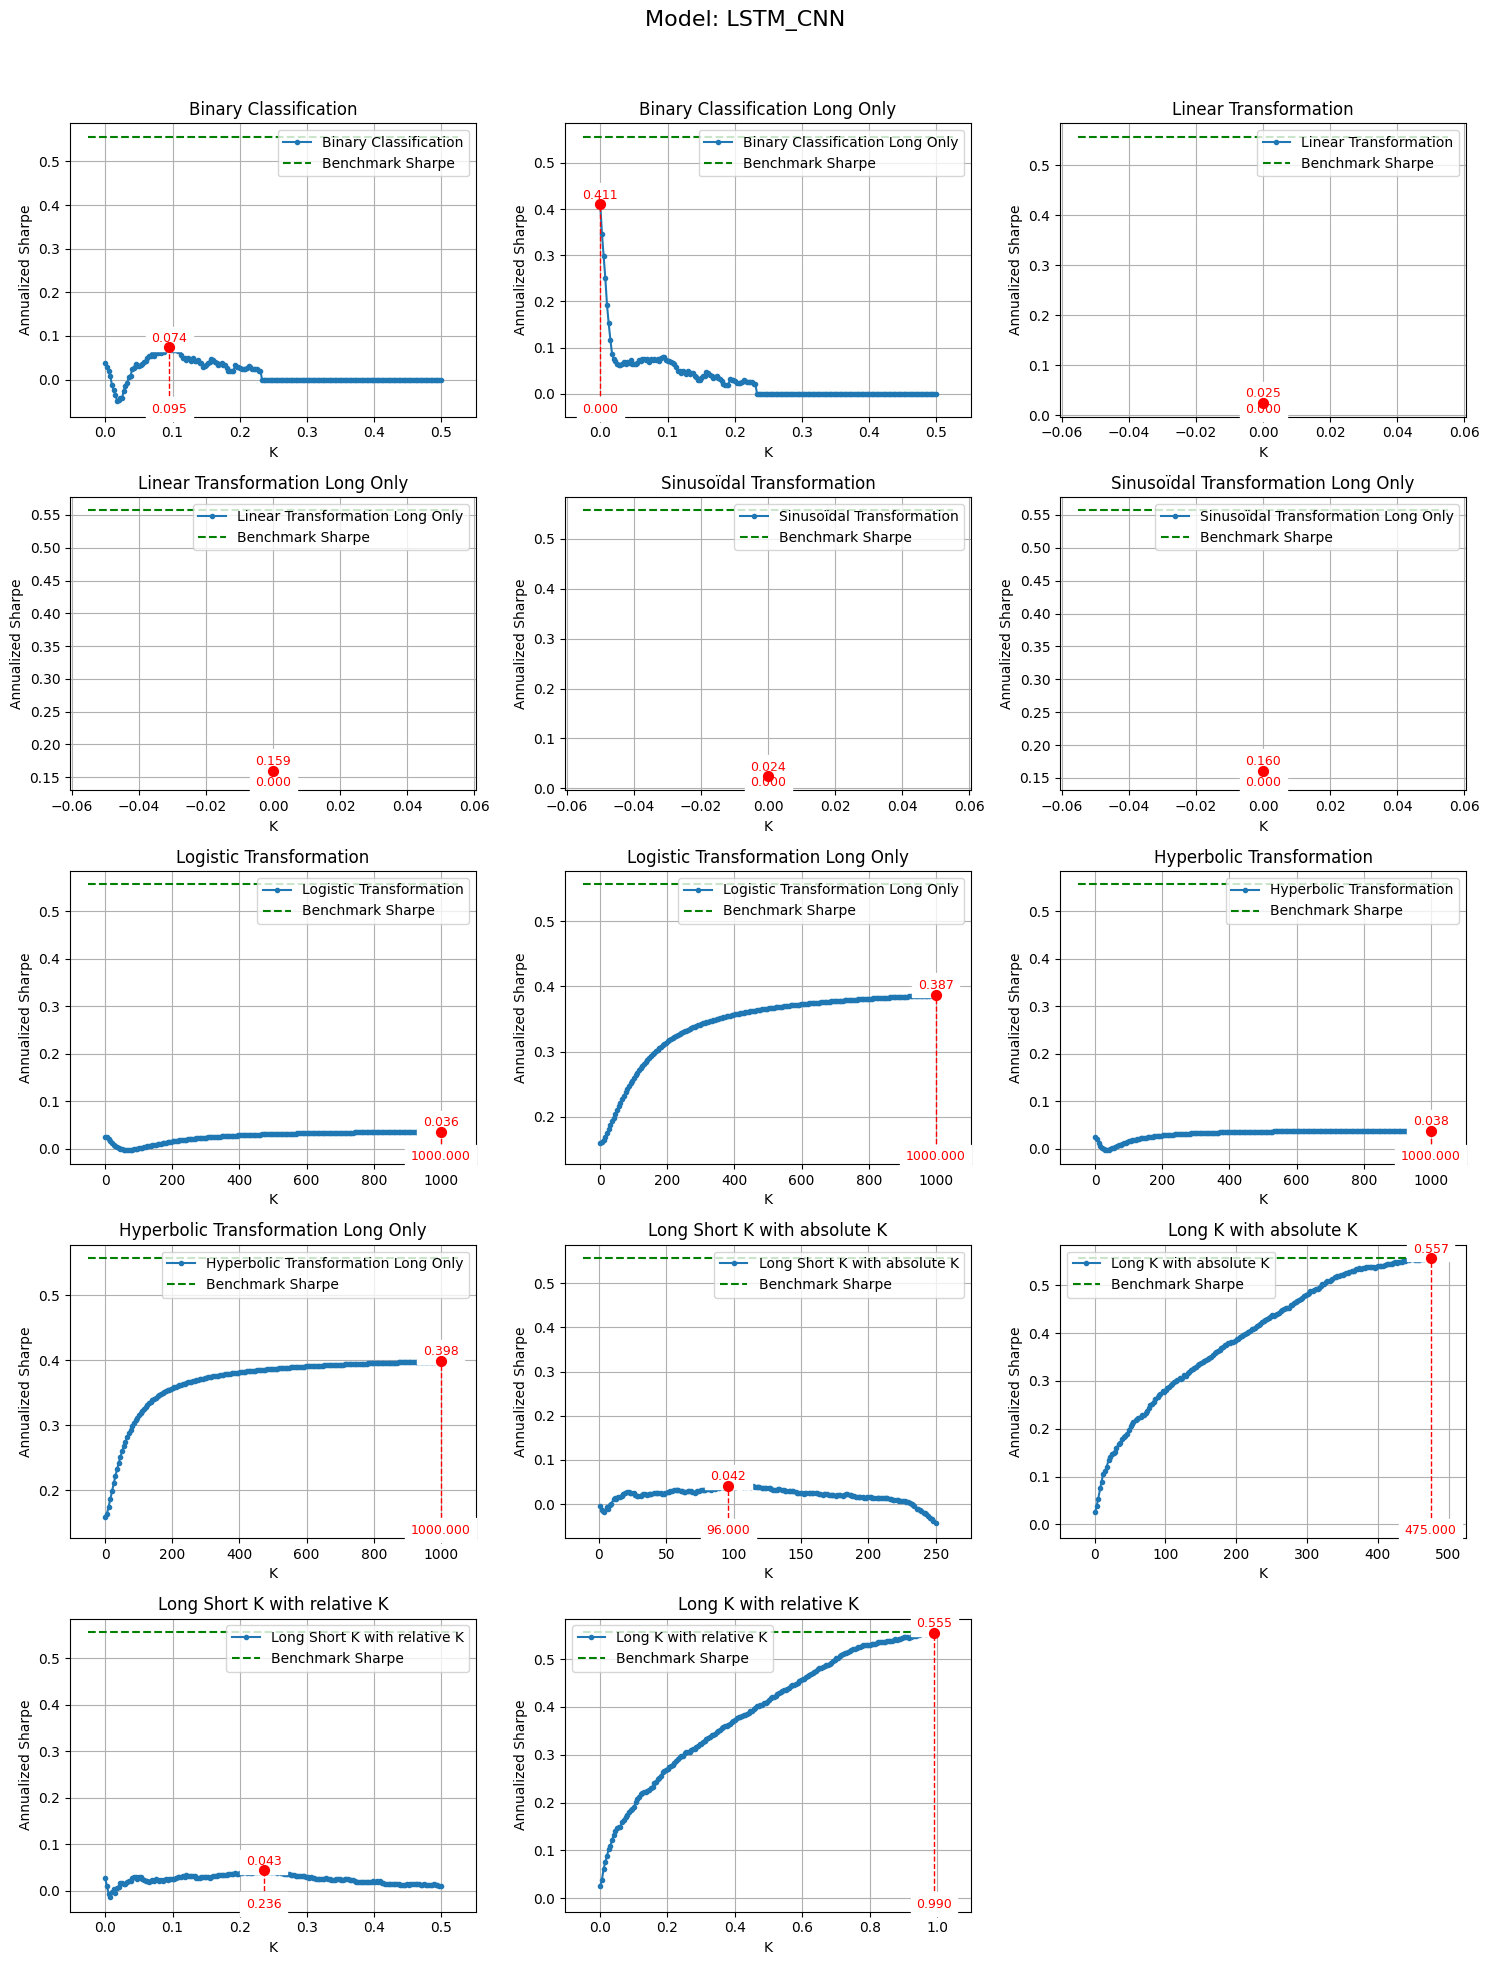

In [27]:
import math
import matplotlib.pyplot as plt

# Prepare overall results once
overall_results = optimization_results_df[
    optimization_results_df['Period'] == 'Overall'
].fillna(0)

# Get unique model names
model_names = overall_results['Model'].unique()

for model_name in model_names:
    # Filter to this model
    model_results = overall_results[overall_results['Model'] == model_name]

    # Extract this model's benchmark Sharpe
    bm_row = model_results[model_results['Name'] == 'Benchmark'].iloc[0]
    benchmark_sharpe = bm_row['Annualized Sharpe']

    # Which strategies to plot (exclude Benchmark)
    plot_strategies = [
        s for s in strategies
        if s['Name'] != 'Benchmark'
           and not model_results[model_results['Name'] == s['Name']].empty
    ]

    n_plots = len(plot_strategies)
    n_cols  = 3
    n_rows  = math.ceil(n_plots / n_cols)

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(5 * n_cols, 4 * n_rows),
        squeeze=False
    )
    axs = axs.flatten()

    for i, strategy in enumerate(plot_strategies):
        strat_name = strategy['Name']
        strat_df   = model_results[model_results['Name'] == strat_name]

        ax = axs[i]
        ax.plot(
            strat_df['K'],
            strat_df['Annualized Sharpe'],
            'o-', markersize=3, linewidth=1.5,
            label=strat_name
        )

        # find & highlight max
        idx_max = strat_df['Annualized Sharpe'].idxmax()
        max_k   = strat_df.loc[idx_max, 'K']
        max_sr  = strat_df.loc[idx_max, 'Annualized Sharpe']

        ax.scatter([max_k], [max_sr], color='red', s=50, zorder=5)
        y_min, y_max = ax.get_ylim()
        x_min, x_max = ax.get_xlim()
        ax.vlines(x=max_k, ymin=y_min, ymax=max_sr,
                  colors='red', linestyles='--', linewidth=1)
        ax.hlines(y=benchmark_sharpe,
                  xmin=x_min, xmax=x_max,
                  linestyles='--', colors='green',
                  label='Benchmark Sharpe')

        ax.text(max_k, max_sr + 0.005, f"{max_sr:.3f}",
                color='red', ha='center', va='bottom',
                fontsize=9, backgroundcolor='white')
        ax.text(max_k, y_min + 0.001, f"{max_k:.3f}",
                color='red', ha='center', va='top',
                fontsize=9, backgroundcolor='white')

        ax.set_title(f"{strat_name}")
        ax.set_xlabel('K')
        ax.set_ylabel('Annualized Sharpe')
        ax.legend()
        ax.grid(True)

    # remove empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(f"Model: {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [28]:
import pandas as pd

# Prepare overall_results once
overall_results = optimization_results_df[
    optimization_results_df['Period'] == 'Overall'
].fillna(0)

# Get unique models
model_names = overall_results['Model'].unique()

for model_name in model_names:
    # 1) filter to this model
    model_res = overall_results[overall_results['Model'] == model_name]

    # 2) for each strategy Name, find index of the max Sharpe
    idx = model_res.groupby('Name')['Annualized Sharpe'].idxmax()

    # 3) pull out those best rows, reset and sort
    best_per_name = (
        model_res
        .loc[idx]
        .reset_index(drop=True)
        .sort_values('Annualized Sharpe', ascending=False)
        .drop(columns=['Period', 'Convolution'])
    )

    # 4) display
    print(f"\n=== Best Annualized Sharpe per Strategy for Model: {model_name} ===")
    display(best_per_name)



=== Best Annualized Sharpe per Strategy for Model: CNN ===


Model                                 Name            K  Annualized return  \
10   CNN               Long K with relative K     0.970025           0.166164   
9    CNN               Long K with absolute K   446.000000           0.165487   
0    CNN                            Benchmark     0.000000           0.171022   
2    CNN      Binary Classification Long Only     0.000000           0.077717   
4    CNN  Hyperbolic Transformation Long Only  1000.000000           0.075909   
8    CNN    Logistic Transformation Long Only  1000.000000           0.073804   
14   CNN  Sinusoïdal Transformation Long Only     0.000000           0.004429   
6    CNN      Linear Transformation Long Only     0.000000           0.002806   
11   CNN         Long Short K with absolute K   159.000000           0.006404   
12   CNN         Long Short K with relative K     0.346040           0.006282   
1    CNN                Binary Classification     0.421266           0.000000   
3    CNN            Hyperbolic Transformation   834.171020          -0.014999   
7    CNN              Logistic Transformation  1000.000000          -0.014871   
5    CNN                Linear Transformation     0.000000          -0.003613   
13   CNN            Sinusoïdal Transformation     0.000000          -0.005335   

    Annualized Vol  Annualized Sharpe  
10        0.297237           0.559029  
9         0.296439           0.558250  
0         0.307117           0.556863  
2         0.204553           0.379935  
4         0.201095           0.377479  
8         0.197534           0.373628  
14        0.022768           0.194532  
6         0.015145           0.185262  
11        0.264501           0.024213  
12        0.264772           0.023728  
1         0.000000           0.000000  
3         0.301757          -0.049705  
7         0.298032          -0.049898  
5         0.034568          -0.104507  
13        0.050173          -0.106331


=== Best Annualized Sharpe per Strategy for Model: LSTM ===


Model                                 Name            K  Annualized return  \
9   LSTM               Long K with absolute K   439.000000           0.165550   
10  LSTM               Long K with relative K     0.930065           0.162596   
0   LSTM                            Benchmark     0.000000           0.171022   
2   LSTM      Binary Classification Long Only     0.000000           0.091935   
4   LSTM  Hyperbolic Transformation Long Only  1000.000000           0.088160   
8   LSTM    Logistic Transformation Long Only  1000.000000           0.084691   
14  LSTM  Sinusoïdal Transformation Long Only     0.000000           0.003490   
6   LSTM      Linear Transformation Long Only     0.000000           0.002226   
12  LSTM         Long Short K with relative K     0.150452           0.011983   
11  LSTM         Long Short K with absolute K   178.000000           0.017729   
1   LSTM                Binary Classification     0.072719           0.001559   
7   LSTM              Logistic Transformation   597.990352           0.012060   
3   LSTM            Hyperbolic Transformation   296.483116           0.012049   
5   LSTM                Linear Transformation     0.000000           0.000294   
13  LSTM            Sinusoïdal Transformation     0.000000           0.000458   

    Annualized Vol  Annualized Sharpe  
9         0.295911           0.559460  
10        0.291544           0.557707  
0         0.307117           0.556863  
2         0.212744           0.432139  
4         0.206390           0.427151  
8         0.199865           0.423740  
14        0.012873           0.271081  
6         0.008234           0.270382  
12        0.183599           0.065268  
11        0.274889           0.064496  
1         0.025942           0.060106  
7         0.277850           0.043404  
3         0.277606           0.043404  
5         0.012404           0.023723  
13        0.019405           0.023600


=== Best Annualized Sharpe per Strategy for Model: LSTM_CNN ===


Model                                 Name            K  \
0   LSTM_CNN                            Benchmark     0.000000   
9   LSTM_CNN               Long K with absolute K   475.000000   
10  LSTM_CNN               Long K with relative K     0.990005   
2   LSTM_CNN      Binary Classification Long Only     0.000000   
4   LSTM_CNN  Hyperbolic Transformation Long Only  1000.000000   
8   LSTM_CNN    Logistic Transformation Long Only  1000.000000   
14  LSTM_CNN  Sinusoïdal Transformation Long Only     0.000000   
6   LSTM_CNN      Linear Transformation Long Only     0.000000   
1   LSTM_CNN                Binary Classification     0.095286   
12  LSTM_CNN         Long Short K with relative K     0.235709   
11  LSTM_CNN         Long Short K with absolute K    96.000000   
3   LSTM_CNN            Hyperbolic Transformation  1000.000000   
7   LSTM_CNN              Logistic Transformation  1000.000000   
5   LSTM_CNN                Linear Transformation     0.000000   
13  LSTM_CNN            Sinusoïdal Transformation     0.000000   

    Annualized return  Annualized Vol  Annualized Sharpe  
0            0.171022        0.307117           0.556863  
9            0.171009        0.307111           0.556832  
10           0.168701        0.304076           0.554799  
2            0.091395        0.222643           0.410501  
4            0.085858        0.215694           0.398054  
8            0.080579        0.208479           0.386508  
14           0.003755        0.023440           0.160176  
6            0.002419        0.015207           0.159061  
1            0.003162        0.042960           0.073593  
12           0.009631        0.222609           0.043265  
11           0.008848        0.211671           0.041802  
3            0.011208        0.297189           0.037712  
7            0.010266        0.286995           0.035771  
5            0.000437        0.017426           0.025091  
13           0.000649        0.026954           0.024062

In [31]:
import pandas as pd

# 1) filter to overall‐only and fill na
overall_results = (
    optimization_results_df
    .query("Period == 'Overall'")
    .fillna(0)
)

# 2) top 10 _non‐benchmark_ strategies by Sharpe
strategies_only = overall_results[overall_results['Name'] != 'Benchmark']
top10 = (
    strategies_only
    .sort_values('Annualized Sharpe', ascending=False)
    .head(10)
)

# 3) grab the benchmark rows for the same models in top10
benchmarks = overall_results[
    (overall_results['Name'] == 'Benchmark') &
    (overall_results['Model'].isin(top10['Model']))
]

# 4) combine
best10_with_benchmark = pd.concat([top10, benchmarks], ignore_index=True)

# 5) (optional) re‐sort for readability
best10_with_benchmark = (
    best10_with_benchmark
    .sort_values(['Model', 'Name', 'Annualized Sharpe'],
                 ascending=[True, True, False])
    .reset_index(drop=True)
)

# 6) show only the key columns
result_df = best10_with_benchmark[['Model', 'Name', 'K', 'Annualized Sharpe']].sort_values('Annualized Sharpe', ascending=False)
print(result_df)


   Model                    Name           K  Annualized Sharpe
3   LSTM  Long K with absolute K  439.000000           0.559460
4   LSTM  Long K with absolute K  427.000000           0.559343
5   LSTM  Long K with absolute K  415.000000           0.559213
6   LSTM  Long K with absolute K  436.000000           0.559106
1    CNN  Long K with relative K    0.970025           0.559029
7   LSTM  Long K with absolute K  413.000000           0.558753
8   LSTM  Long K with absolute K  429.000000           0.558743
9   LSTM  Long K with absolute K  432.000000           0.558476
10  LSTM  Long K with absolute K  434.000000           0.558424
11  LSTM  Long K with absolute K  441.000000           0.558328
2   LSTM               Benchmark    0.000000           0.556863
0    CNN               Benchmark    0.000000           0.556863
